# Analyzing On-Target gRNA Performance

In [1]:
# Data Cleaning packages
library(spgs)
library(expss)
library(stats)
library(dplyr)
library(caret)
library(Seurat)
library(ggpubr)
library(stringr)
library(rstatix)
library(cluster)
library(corrplot)
library(data.table)
library(tidyverse)

# labels and columns I want to change
ctrl_label = 'Control'
cell_cycle_labels = c("G1", "S", "G2M")
gene_meta_cols = c('Gene_Symbol', 'Category', 'Essentiality')
grna_meta_cols = c('grna_name', 'Brunello', 'Edwards', 'Yuza', 'different_cut', 'Comments', 'gRNA_Reference')

# creating filepaths to the relevant datasets for Edwards Data
edwards_dir = '../data'
edwards_grna_mat_fp = paste0(edwards_dir, '/SCE/grna_barcodes/rep2')

merged_mixscape_fp = paste0(edwards_dir, '/SCE/Merged_mixscape.Rds')
yuza_mixscape_fp = paste0(edwards_dir, '/SCE/Yuza_mixscape.Rds')
edwards_mixscape_fp = paste0(edwards_dir, '/SCE/Edwards_mixscape.Rds')
brunello_mixscape_fp = paste0(edwards_dir, '/SCE/Brunello_mixscape.Rds')

# loading gRNA Metadata and Gene Metadata
Edwards_grna_meta = read.csv(paste0(edwards_dir, '/Metadata/guide_library_key.csv'), col.names=grna_meta_cols)
Edwards_gene_metadata = read.csv(paste0(edwards_dir, '/Metadata/gene_metadata.csv'), col.names=gene_meta_cols)
rownames(Edwards_gene_metadata) = Edwards_gene_metadata$Gene_Symbol

# Carroll Lab Metadata
carroll = read.csv('../data/External_Studies_gRNA_Metadata/gene_level_pairwise_log_fold_change.csv')

Loading required package: maditr


To select rows from data: rows(mtcars, am==0)



Use 'expss_output_viewer()' to display tables in the RStudio Viewer.
 To return to the console output, use 'expss_output_default()'.



Attaching package: ‘dplyr’


The following objects are masked from ‘package:expss’:

    compute, contains, na_if, recode, vars


The following objects are masked from ‘package:maditr’:

    between, coalesce, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:expss’:

    vars


Loading required package: lattice


Attaching package: ‘ggpubr’


The following object is masked from ‘package:expss’:

    compare_means



Attaching package: ‘stringr’


The following objects are masked from ‘package:expss’:

    fixed, regex



Attac

In [2]:
?cor

cor                   package:stats                    R Documentation

_C_o_r_r_e_l_a_t_i_o_n, _V_a_r_i_a_n_c_e _a_n_d _C_o_v_a_r_i_a_n_c_e (_M_a_t_r_i_c_e_s)

_D_e_s_c_r_i_p_t_i_o_n:

     ‘var’, ‘cov’ and ‘cor’ compute the variance of ‘x’ and the
     covariance or correlation of ‘x’ and ‘y’ if these are vectors.  If
     ‘x’ and ‘y’ are matrices then the covariances (or correlations)
     between the columns of ‘x’ and the columns of ‘y’ are computed.

     ‘cov2cor’ scales a covariance matrix into the corresponding
     correlation matrix _efficiently_.

_U_s_a_g_e:

     var(x, y = NULL, na.rm = FALSE, use)
     
     cov(x, y = NULL, use = "everything",
         method = c("pearson", "kendall", "spearman"))
     
     cor(x, y = NULL, use = "everything",
         method = c("pearson", "kendall", "spearman"))
     
     cov2cor(V)
     
_A_r_g_u_m_e_n_t_s:

       x: a numeric vector, matrix or data frame.

       y: ‘NULL’ (default) or a vector, matrix or data frame with
          compatible dimensions to ‘x’.  The default is equivalent to
          ‘y = x’ (but more efficient).

   na.rm: logical. Should missing values be removed?

     use: an optional character string giving a method for computing
          covariances in the presence of missing values.  This must be
          (an abbreviation of) one of the strings ‘"everything"’,
          ‘"all.obs"’, ‘"complete.obs"’, ‘"na.or.complete"’, or
          ‘"pairwise.complete.obs"’.

  method: a character string indicating which correlation coefficient
          (or covariance) is to be computed.  One of ‘"pearson"’
          (default), ‘"kendall"’, or ‘"spearman"’: can be abbreviated.

       V: symmetric numeric matrix, usually positive definite such as a
          covariance matrix.

_D_e_t_a_i_l_s:

     For ‘cov’ and ‘cor’ one must _either_ give a matrix or data frame
     for ‘x’ _or_ give both ‘x’ and ‘y’.

     The inputs must be numeric (as determined by ‘is.numeric’: logical
     values are also allowed for historical compatibility): the
     ‘"kendall"’ and ‘"spearman"’ methods make sense for ordered inputs
     but ‘xtfrm’ can be used to find a suitable prior transformation to
     numbers.

     ‘var’ is just another interface to ‘cov’, where ‘na.rm’ is used to
     determine the default for ‘use’ when that is unspecified.  If
     ‘na.rm’ is ‘TRUE’ then the complete observations (rows) are used
     (‘use = "na.or.complete"’) to compute the variance.  Otherwise, by
     default ‘use = "everything"’.

     If ‘use’ is ‘"everything"’, ‘NA’s will propagate conceptually,
     i.e., a resulting value will be ‘NA’ whenever one of its
     contributing observations is ‘NA’.
     If ‘use’ is ‘"all.obs"’, then the presence of missing observations
     will produce an error.  If ‘use’ is ‘"complete.obs"’ then missing
     values are handled by casewise deletion (and if there are no
     complete cases, that gives an error).

     ‘"na.or.complete"’ is the same unless there are no complete cases,
     that gives ‘NA’.  Finally, if ‘use’ has the value
     ‘"pairwise.complete.obs"’ then the correlation or covariance
     between each pair of variables is computed using all complete
     pairs of observations on those variables.  This can result in
     covariance or correlation matrices which are not positive
     semi-definite, as well as ‘NA’ entries if there are no complete
     pairs for that pair of variables.  For ‘cov’ and ‘var’,
     ‘"pairwise.complete.obs"’ only works with the ‘"pearson"’ method.
     Note that (the equivalent of) ‘var(double(0), use = *)’ gives ‘NA’
     for ‘use = "everything"’ and ‘"na.or.complete"’, and gives an
     error in the other cases.

     The denominator n - 1 is used which gives an unbiased estimator of
     the (co)variance for i.i.d. observations.  These functions return
     ‘NA’ when there is only one observation (whereas S-PLUS has been
     returnin

# Utility Function

In [77]:
extract_grna_sequences = function(cells_meta, grna_mat_fp){
  grna_seqs = c()
  grna_names = c()
  grna_count = Read10X(grna_mat_fp, gene.column = 1)
  grna_barcodes = str_split(rownames(grna_count), '-')
  
  for (grna_vector in grna_barcodes) {
    split_length = length(grna_vector)
    
    if (split_length == 3) {
      grna_vector = c(paste0(grna_vector[1], grna_vector[2]), grna_vector[3])
    }
    
    if (grna_vector[1] != 'unmapped'){
      grna_seq = tail(grna_vector,  n=1)
      grna_names = c(grna_names, grna_vector[1])
      grna_seqs = c(grna_seqs, toupper(reverseComplement(grna_vector[2])))
    }
  }
  
  # add guide RNA sequence to the single cell metadata. This is important to merge gRNA metadata
  grna_barcodes = data.frame(grna_name=grna_names, guideSeq=grna_seqs)
  cells_meta = left_join(cells_meta, grna_barcodes, by='grna_name')
  
  return (cells_meta)
}


assign_grna_library = function(data, grna_meta, label) {
    
    data = data %>%
            filter((grna_name %in% grna_meta$grna_name) | (gene == label)) %>%
            left_join(grna_meta[, c('grna_name', 'library')], by='grna_name') %>%
            mutate(grna_name = as.character(grna_name),
                   mixscape_class.global = as.character(mixscape_class.global),
                   grna_name = ifelse(grepl("NO_SITE", grna_name), ctrl_label, grna_name), 
                   library = ifelse(gene == ctrl_label, ctrl_label, library),
                   global_mixscape = ifelse(mixscape_class.global == ctrl_label, 'NP', mixscape_class.global)) %>%
            rename(cell_barcode = NAME)
    
    return (data)
}

creating_dup_cells_per_library = function(cell_meta, grna_meta, libraries=c('Brunello', 'Edwards', 'Yuza')) {
    temp_cell_meta = data.frame()

    for (i in 1:nrow(cell_meta)) {
        # extract individual cell and gRNA specific metadata 
        cell = cell_meta[i, ]
        grna = grna_meta %>% filter(grna_name == cell$grna_name)
        
        for (lib in libraries) {
            is_present = grna[, lib]
            
            if (is_present == 1) {
                dup = cell 
                dup$library = lib
                dup$grna_name = paste0(cell$grna_name, '_', lib)
                temp_cell_meta = rbind(temp_cell_meta, dup)   
            }
        }
    }
    
    return (temp_cell_meta)
}

calc_cell_cycle_perc = function(data) {
    
    cell_cycle = data %>% 
                    group_by(library, gene, global_mixscape, Phase) %>%
                    tally() %>%
                    group_by(library, gene, global_mixscape) %>%
                    mutate(cell_count = sum(n), percentage = 100 * (n / sum(n)))
    
    return (cell_cycle)
}

calc_gene_ko = function (data, label=ctrl_label, min_ko_perc_threshold=0.3) {
    # these functions assumes we're working on individual library level
    ko_data = data %>% filter(global_mixscape != label) %>%
                    group_by(library, gene, global_mixscape) %>%
                    summarize(num_of_cells = n()) %>%
                    mutate(perc=num_of_cells / sum(num_of_cells)) %>%
                    filter((perc != 1) & (global_mixscape == 'KO') & (perc > min_ko_perc_threshold))
    
    return (ko_data)
}

calc_grna_ko = function(data, label=ctrl_label, min_ko_perc_threshold=0.3) {
     # these functions assumes we're working on individual library level
    ko_data = data %>% filter(global_mixscape != label) %>%
                 group_by(library, gene, grna_name, global_mixscape) %>%
                 summarize(num_of_cells = n()) %>%
                 mutate(perc=num_of_cells / sum(num_of_cells)) %>%
                 filter((perc != 1) & (global_mixscape == 'KO') & (perc > min_ko_perc_threshold))
    
    return (ko_data)
}

## Creating Duplicate Cells for Each Libraries

In [78]:
yuza_sce = readRDS(yuza_mixscape_fp)
edwards_sce = readRDS(edwards_mixscape_fp)
brunello_sce = readRDS(brunello_mixscape_fp)
merged_sce = readRDS(merged_mixscape_fp)

In [79]:
yuza = extract_grna_sequences(yuza_sce[[]], edwards_grna_mat_fp)
edwards = extract_grna_sequences(edwards_sce[[]], edwards_grna_mat_fp)
brunello = extract_grna_sequences(brunello_sce[[]], edwards_grna_mat_fp)


yuza = yuza %>% mutate(global_mixscape = ifelse(mixscape_class.global == ctrl_label, 
                                                'NP', mixscape_class.global),
                       library='Yuza')

edwards = edwards %>% mutate(global_mixscape = ifelse(mixscape_class.global == ctrl_label,
                                                      'NP',mixscape_class.global),
                             library='Edwards')
brunello = brunello %>% mutate(global_mixscape = ifelse(mixscape_class.global == ctrl_label,
                                                        'NP',mixscape_class.global),
                               library='Brunello')

merged = merged_sce[[]] %>% mutate(global_mixscape = ifelse(mixscape_class.global == ctrl_label, 'NP',mixscape_class.global),
                                   library='merged')

In [80]:
# calculating cell cycle 
yuza_cell_cycle = calc_cell_cycle_perc(yuza)
edwards_cell_cycle = calc_cell_cycle_perc(edwards)
brunello_cell_cycle = calc_cell_cycle_perc(brunello)
merged_cell_cycle = calc_cell_cycle_perc(merged)

cell_cycle = rbind(yuza_cell_cycle, edwards_cell_cycle, brunello_cell_cycle)

In [81]:
test <- top_11_genes <- c('Control', 'TFAP2C', 'MYC', 'GATA3', 'MTOR', 'SMC1A', 'ESR1', 'FOXA1', 'NCOA3', 'CREBBP', 'MED1', 'CCND1')

for (gene in unique(merged_cell_cycle$gene)) {
    if (gene %in% top_11_genes) {
        next ()
    }
    
    test <- c(test, gene)
}

merged_cell_cycle$gene <- factor(merged_cell_cycle$gene, levels=test)

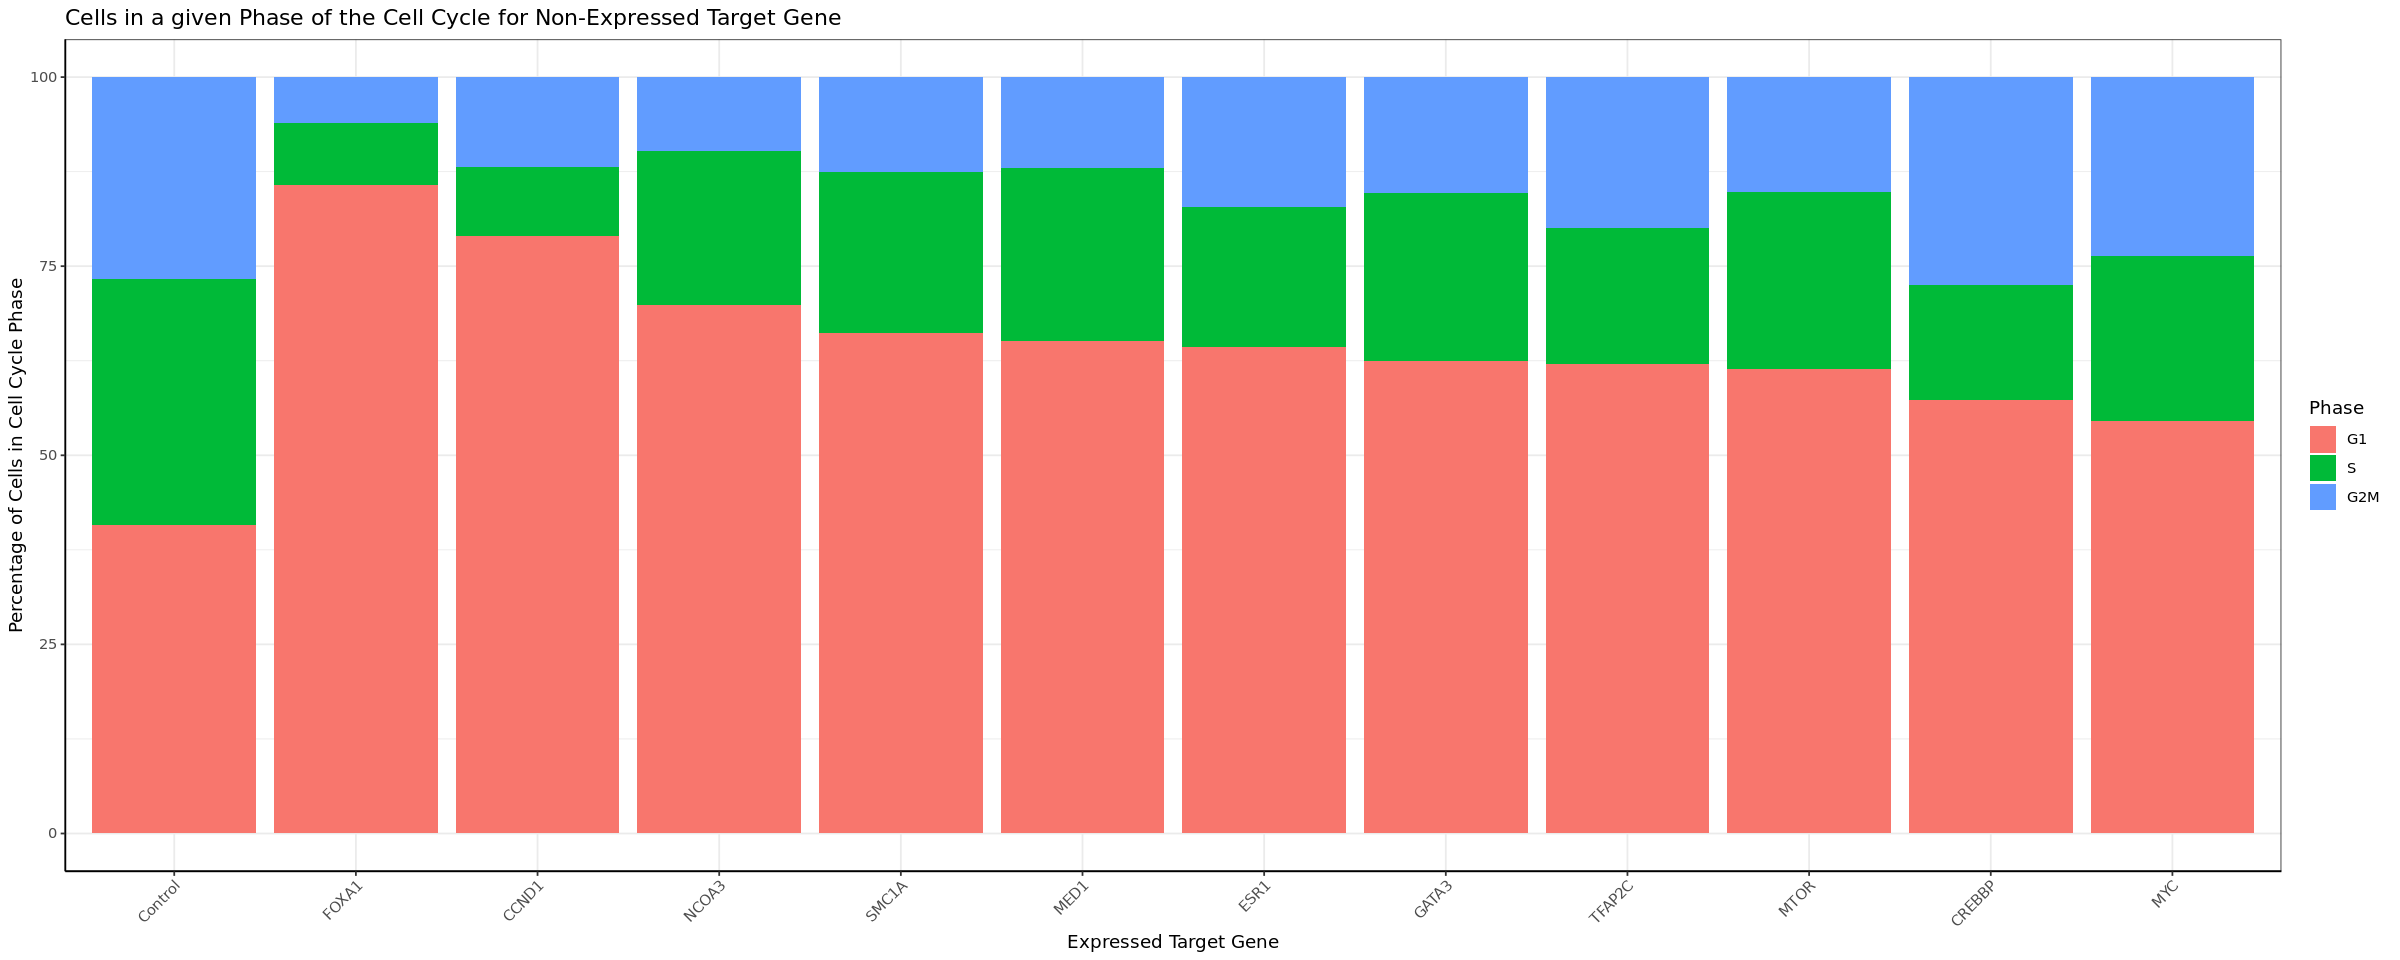

In [82]:
gene_order <- merged_cell_cycle %>%
                filter(gene %in% top_11_genes & library != 'Yuza') %>%
                filter(global_mixscape == 'KO') %>%
                filter(Phase == 'G1') %>% 
                arrange(desc(percentage)) %>% 
                pull(gene) %>% as.character

gene_levels <- c('Control', gene_order)

# expressed genes cell cycle plot
cycle_bar <- merged_cell_cycle %>%
                  filter(gene %in% top_11_genes & library != 'Yuza') %>%
                  filter(global_mixscape == 'KO' | gene == 'Control') %>% 
                  mutate(gene=factor(gene, levels=gene_levels),
                         Phase=factor(Phase, levels=c('G1', 'S', 'G2M'))) %>%
                  ggplot(aes(x=gene, y=percentage, fill=Phase)) +
                     geom_col(position = position_stack(reverse = TRUE)) +
                     theme_bw() +
                    theme(axis.line = element_line(color = 'black'),
                          axis.text.x = element_text(angle = 45, hjust = 1)) +
                    labs(y='Percentage of Cells in Cell Cycle Phase',
                         x='Expressed Target Gene',
                         title='Cells in a given Phase of the Cell Cycle for Non-Expressed Target Gene')

cycle_bar

In [83]:
ggsave("merged_cell_cycle_bar_plot.eps", plot=cycle_bar, height=8, width=8, units="in", device = "eps")

# Analysis of Yuza Library

## Exploring the Percentage of Cells in a Cell Cycle for a Given Target Gene

Comparing the percentage of Cells in the Cell Cycle for a given Target Genes. This always use to observe potiential changes in the number of cells in a given phase of the cell cycle between Perturbed and Non-Perturbed Cells. Additionally, the i plotted the percentage of cells in a given phase of cell cycle for control cells. General Observation I have is that most perturbed cells regardless of target genes tend to have more cells in the G1 phase of the Cell Cycle.

### Creating Merged and Non-Merged Perturbed Cell Metadata

In [84]:
# Calculating percentage of cells in each phase of the cell cycle
yuza_cell_cycle = calc_cell_cycle_perc(yuza)

# extract non expressed and expressed target genes as separate vectors
expr_genes = rownames(Edwards_gene_metadata[Edwards_gene_metadata$Category != 'Unknown', ])
non_expr_genes = rownames(Edwards_gene_metadata[Edwards_gene_metadata$Category == 'Unknown', ])

# adding controls to these vectors. This allows me to select which gene set i want to visualize
non_expr_genes = c(non_expr_genes, ctrl_label)

# reorder genes so control at the start of the figures
genes_order = c(ctrl_label, as.character(unique(yuza_cell_cycle$gene[yuza_cell_cycle$gene != ctrl_label])))

yuza_cell_cycle$gene_order = factor(yuza_cell_cycle$gene, levels=genes_order, labels=genes_order)
yuza_cell_cycle$Phase = factor(yuza_cell_cycle$Phase, levels=c("G1", "S", "G2M"), labels=c("G1", "S", "G2M"))
yuza$gene_order = factor(yuza$gene, levels=genes_order, labels=genes_order)

## Percentage of Cells in Phases of Cell Cycle for Non Expressed Target Genes

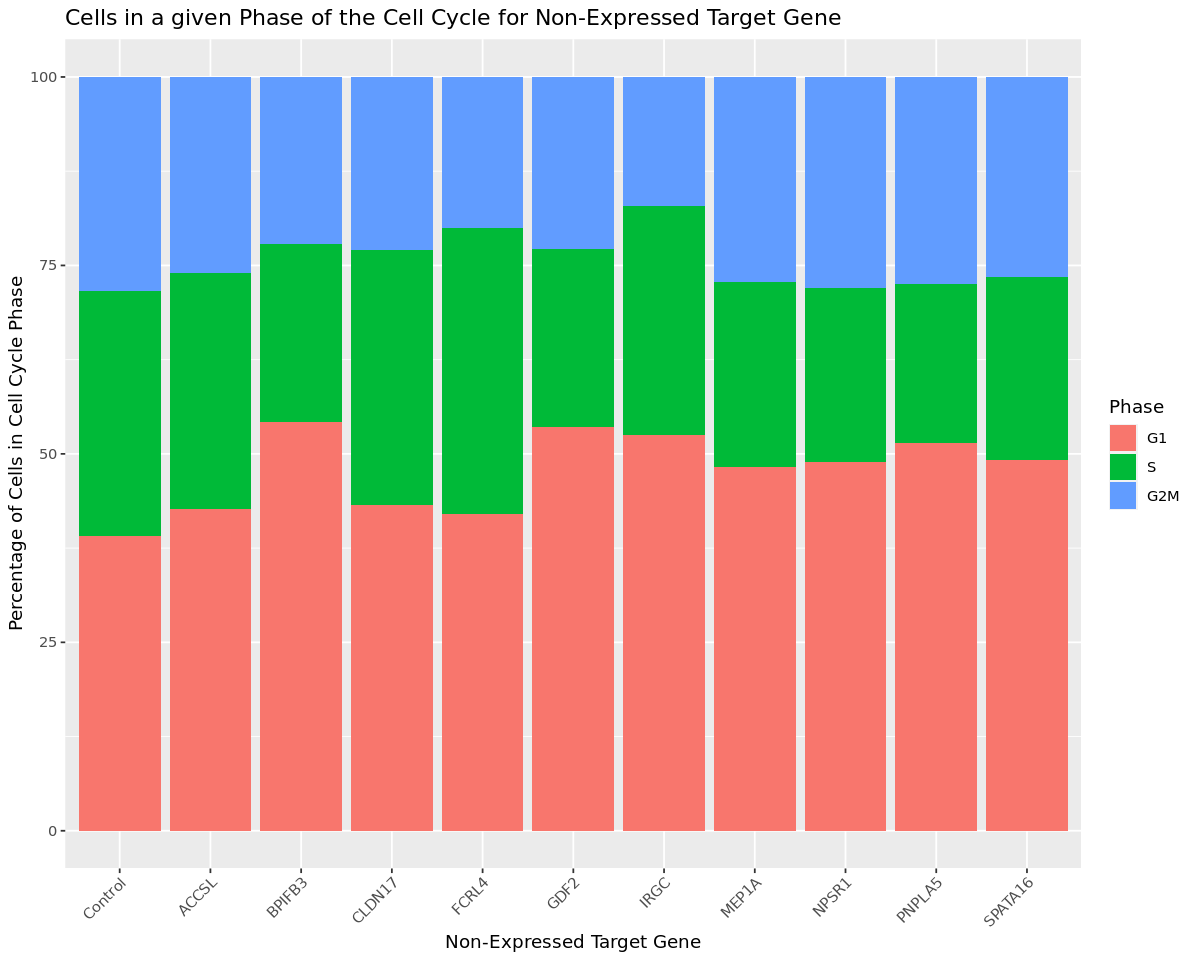

In [85]:
options(repr.plot.width=10, repr.plot.height=8)
yuza_cell_cycle %>%
  filter(gene %in% non_expr_genes) %>%
  ggplot(aes(x=gene_order, y=percentage, fill=Phase)) +
    geom_col(position = position_stack(reverse = TRUE)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(y='Percentage of Cells in Cell Cycle Phase', x='Non-Expressed Target Gene',
         title='Cells in a given Phase of the Cell Cycle for Non-Expressed Target Gene')

## Percentage of Cells in Phases of Cell Cycle for Non Expressed Target Genes - Enlarged

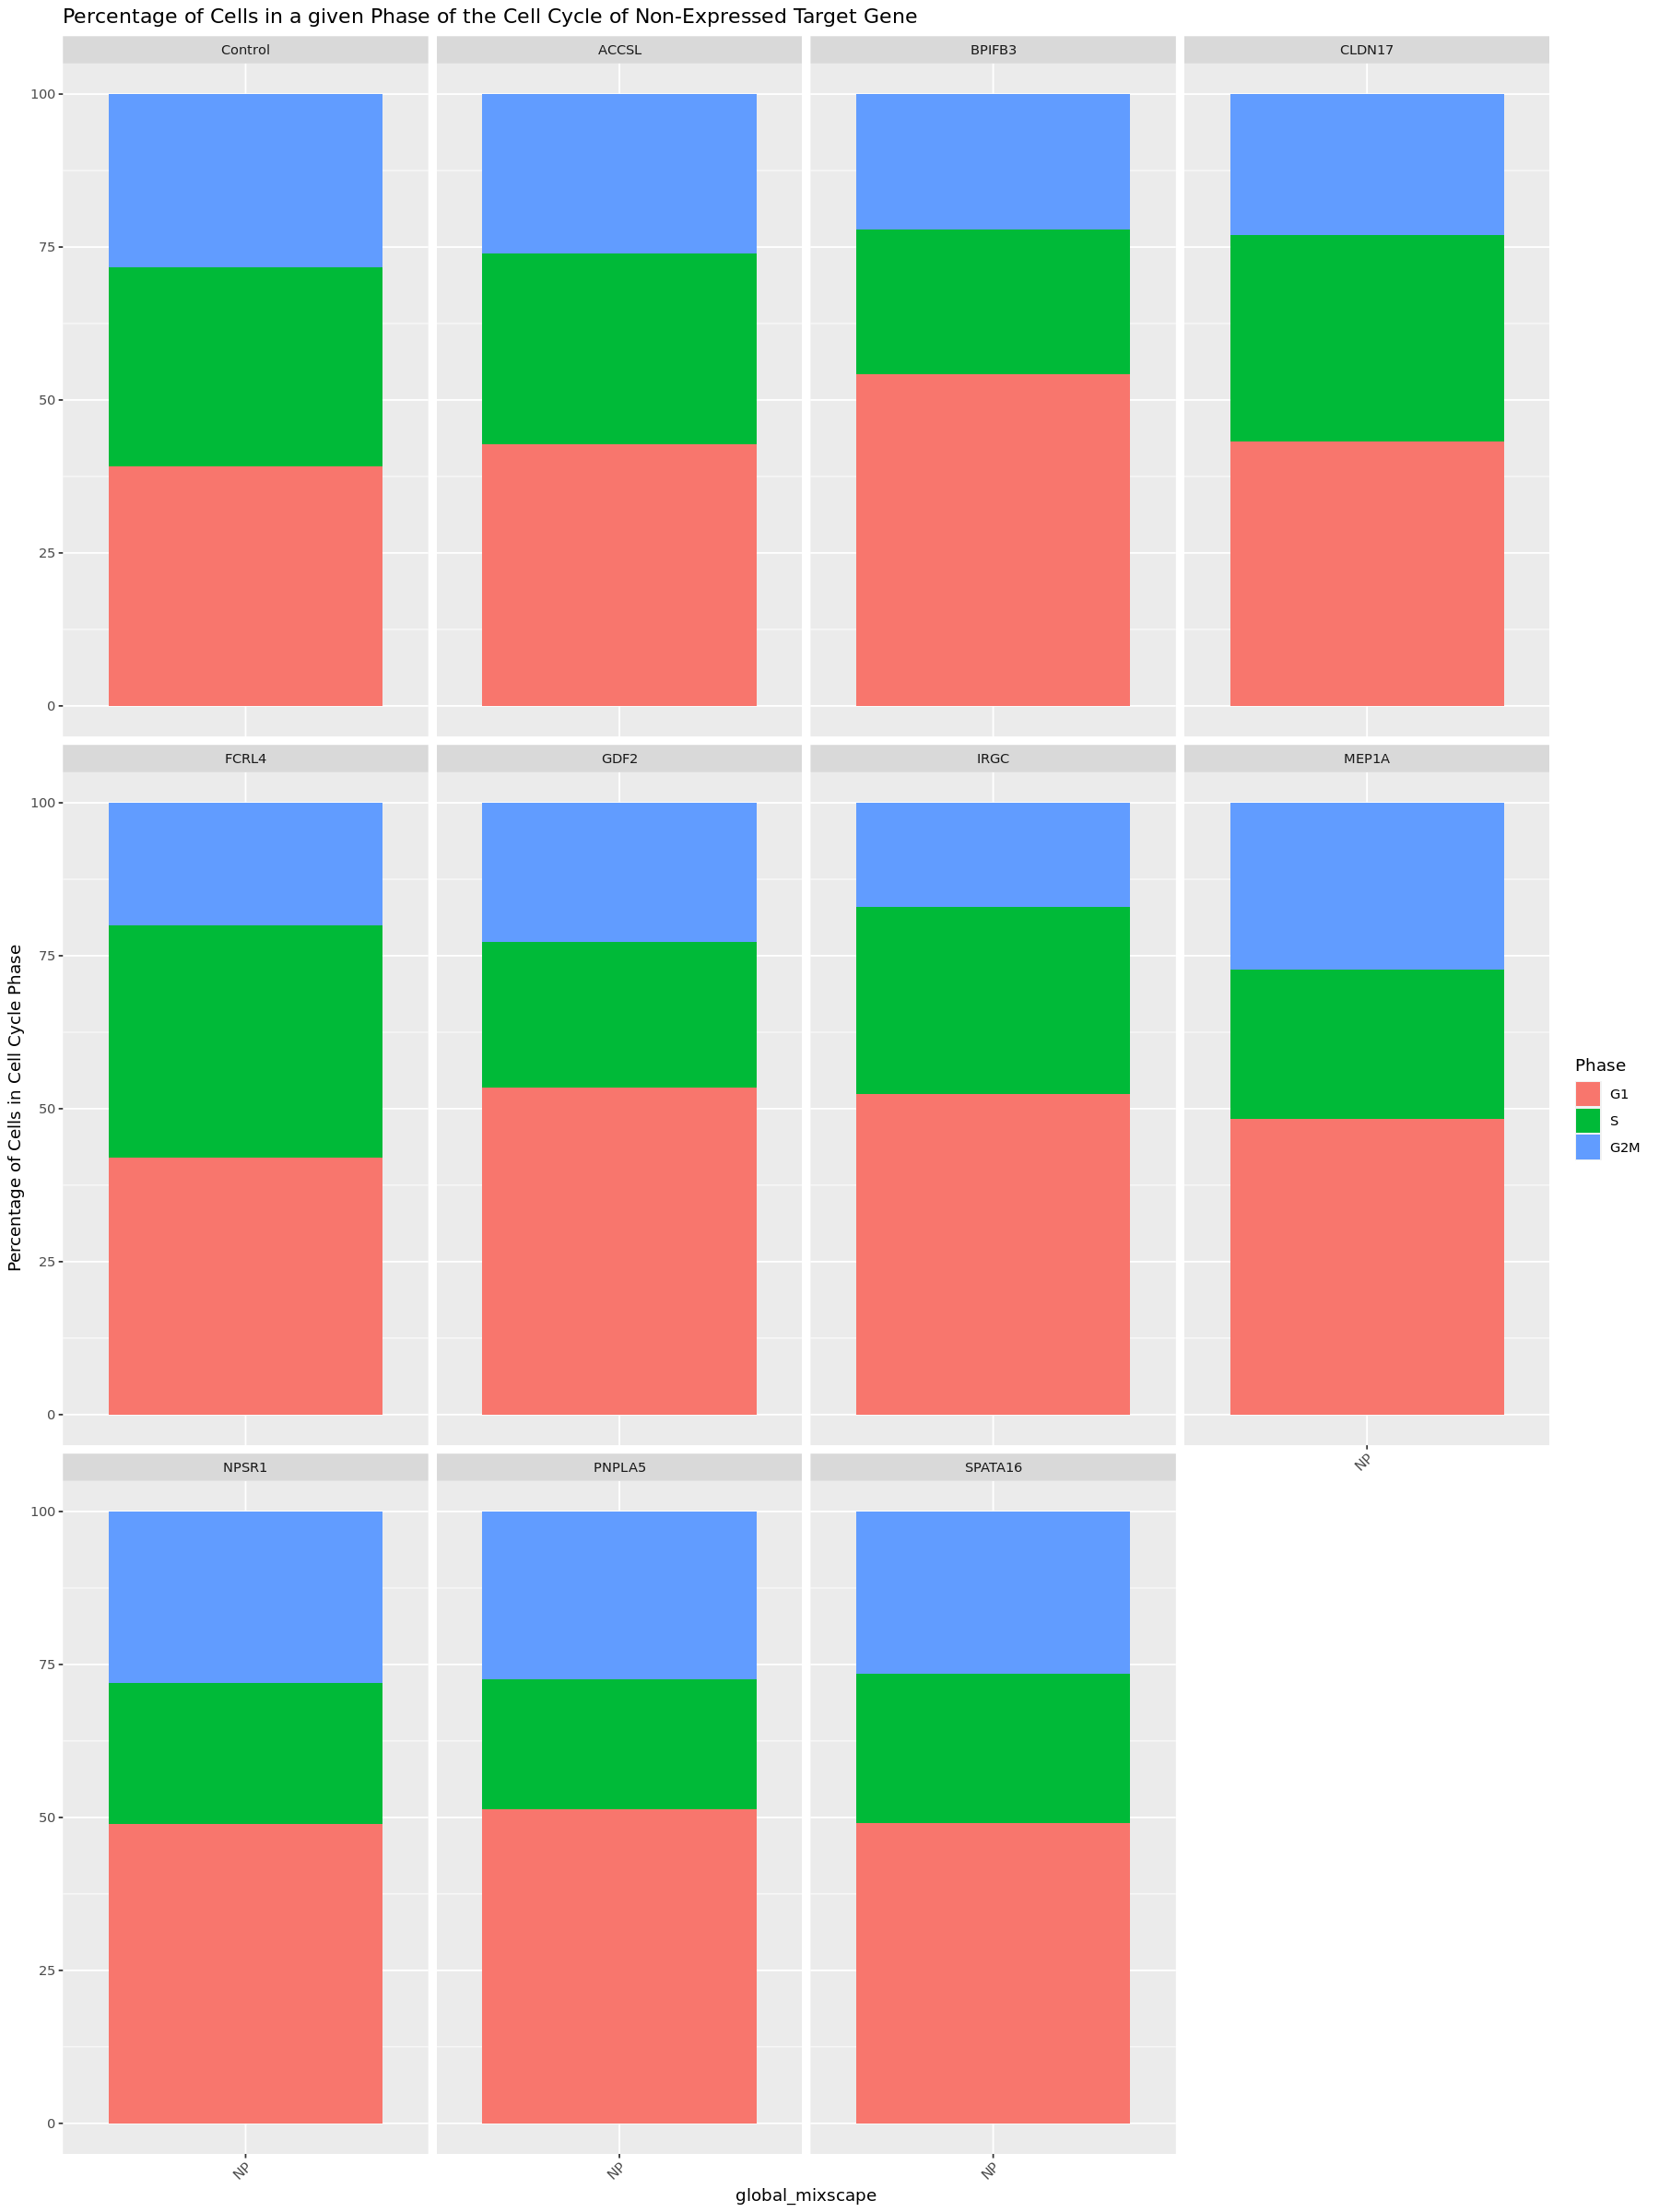

In [86]:
# plotting the percentage of cells in a given phase of the cell cycle on a given target gene
options(repr.plot.width=15, repr.plot.height=20)

yuza_cycle_plot = yuza_cell_cycle %>% 
                          filter(gene %in% non_expr_genes) %>% 
                          ggplot(aes(x=global_mixscape, y=percentage, fill=Phase)) +
                            geom_col(position = position_stack(reverse = TRUE)) +
                            theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                            labs(y='Percentage of Cells in Cell Cycle Phase', 
                                 title='Percentage of Cells in a given Phase of the Cell Cycle of Non-Expressed Target Gene', 
                                 colour='Cell Cycle Phase') +
                           facet_wrap(~gene_order) 

yuza_cycle_plot

## Percentage of Cells in Phases of Cell Cycle for Expressed Target Genes

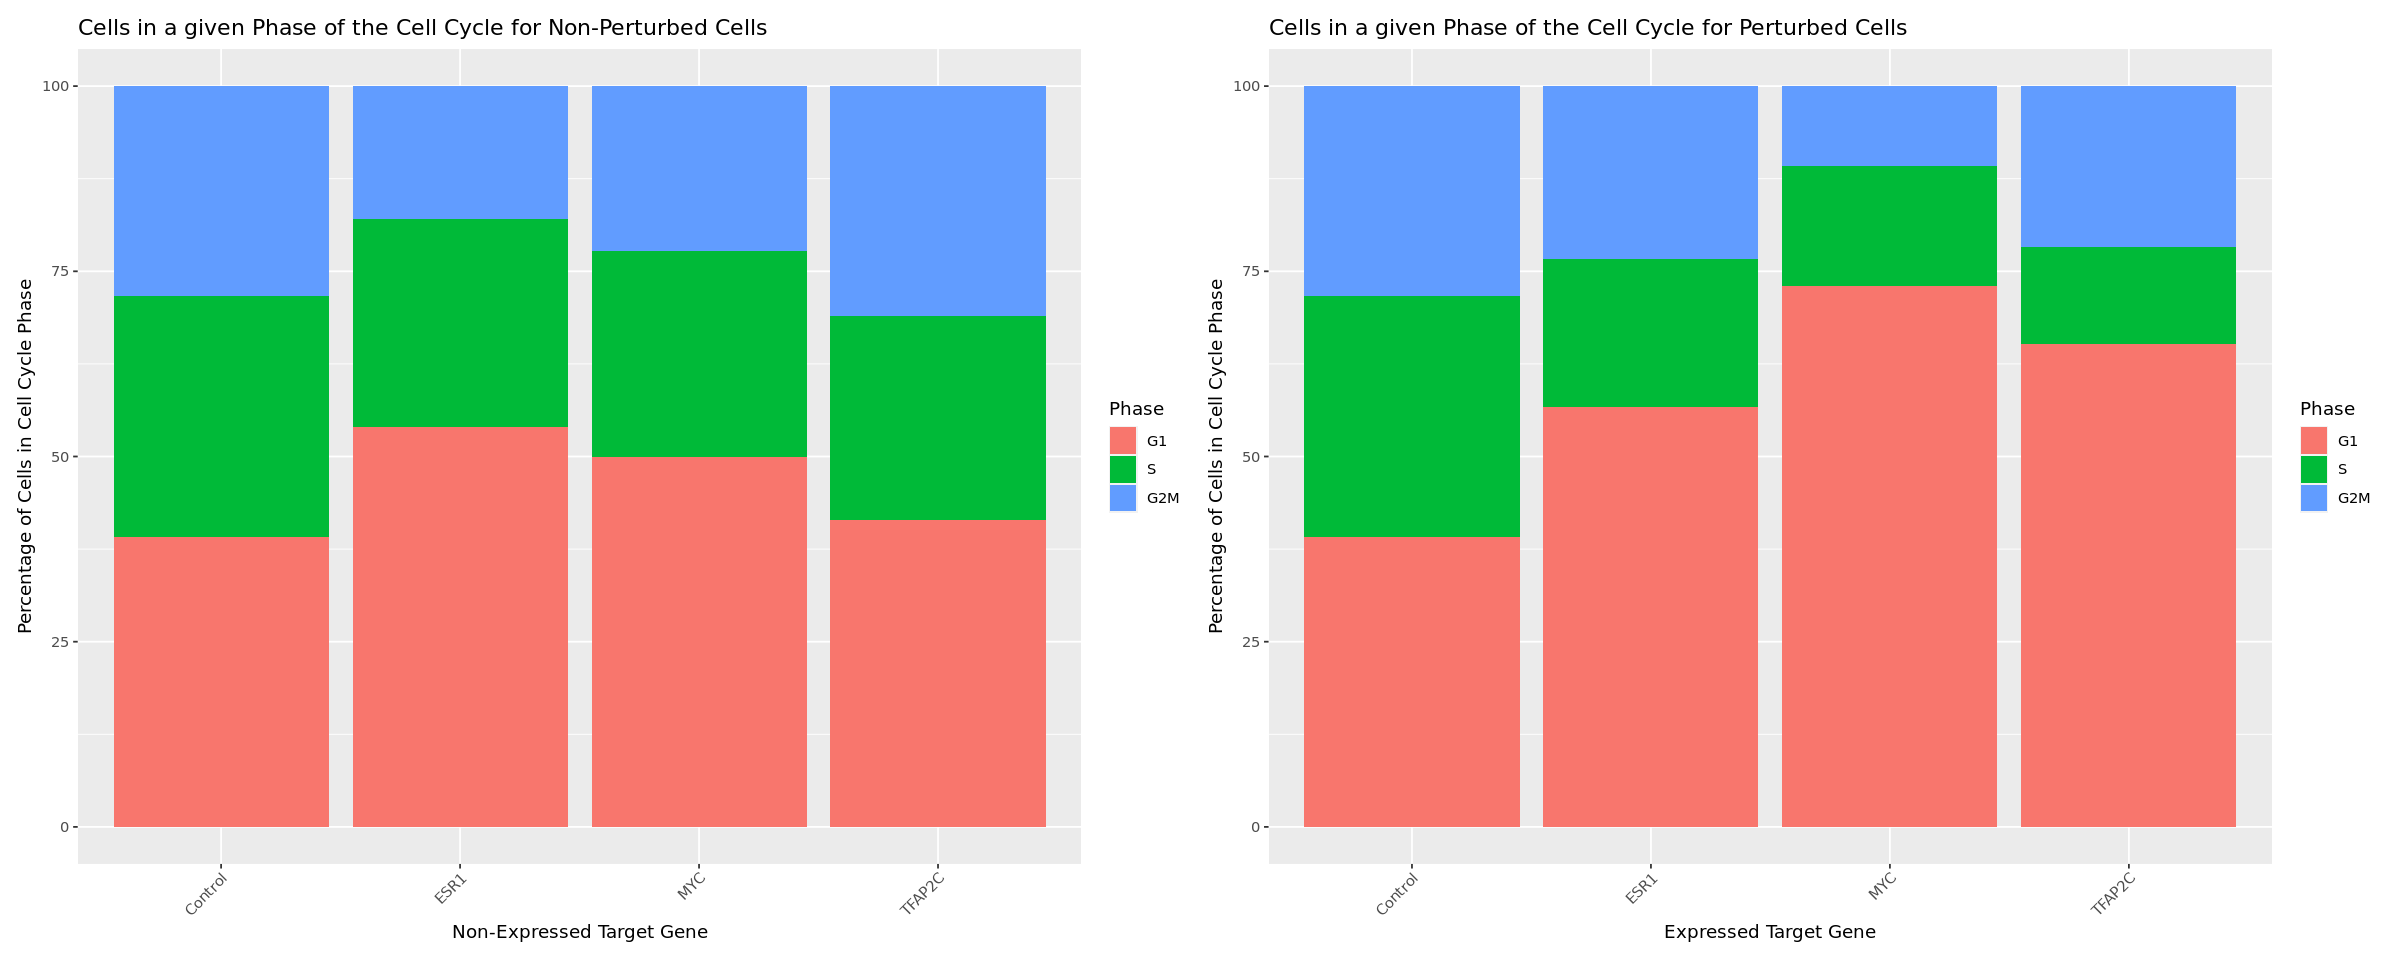

In [87]:
options(repr.plot.width=20, repr.plot.height=8)
ko_genes = c('Control', as.character(unique(yuza_cell_cycle[yuza_cell_cycle$global_mixscape == 'KO', ]$gene)))
yuza_cell_cycle$gene_order = factor(yuza_cell_cycle$gene, levels=ko_genes, labels=ko_genes)

c1 = yuza_cell_cycle %>%
          filter(!is.na(gene_order)) %>%
          filter((gene %in% expr_genes | gene == 'Control') & (gene != 'GATA3')) %>% 
          filter(global_mixscape == 'NP') %>%
          ggplot(aes(x=gene_order, y=percentage, fill=Phase)) +
          geom_col(position = position_stack(reverse = TRUE)) +
          theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
          labs(y='Percentage of Cells in Cell Cycle Phase', x='Non-Expressed Target Gene',
               title='Cells in a given Phase of the Cell Cycle for Non-Perturbed Cells', colour='Cell Cycle Phase')

c2 = yuza_cell_cycle %>%
          filter(!is.na(gene_order)) %>%
          filter((gene %in% expr_genes | gene == 'Control' & !is.na(gene)) & (gene != 'GATA3')) %>% 
          filter(global_mixscape == 'KO' | gene == 'Control') %>%
          ggplot(aes(x=gene_order, y=percentage, fill=Phase)) +
          geom_col(position = position_stack(reverse = TRUE)) +
          theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
          labs(y='Percentage of Cells in Cell Cycle Phase', x='Expressed Target Gene',
               title='Cells in a given Phase of the Cell Cycle for Perturbed Cells', colour='Cell Cycle Phase')

c1 | c2

## Percentage of Cells in Phases of Cell Cycle for Expressed Target Genes - Enlarged

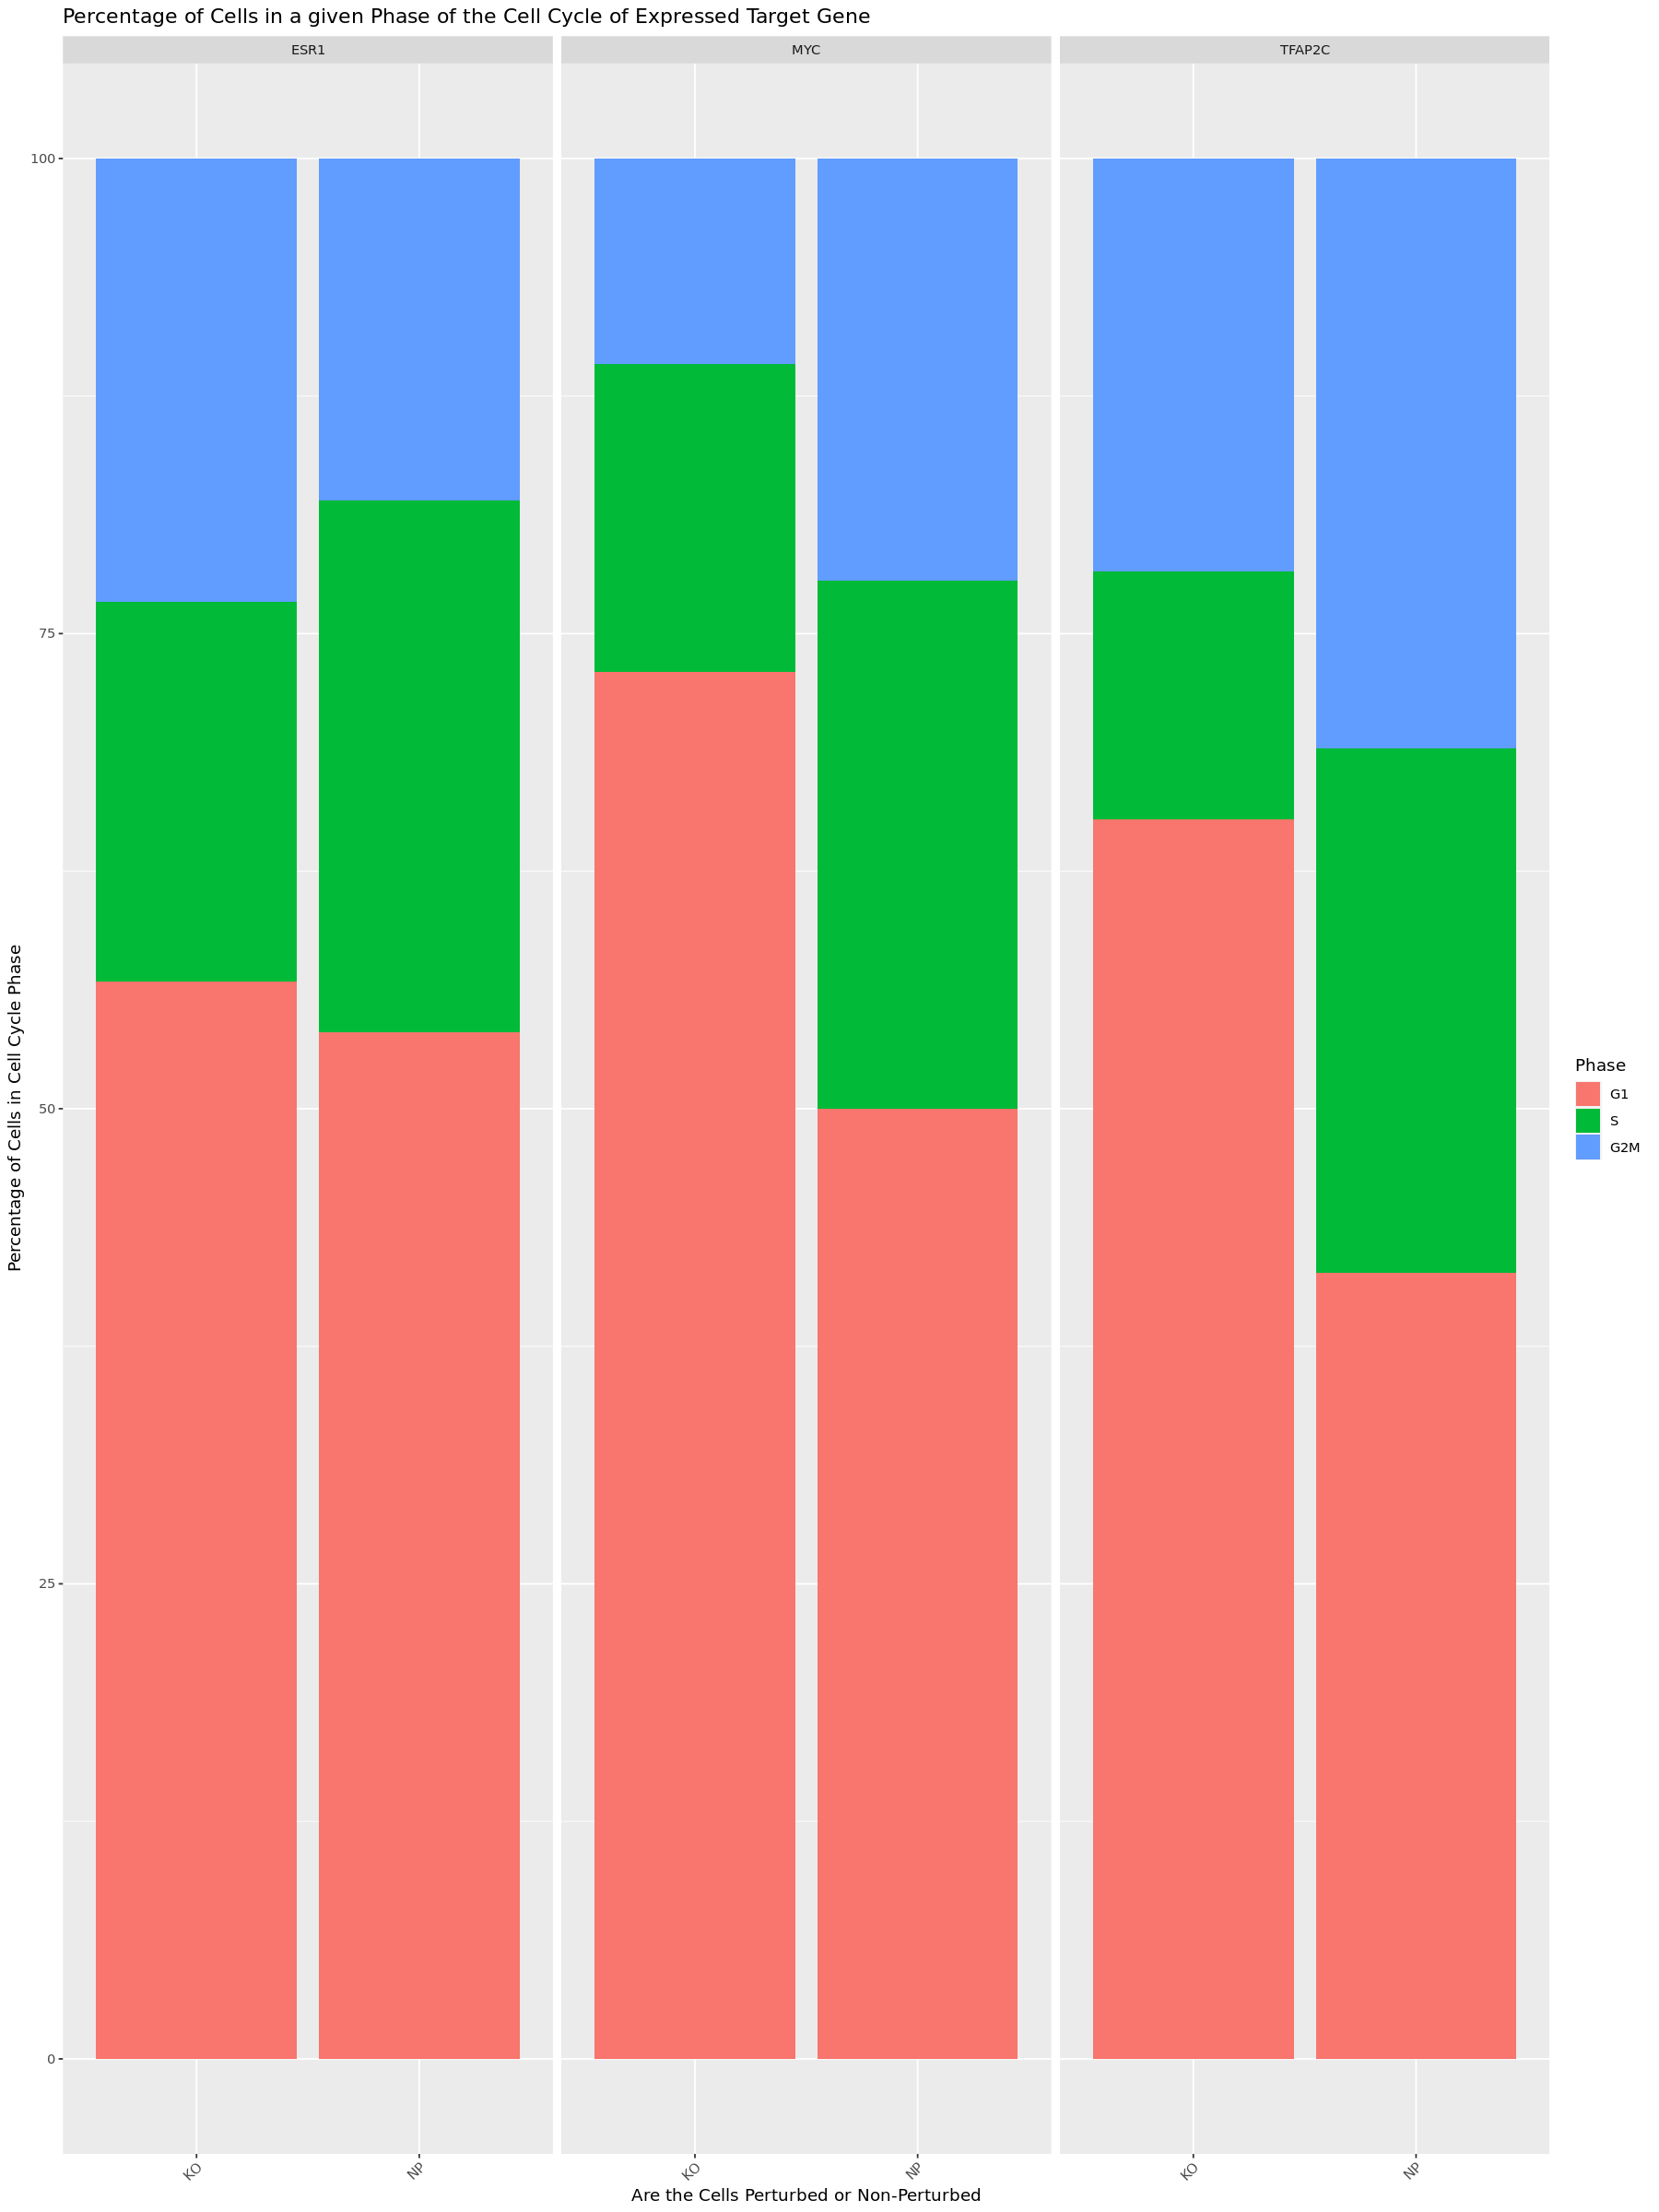

In [88]:
# plotting the percentage of cells in a given phase of the cell cycle on a given target gene
options(repr.plot.width=15, repr.plot.height=20)

yuza_cell_cycle %>%
  filter(!is.na(gene_order) & (gene != 'GATA3')) %>%
  filter(gene %in% expr_genes) %>% 
  ggplot(aes(x=global_mixscape, y=percentage, fill=Phase)) +
    geom_col(position = position_stack(reverse = TRUE)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(y='Percentage of Cells in Cell Cycle Phase', x='Are the Cells Perturbed or Non-Perturbed',
         title='Percentage of Cells in a given Phase of the Cell Cycle of Expressed Target Gene', 
         colour='Cell Cycle Phase') +
   facet_wrap(~gene_order) 

## Assessing the Correlation between Log Fold Change of G1 in Cells versus Dropout

In [89]:
ko_g1 = yuza_cell_cycle %>% dplyr::filter((Phase == 'G1') & (global_mixscape == 'KO' | gene == ctrl_label))
carroll = carroll %>% dplyr::filter(gene_name %in% ko_g1$gene)
carroll$gene = carroll$gene_name


# Calculating the Log Fold Change of the Percentage Cells in G1 Phase of the Cell Cycle
ko_g1$log2 = log2(ko_g1$percentage)
ctrl_log2 = ko_g1[ko_g1$gene == 'Control', ]$log2
ko_g1$g1_fold_change = ko_g1$log2 - ctrl_log2

lcf_d3 = left_join(carroll[,c('gene', 'D7_Vs_D3','D9_Vs_D3','D12_Vs_D3','D15_Vs_D3','D20_Vs_D3')],
                         ko_g1[, c('gene', 'g1_fold_change')],
                         by='gene')

lcf_d7 = left_join(carroll[,c('gene', 'D9_Vs_D7','D12_Vs_D7','D15_Vs_D7','D20_Vs_D7')],
                         ko_g1[, c('gene', 'g1_fold_change')],
                         by='gene')

In [90]:
# comparing d3 vs g1 log fold change
lfc1_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D7_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc2_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D9_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc3_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D12_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc4_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D15_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc5_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D20_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))

# comparing d7 vs g1 log fold change
lfc1_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D9_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc2_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D12_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc3_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D15_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc4_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D20_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))

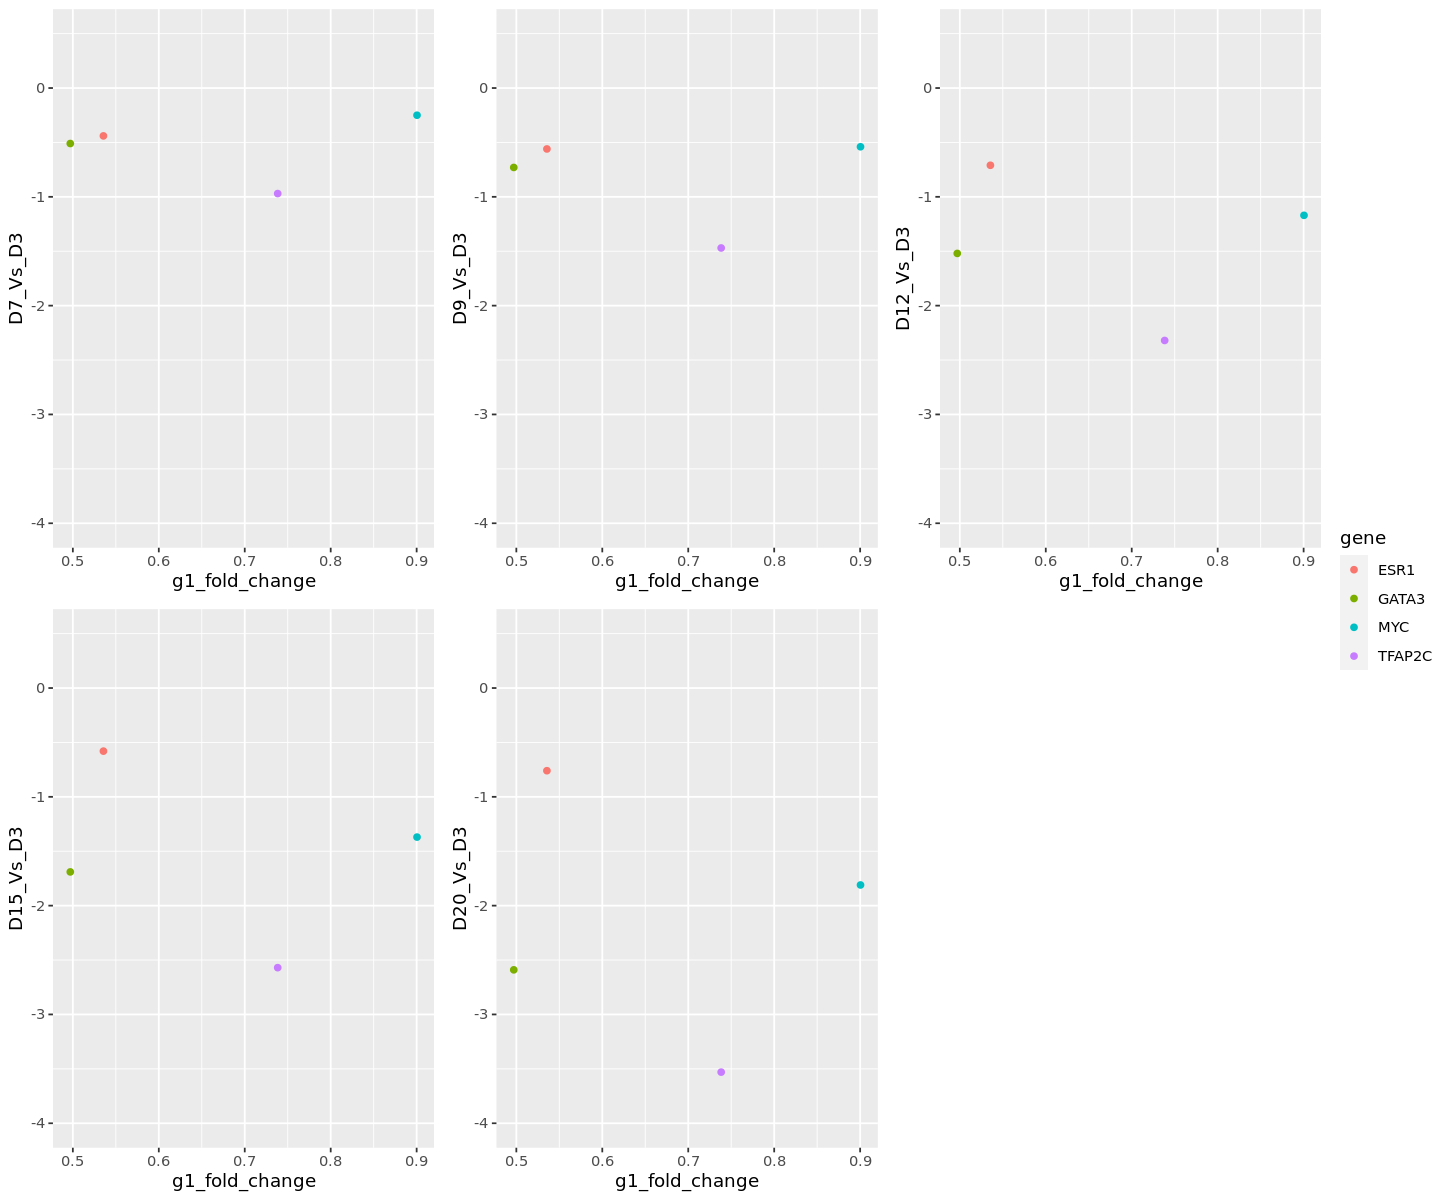

In [91]:
options(repr.plot.width=12, repr.plot.height=10)
ggarrange(lfc1_d3, lfc2_d3, lfc3_d3, lfc4_d3, lfc5_d3, ncol=3, nrow=2, common.legend = TRUE, legend="right")

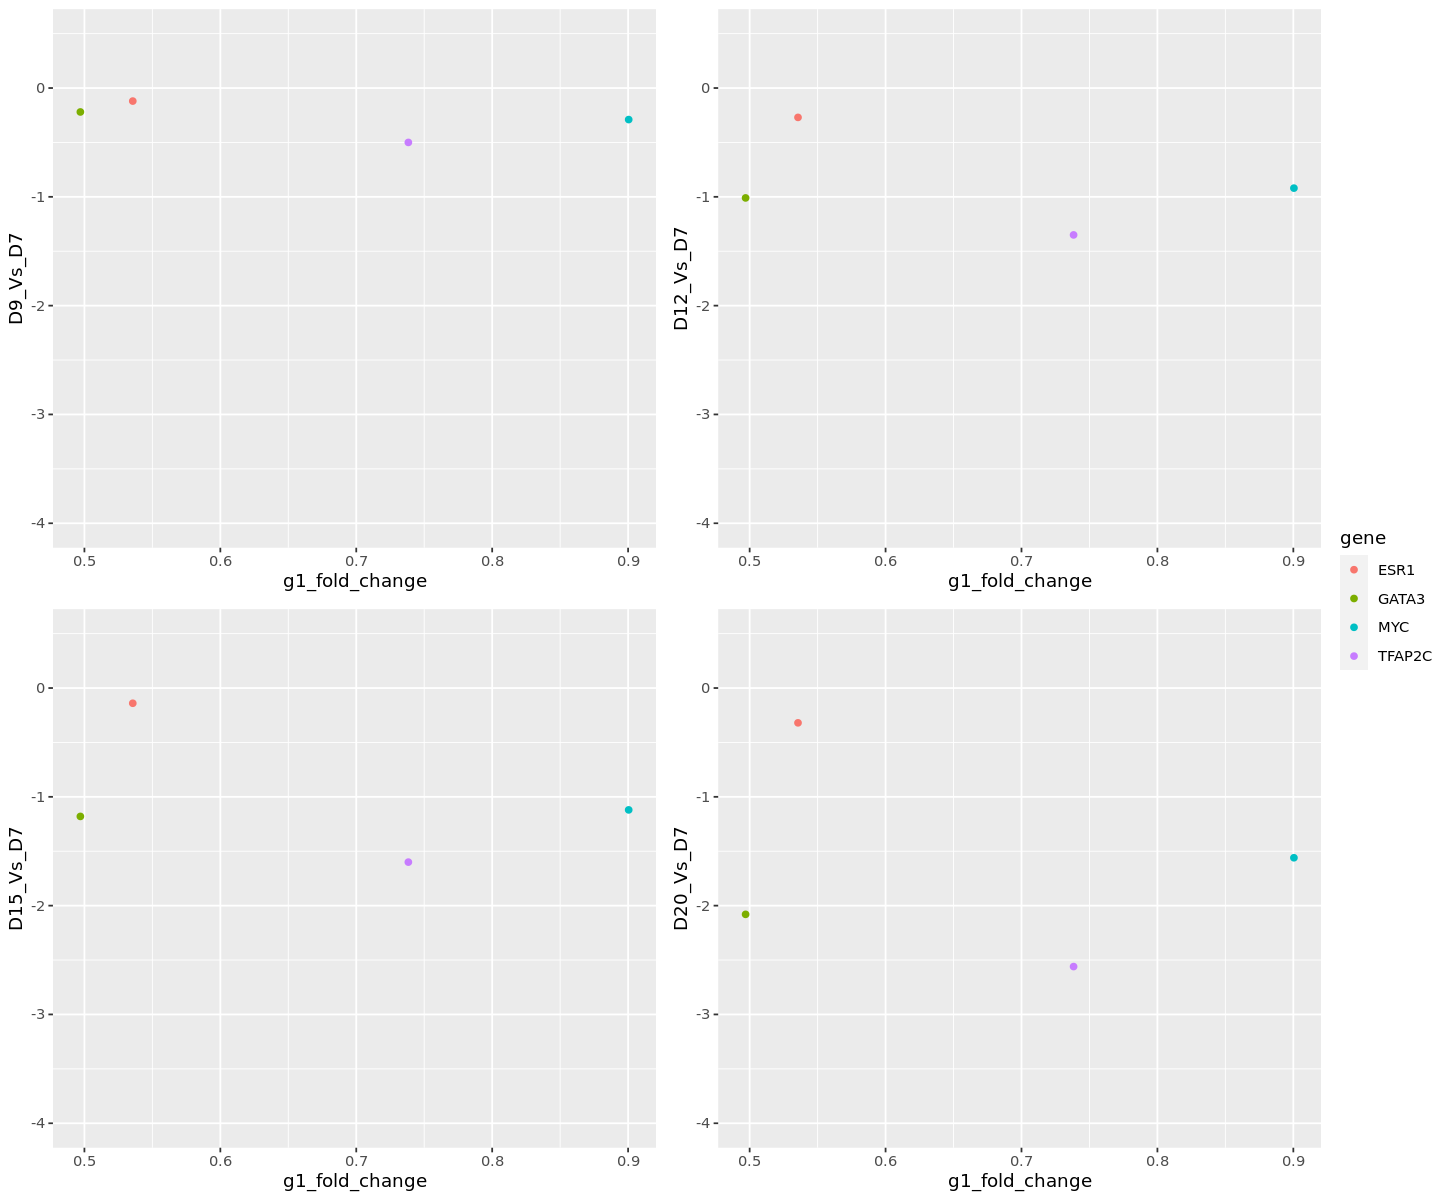

In [92]:
options(repr.plot.width=12, repr.plot.height=10)
ggarrange(lfc1_d7, lfc2_d7, lfc3_d7, lfc4_d7, ncol=2, nrow=2, common.legend = TRUE, legend="right")

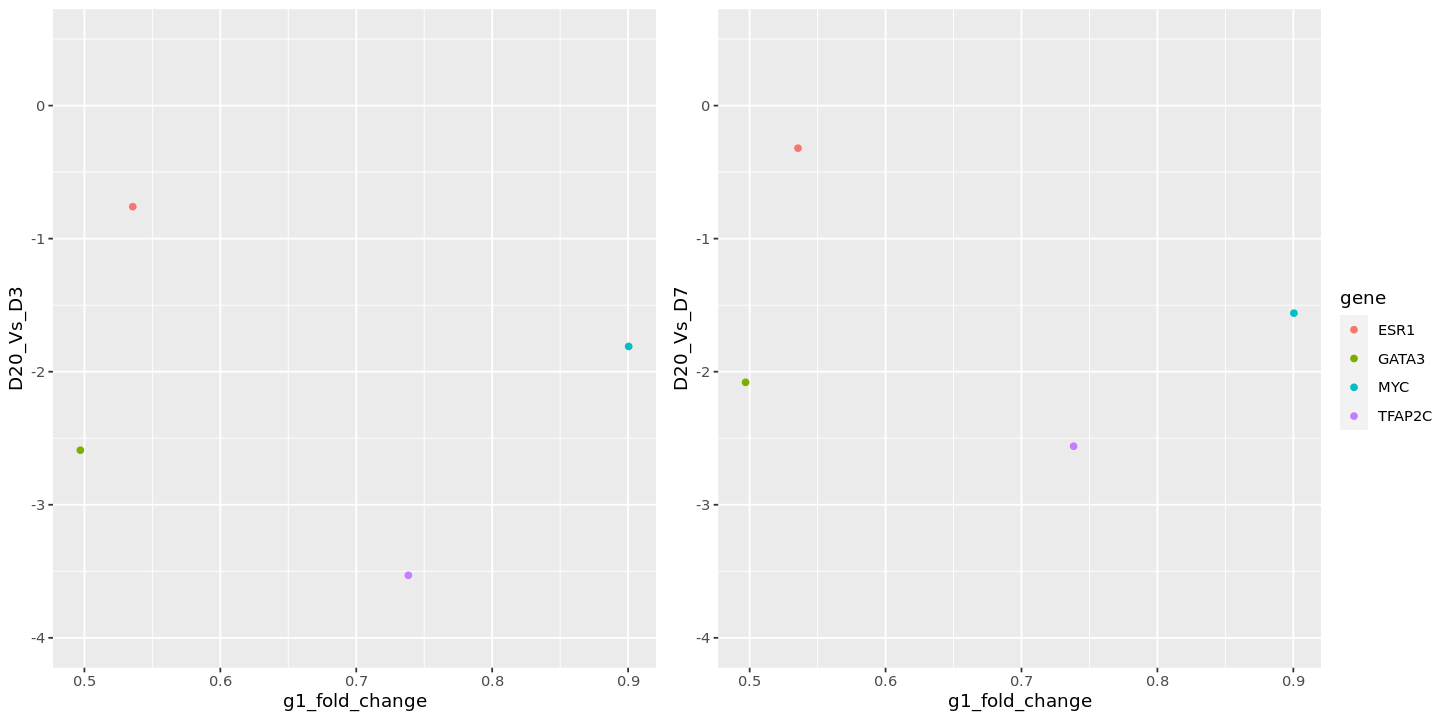

In [93]:
options(repr.plot.width=12, repr.plot.height=6)
ggarrange(lfc5_d3, lfc4_d7, ncol=2, nrow=1, common.legend = TRUE, legend="right")

# Comparing Percentage of MT-Genes Distributions between Target Genes

Here were comparing the Percentages of MT-Genes Across Control, Non-Perturbed, and Perturbed Cells for both expressed and non-expressed target genes. Where interested to observe if there are any differences between distribtions of % of MT-Genes between perturbed and non-perturbed cells for a given target gene. It's important to note that all comparisons are in relation to the control cells % of MT-Genes distribution.

**Observations**
I've observed some interesting shifts in the % of MT-Genes in ESR1 and FOXA1 (possibly other target genes are maybe of interest as well).

## Non-Expressed Target Genes % of MT Distribution

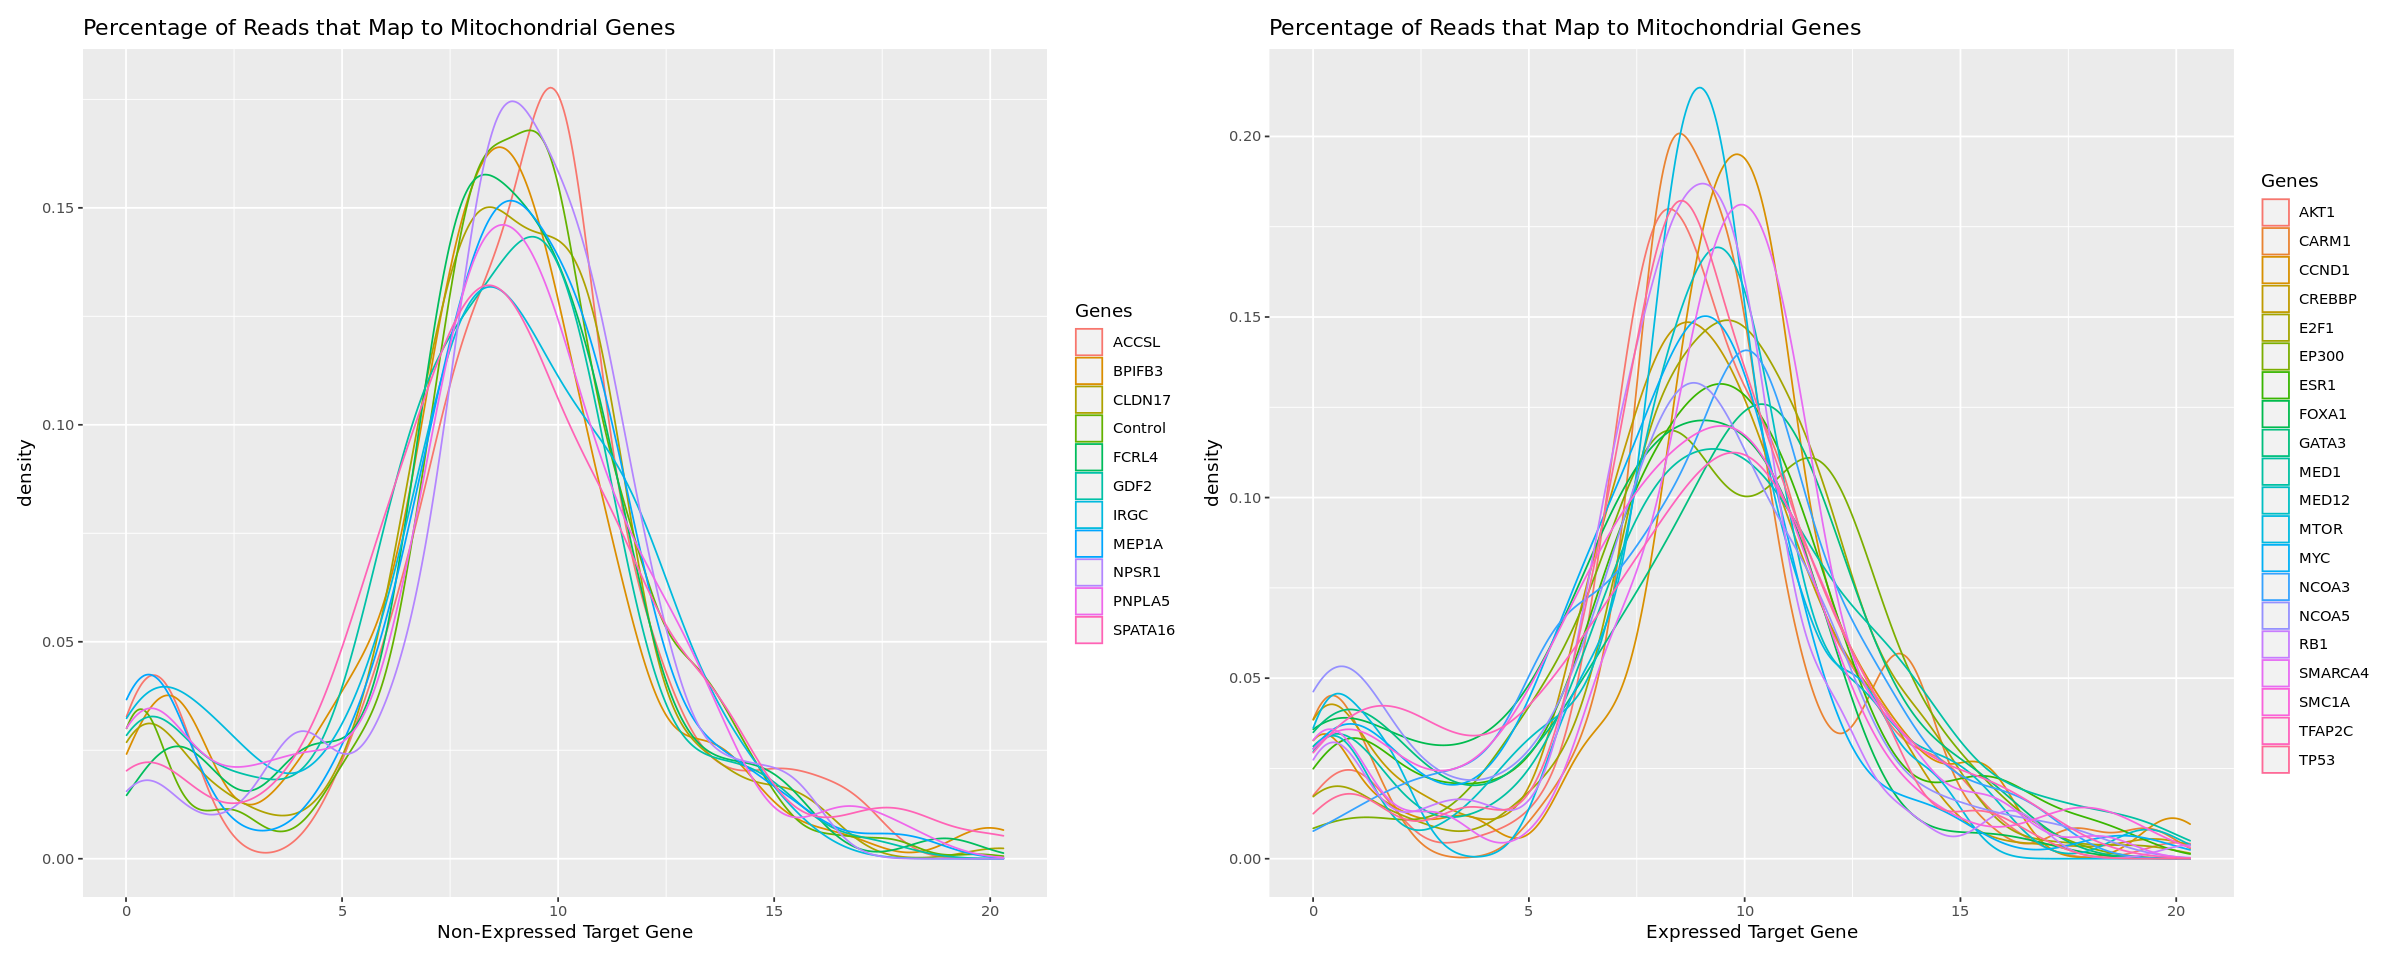

In [94]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=20, repr.plot.height=8)

m1 = yuza %>% 
          filter(gene %in% non_expr_genes) %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Non-Expressed Target Gene', title='Percentage of Reads that Map to Mitochondrial Genes', colour='Genes')


m2 = yuza %>% 
          filter(gene %in% expr_genes) %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Expressed Target Gene', title='Percentage of Reads that Map to Mitochondrial Genes', colour='Genes')


m1 | m2

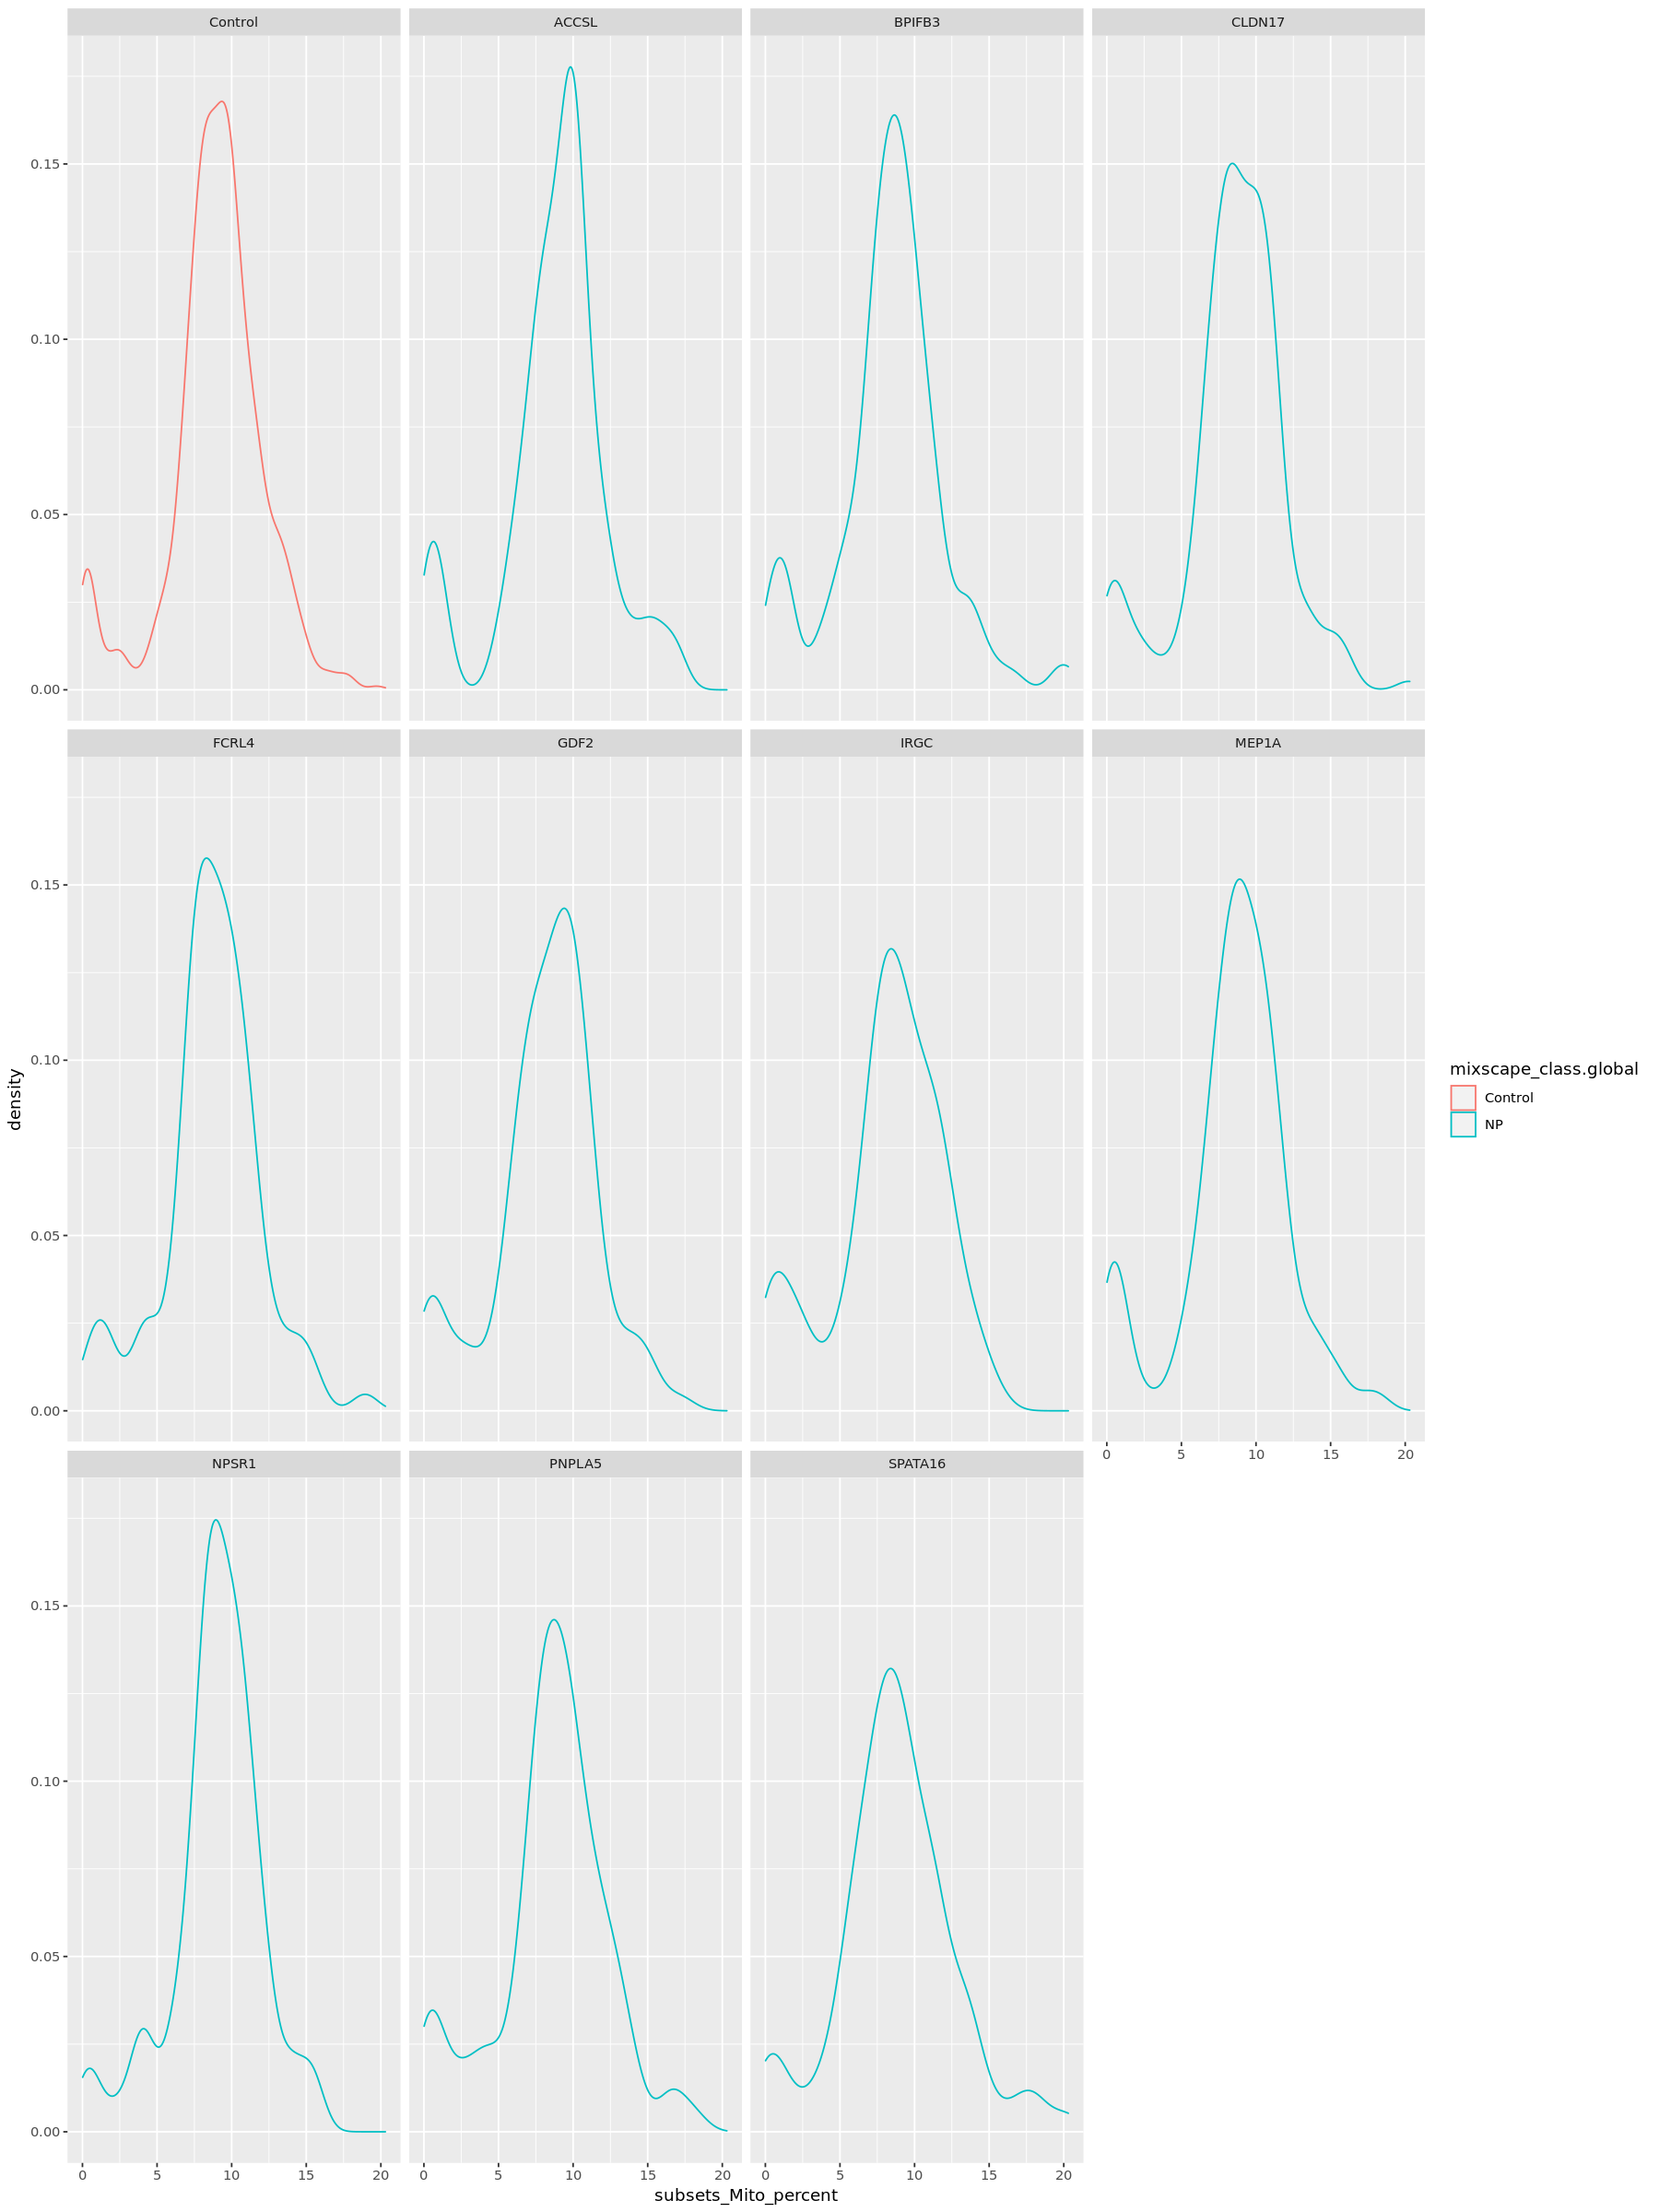

In [95]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=15, repr.plot.height=20)

yuza %>% 
  filter(gene %in% non_expr_genes) %>%
  ggplot(aes(subsets_Mito_percent, color=mixscape_class.global)) +
    geom_density() +
    facet_wrap(~gene_order)

## Mitochondria Percentage Distribution of Target Genes

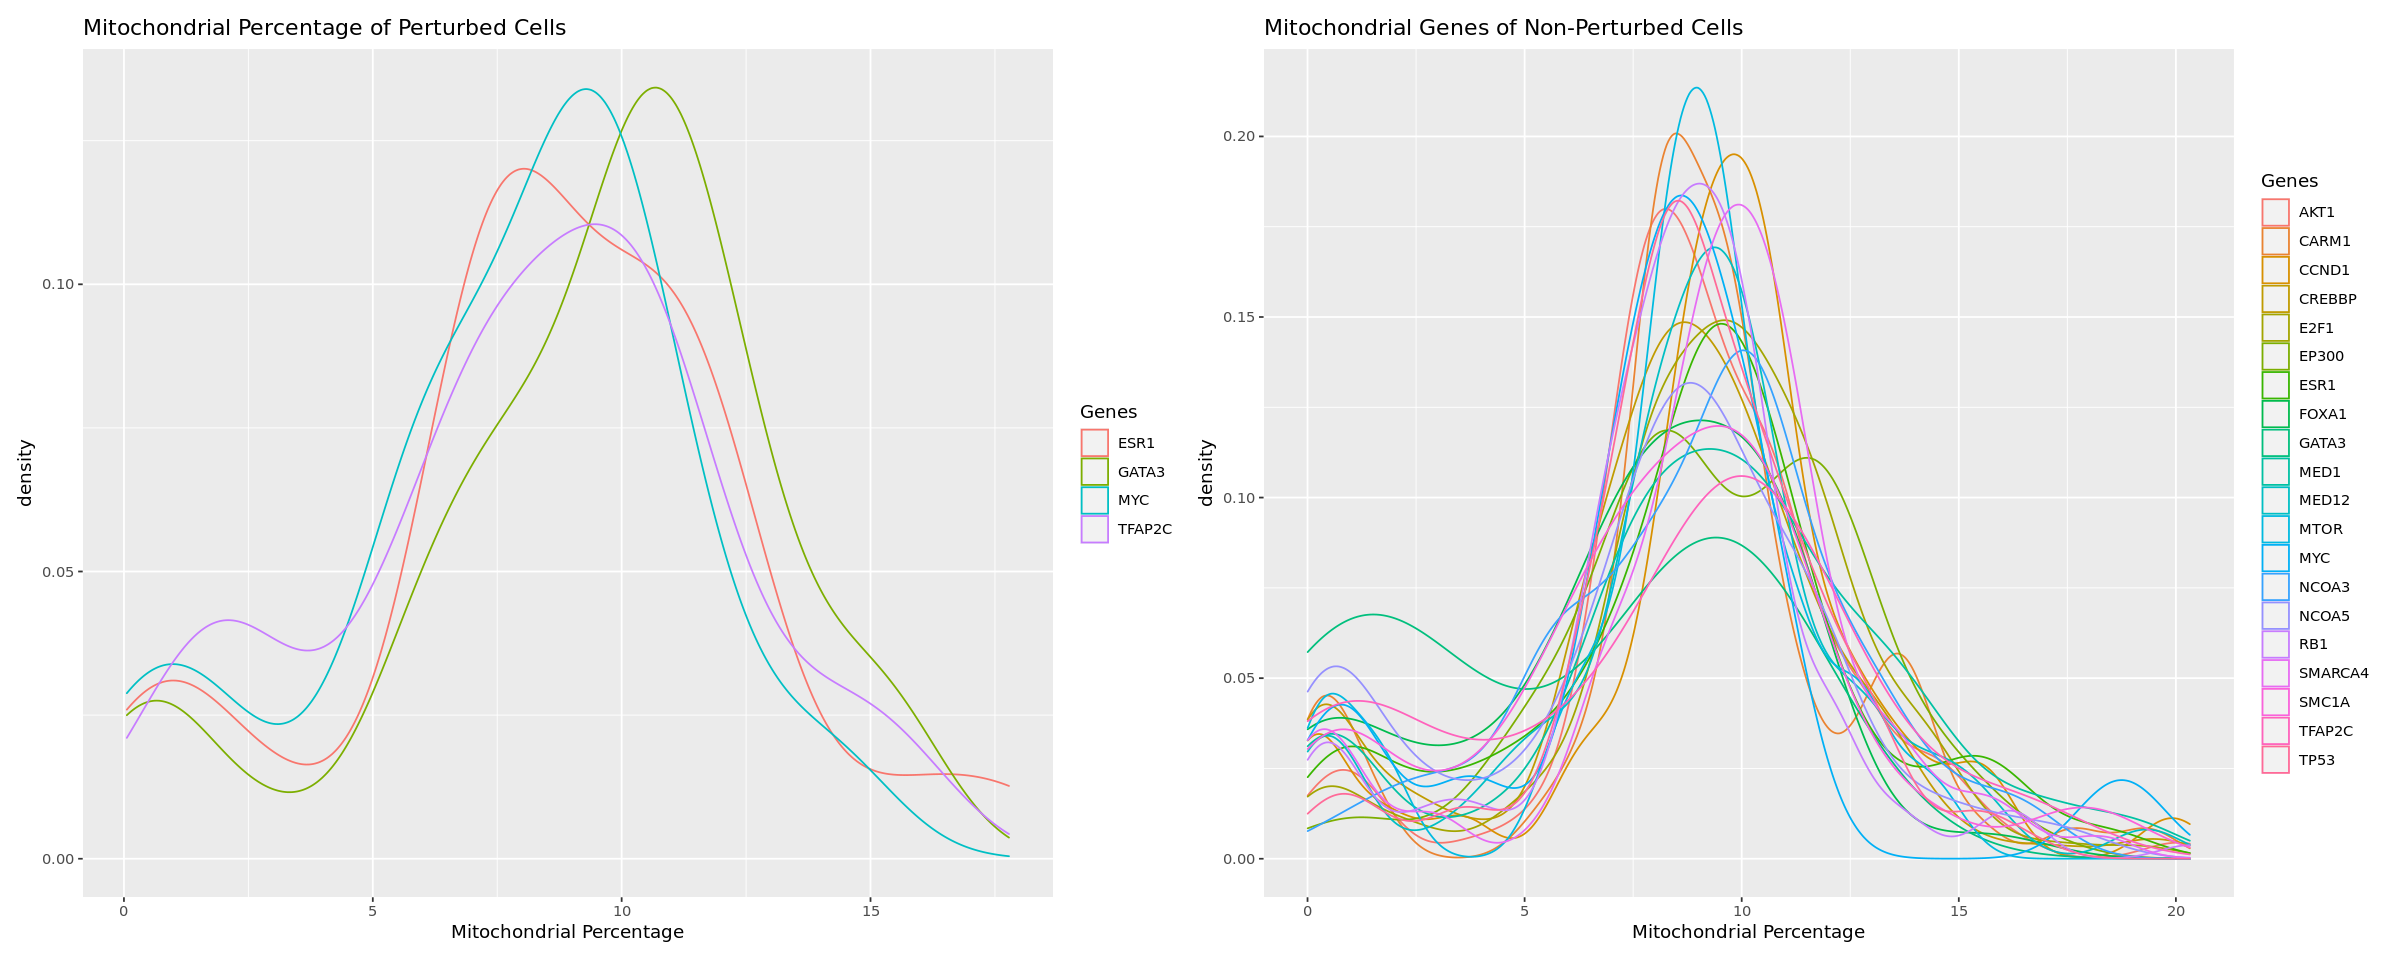

In [96]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=20, repr.plot.height=8)

m1 = yuza %>% 
          filter(gene %in% expr_genes) %>%
          filter(mixscape_class.global != 'NP') %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Mitochondrial Percentage', title='Mitochondrial Percentage of Perturbed Cells', colour='Genes')
  
m2 = yuza %>% 
          filter(gene %in% expr_genes) %>%
          filter(mixscape_class.global != 'KO') %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Mitochondrial Percentage', title='Mitochondrial Genes of Non-Perturbed Cells', colour='Genes')

m1 | m2

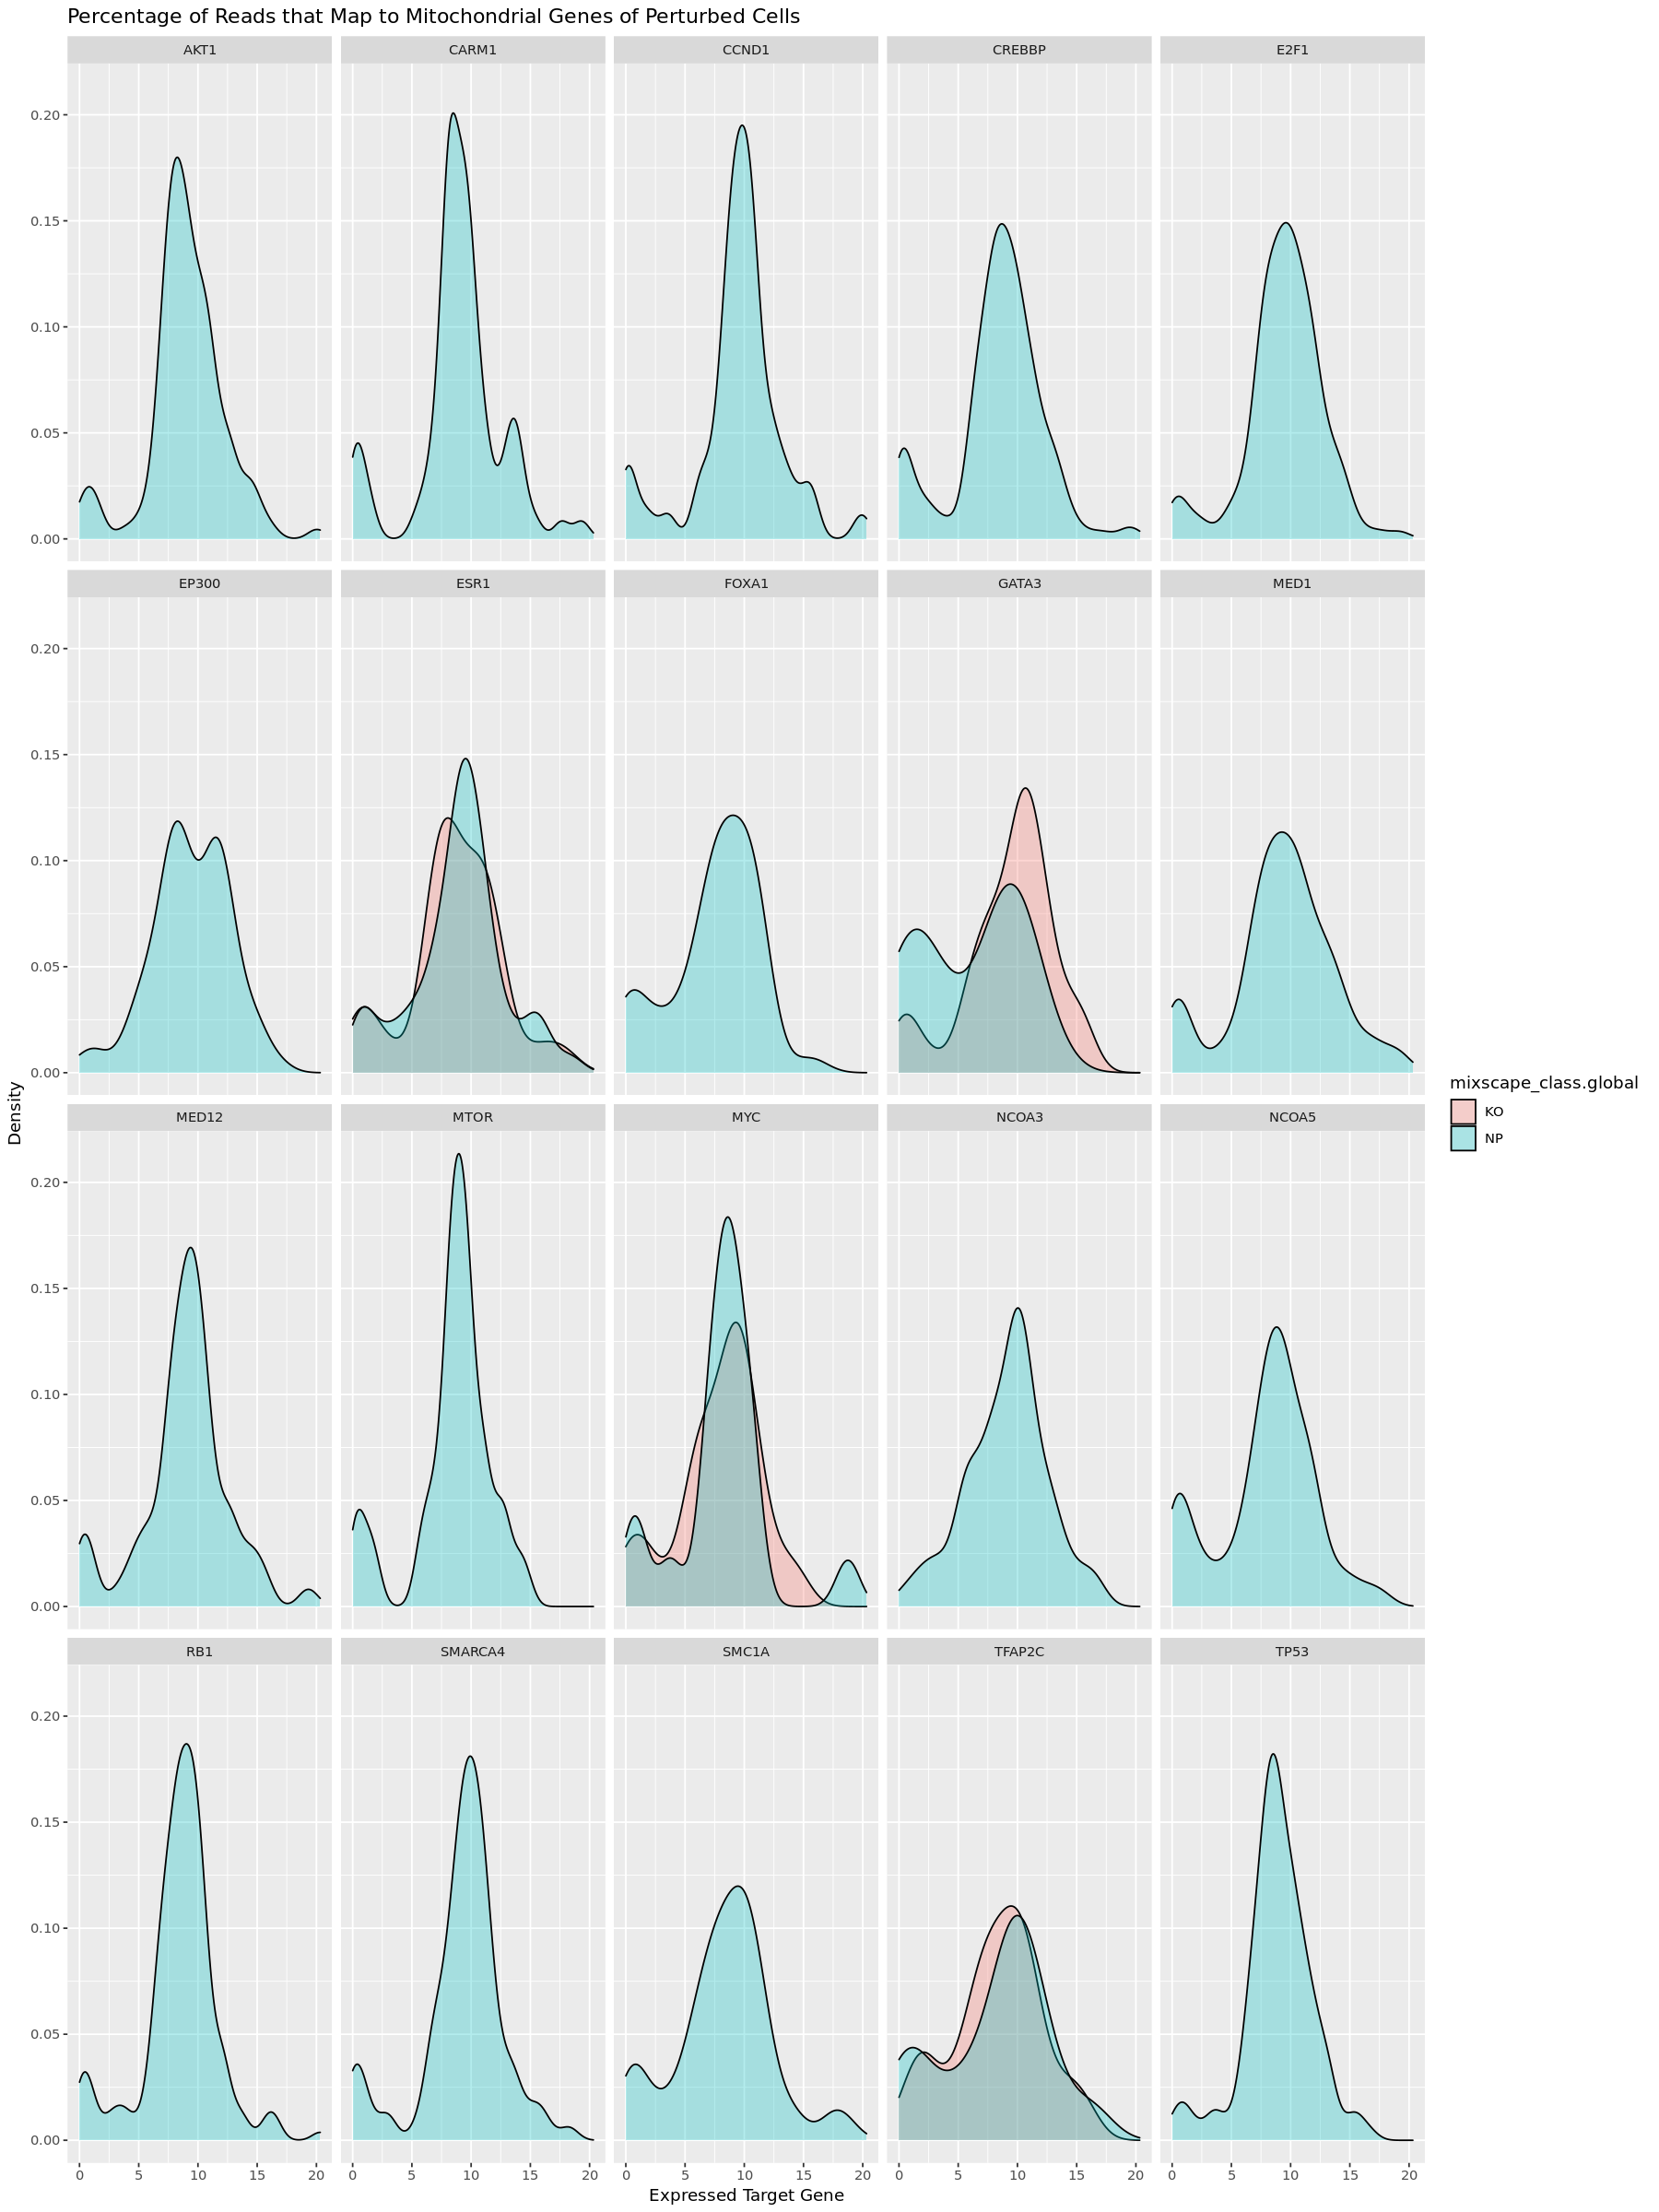

In [97]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=15, repr.plot.height=20)

yuza %>% 
  filter(gene %in% expr_genes) %>%
  ggplot(aes(subsets_Mito_percent, fill=mixscape_class.global)) +
    geom_density(alpha = 0.3) +
    labs(x='Expressed Target Gene', y='Density', title='Percentage of Reads that Map to Mitochondrial Genes of Perturbed Cells', 
         colour='Perturbation Status') +
    facet_wrap(~gene_order)

## Knock Out Efficiency of gRNA Library

In [98]:
yuza_gene_ko = calc_gene_ko(yuza)
yuza_grna_ko = calc_grna_ko(yuza)

`summarise()` has grouped output by 'library', 'gene'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'library', 'gene', 'grna_name'. You can
override using the `.groups` argument.


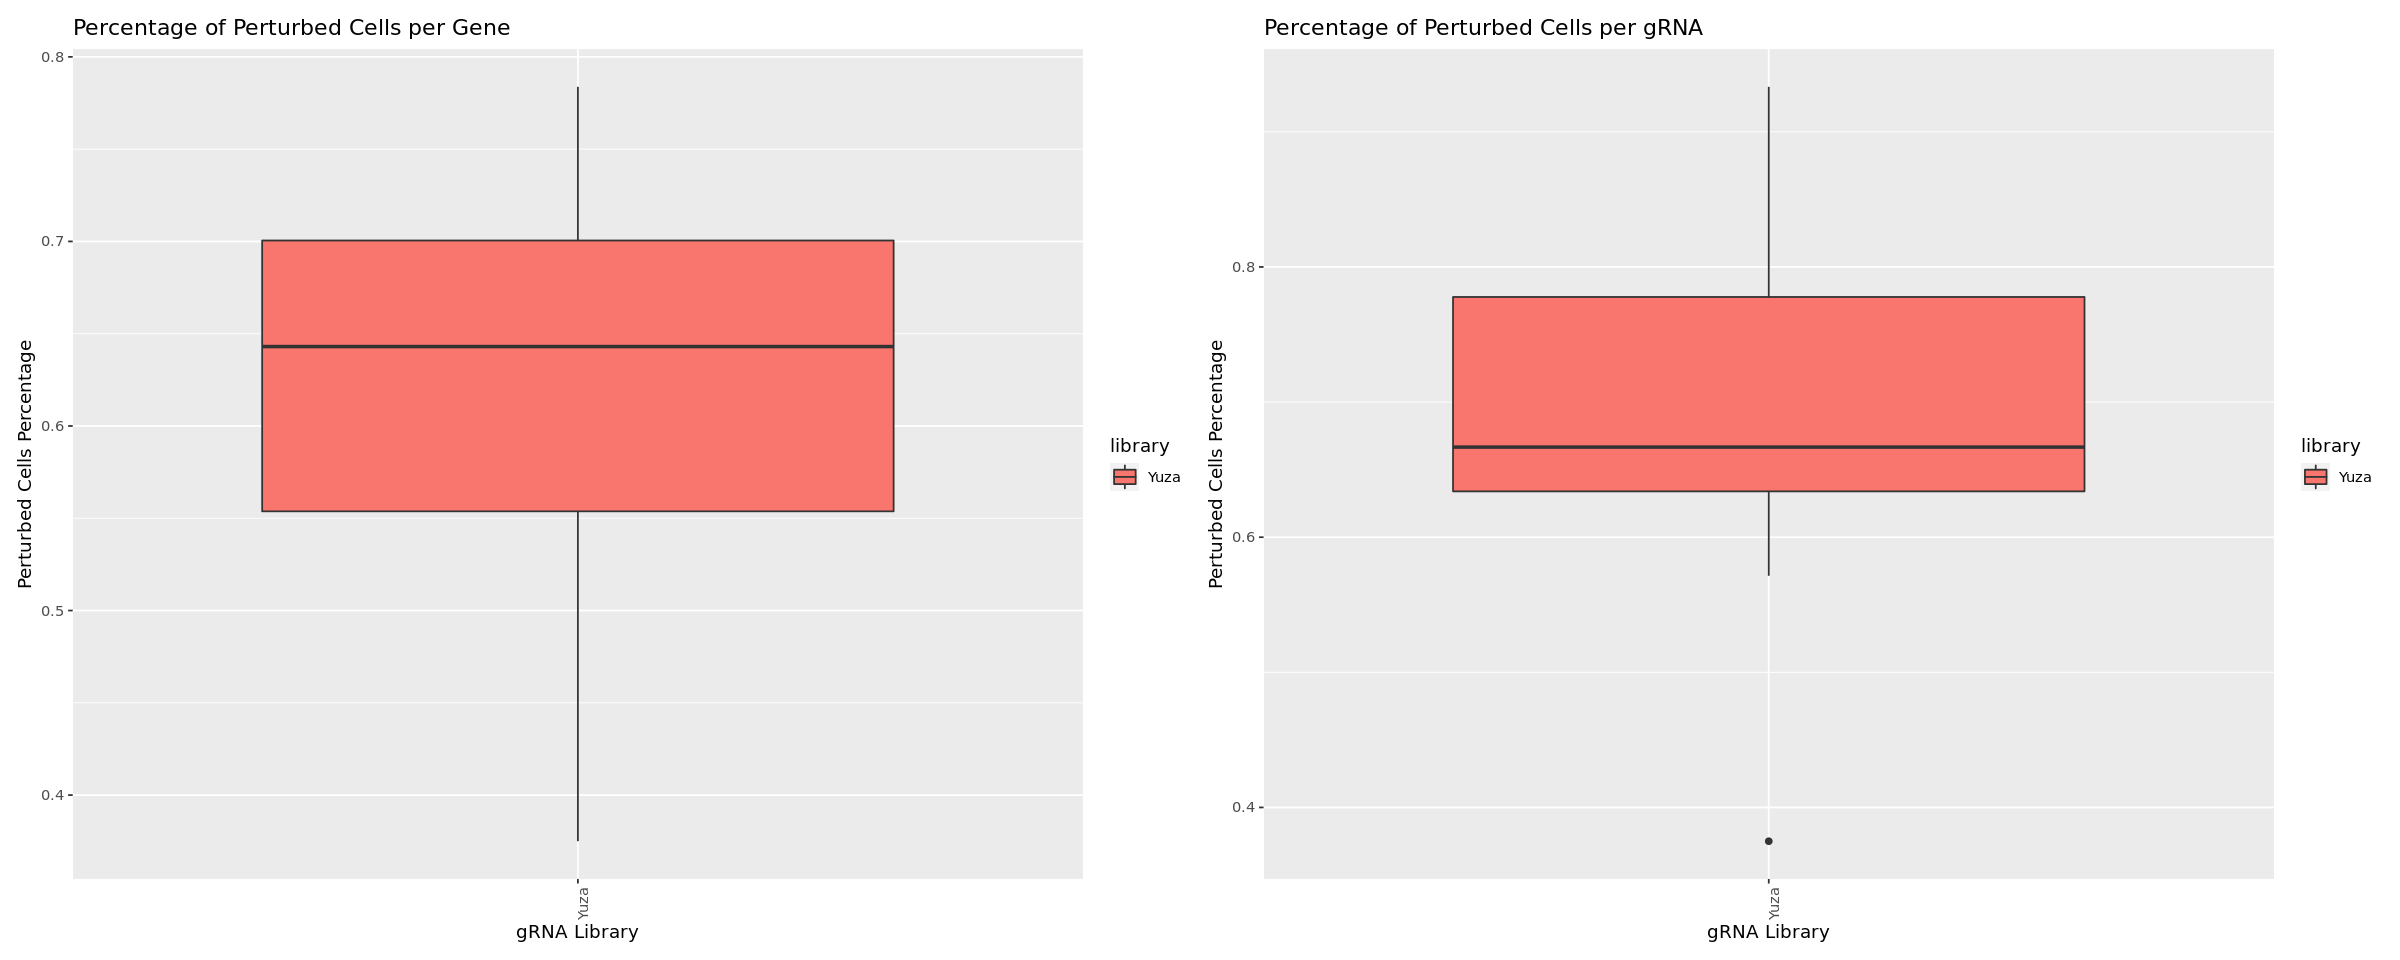

In [99]:
yuza_gene_plot = yuza_gene_ko %>%
                  group_by(library, gene) %>%
                  ggplot(aes(x=library, y=perc, fill=library)) +
                    geom_boxplot() +
                    labs(x='gRNA Library', y='Perturbed Cells Percentage',
                         title='Percentage of Perturbed Cells per Gene') +
                    theme(axis.text.x = element_text(angle = 90, hjust = 1))

yuza_grna_plot = yuza_grna_ko %>%
                  group_by(library, grna_name) %>%
                  ggplot(aes(x=library, y=perc, fill=library)) +
                    geom_boxplot() +
                    labs(x='gRNA Library', y='Perturbed Cells Percentage',
                         title='Percentage of Perturbed Cells per gRNA') +
                    theme(axis.text.x = element_text(angle = 90, hjust = 1))

options(repr.plot.width=20, repr.plot.height=8)
yuza_gene_plot | yuza_grna_plot

# Analysis of Edwards Library

## Exploring the Percentage of Cells in a Cell Cycle for a Given Target Gene

Comparing the percentage of Cells in the Cell Cycle for a given Target Genes. This always use to observe potiential changes in the number of cells in a given phase of the cell cycle between Perturbed and Non-Perturbed Cells. Additionally, the i plotted the percentage of cells in a given phase of cell cycle for control cells. General Observation I have is that most perturbed cells regardless of target genes tend to have more cells in the G1 phase of the Cell Cycle.

### Creating Merged and Non-Merged Perturbed Cell Metadata

In [100]:
# Calculating percentage of cells in each phase of the cell cycle
edwards_cell_cycle = calc_cell_cycle_perc(edwards)

# extract non expressed and expressed target genes as separate vectors
expr_genes = rownames(Edwards_gene_metadata[Edwards_gene_metadata$Category != 'Unknown', ])
non_expr_genes = rownames(Edwards_gene_metadata[Edwards_gene_metadata$Category == 'Unknown', ])

# adding controls to these vectors. This allows me to select which gene set i want to visualize
expr_genes = c(expr_genes, ctrl_label)
non_expr_genes = c(non_expr_genes, ctrl_label)

# reorder genes so control at the start of the figures
genes_order = c(ctrl_label, as.character(unique(edwards_cell_cycle$gene[edwards_cell_cycle$gene != ctrl_label])))

edwards_cell_cycle$gene_order = factor(edwards_cell_cycle$gene, levels=genes_order, labels=genes_order)
edwards_cell_cycle$Phase = factor(edwards_cell_cycle$Phase, levels=c("G1", "S", "G2M"), labels=c("G1", "S", "G2M"))
edwards$gene_order = factor(edwards$gene, levels=genes_order, labels=genes_order)

## Percentage of Cells in Phases of Cell Cycle for Non Expressed Target Genes

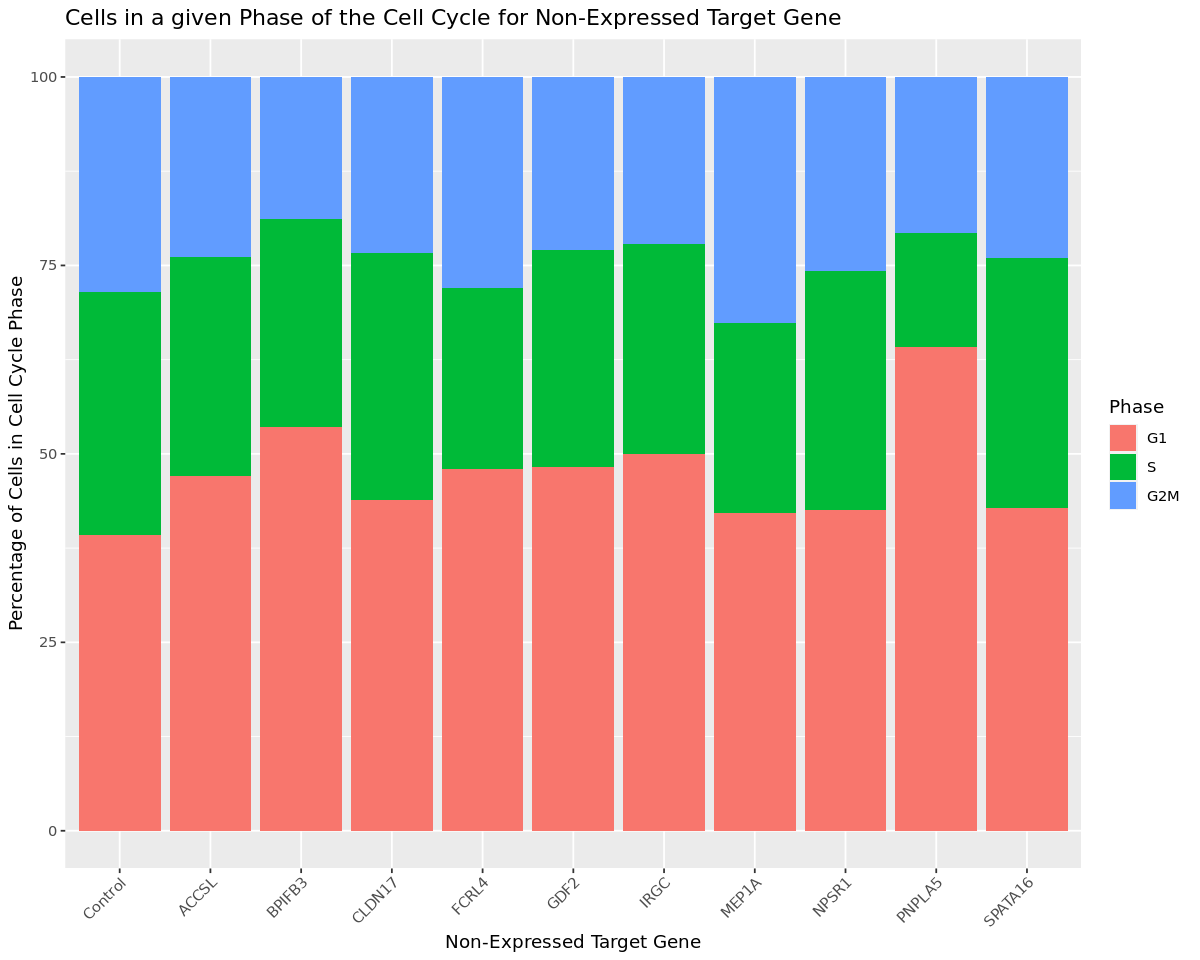

In [101]:
options(repr.plot.width=10, repr.plot.height=8)
edwards_cell_cycle %>%
  filter(gene %in% non_expr_genes) %>%
  ggplot(aes(x=gene_order, y=percentage, fill=Phase)) +
    geom_col(position = position_stack(reverse = TRUE)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(y='Percentage of Cells in Cell Cycle Phase', x='Non-Expressed Target Gene',
         title='Cells in a given Phase of the Cell Cycle for Non-Expressed Target Gene')

## Percentage of Cells in Phases of Cell Cycle for Expressed Target Genes

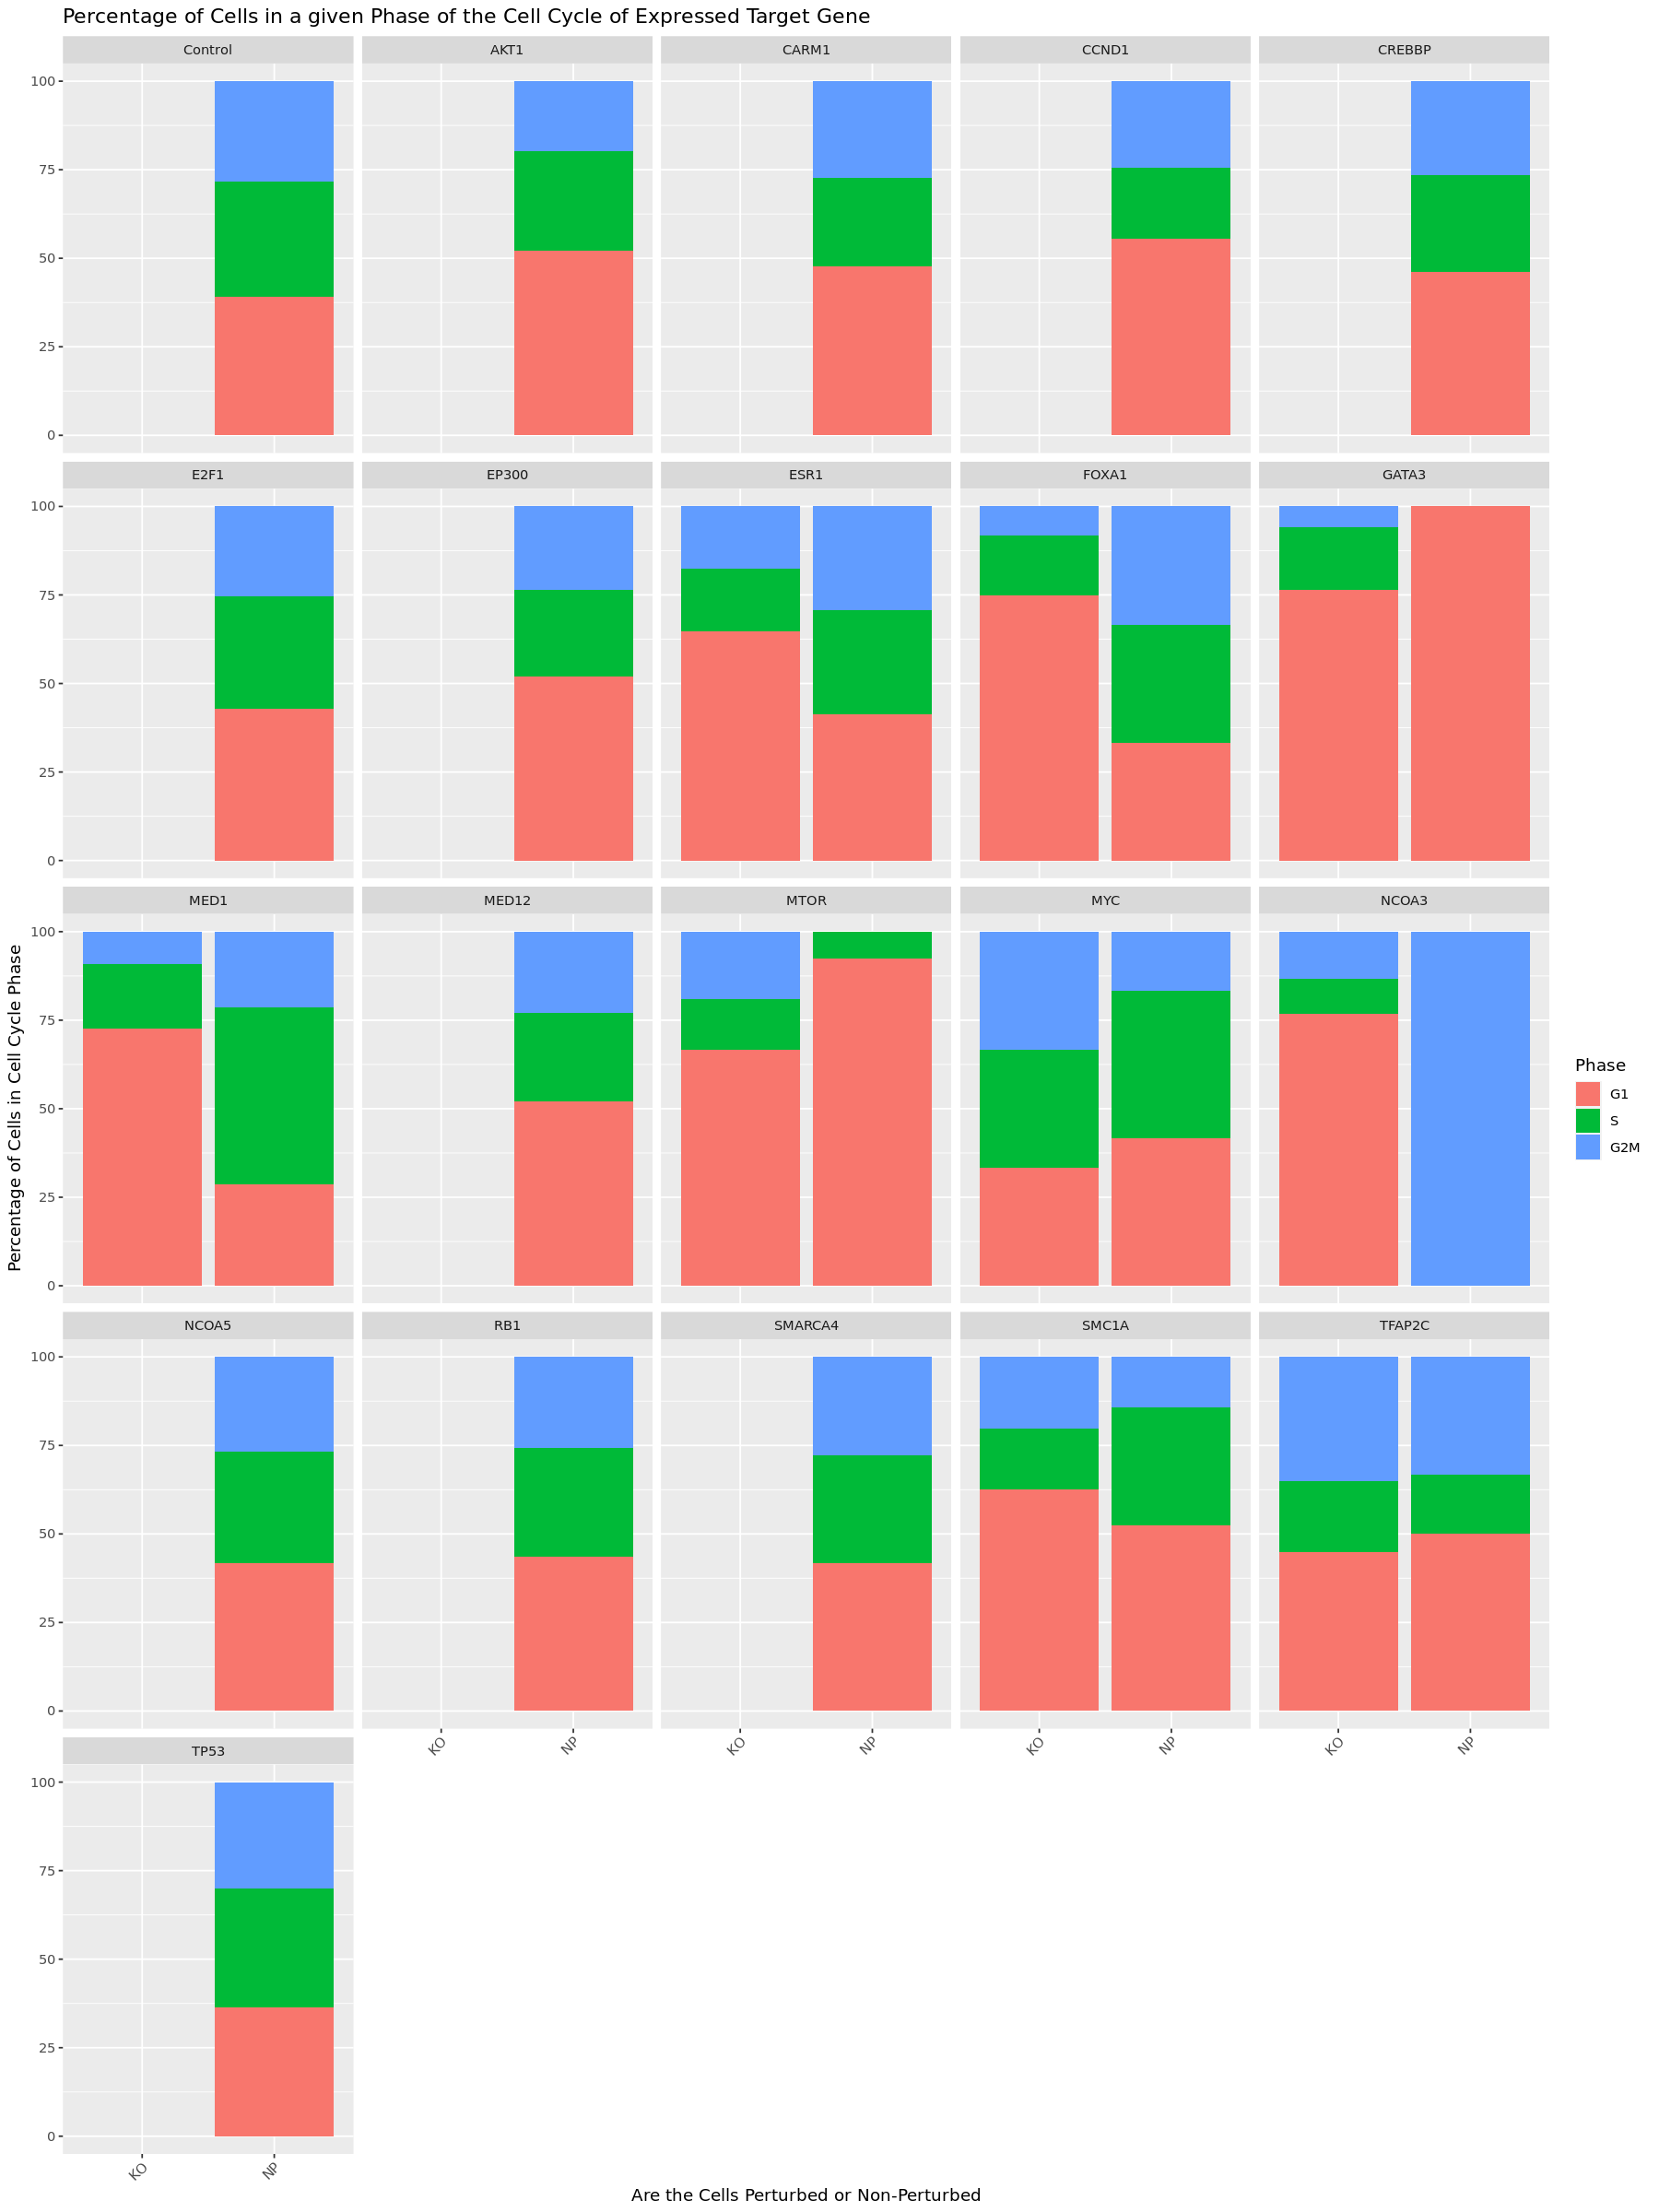

In [102]:
# plotting the percentage of cells in a given phase of the cell cycle on a given target gene
options(repr.plot.width=15, repr.plot.height=20)

edwards_cycle_plot = edwards_cell_cycle %>%
                          filter(!is.na(gene_order)) %>%
                          filter((gene %in% expr_genes) & (gene != 'MTOP')) %>% 
                          ggplot(aes(x=global_mixscape, y=percentage, fill=Phase)) +
                            geom_col(position = position_stack(reverse = TRUE)) +
                            theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                            labs(y='Percentage of Cells in Cell Cycle Phase', x='Are the Cells Perturbed or Non-Perturbed',
                                 title='Percentage of Cells in a given Phase of the Cell Cycle of Expressed Target Gene', 
                                 colour='Cell Cycle Phase') +
                           facet_wrap(~gene_order) 
edwards_cycle_plot

# Comparing Percentage of MT-Genes Distributions between Target Genes

Here were comparing the Percentages of MT-Genes Across Control, Non-Perturbed, and Perturbed Cells for both expressed and non-expressed target genes. Where interested to observe if there are any differences between distribtions of % of MT-Genes between perturbed and non-perturbed cells for a given target gene. It's important to note that all comparisons are in relation to the control cells % of MT-Genes distribution.

**Observations**
I've observed some interesting shifts in the % of MT-Genes in ESR1 and FOXA1 (possibly other target genes are maybe of interest as well).

## Non-Expressed Target Genes % of MT Distribution

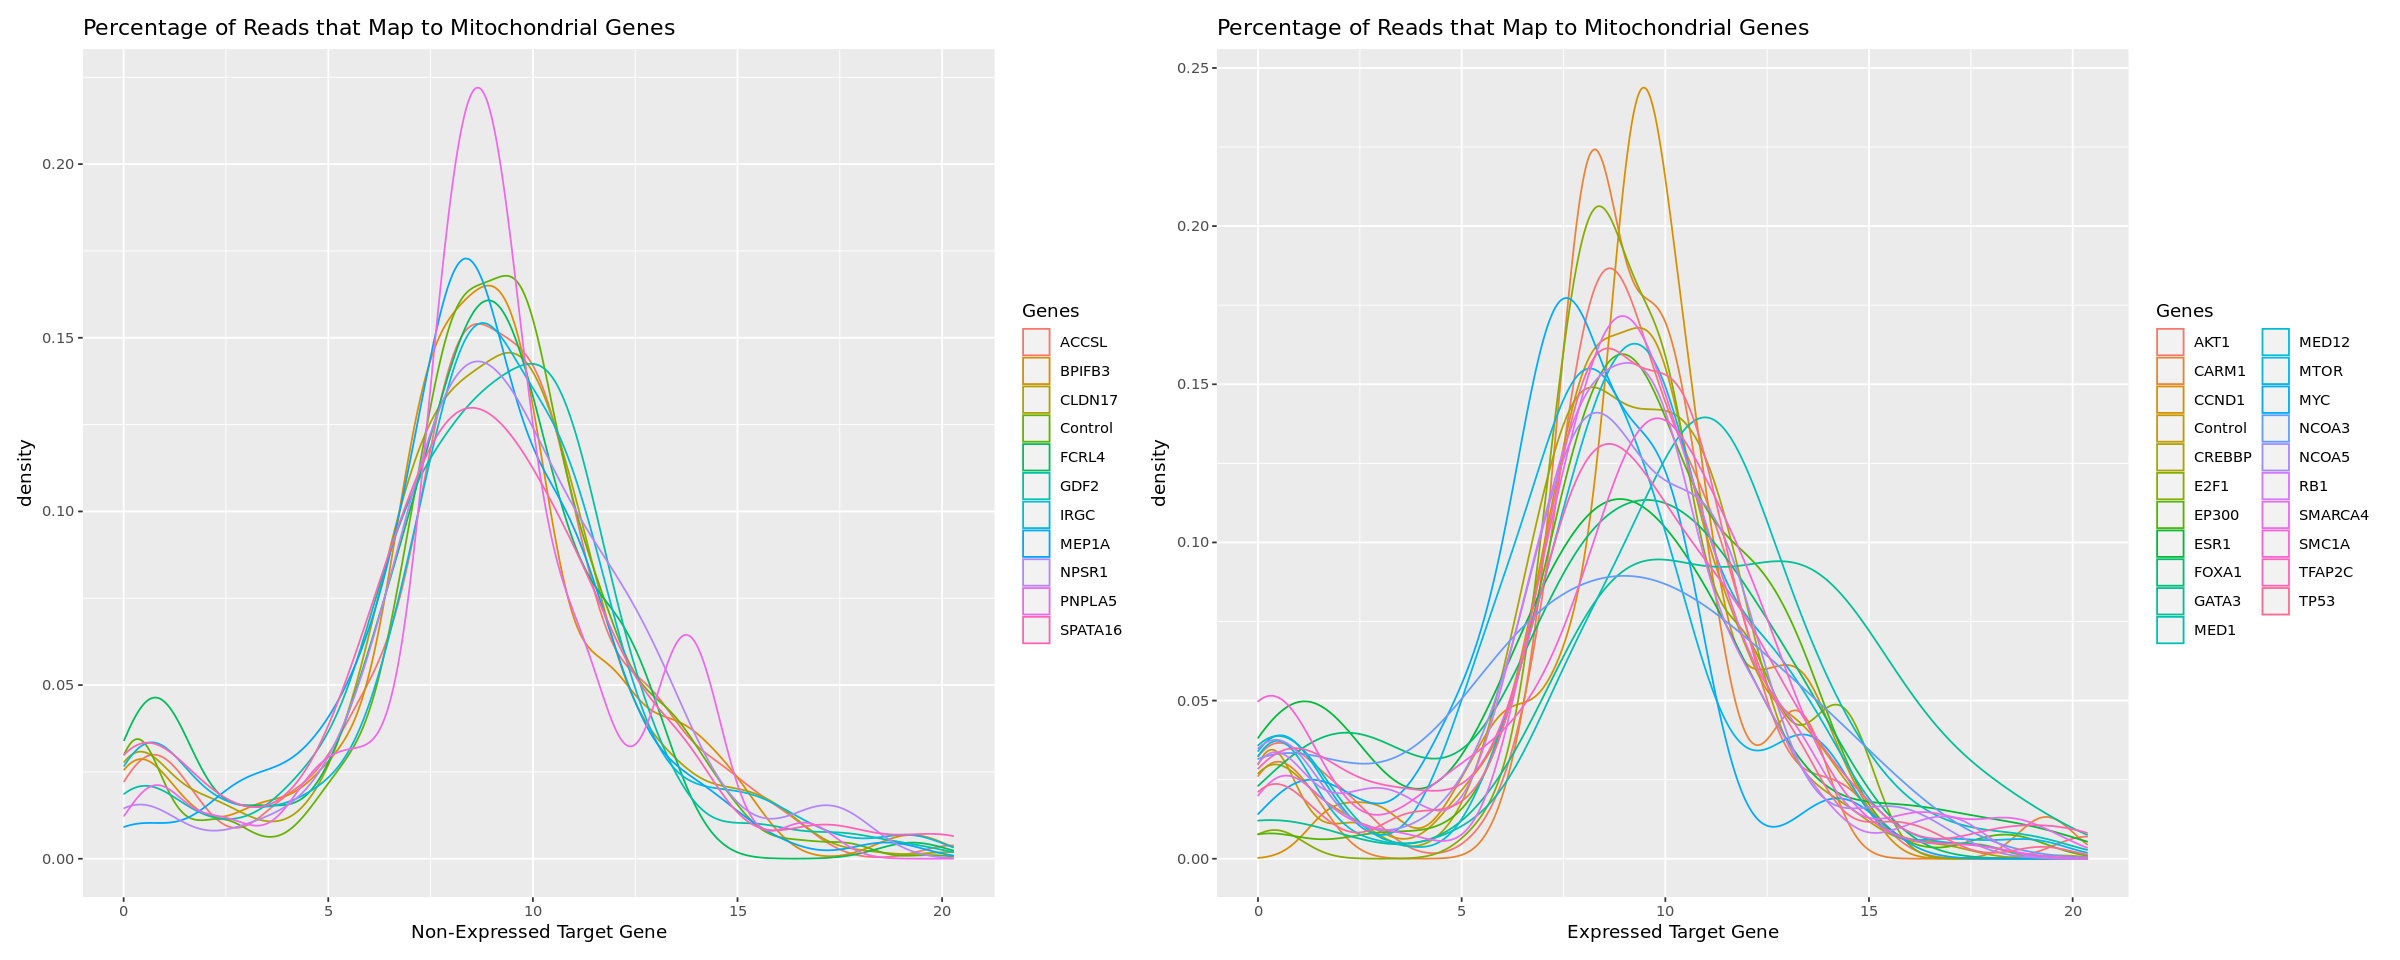

In [103]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=20, repr.plot.height=8)

m1 = edwards %>% 
          filter(gene %in% non_expr_genes) %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Non-Expressed Target Gene', title='Percentage of Reads that Map to Mitochondrial Genes', colour='Genes')

m2 = edwards %>% 
          filter(gene %in% expr_genes) %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Expressed Target Gene', title='Percentage of Reads that Map to Mitochondrial Genes', colour='Genes')


m1 | m2

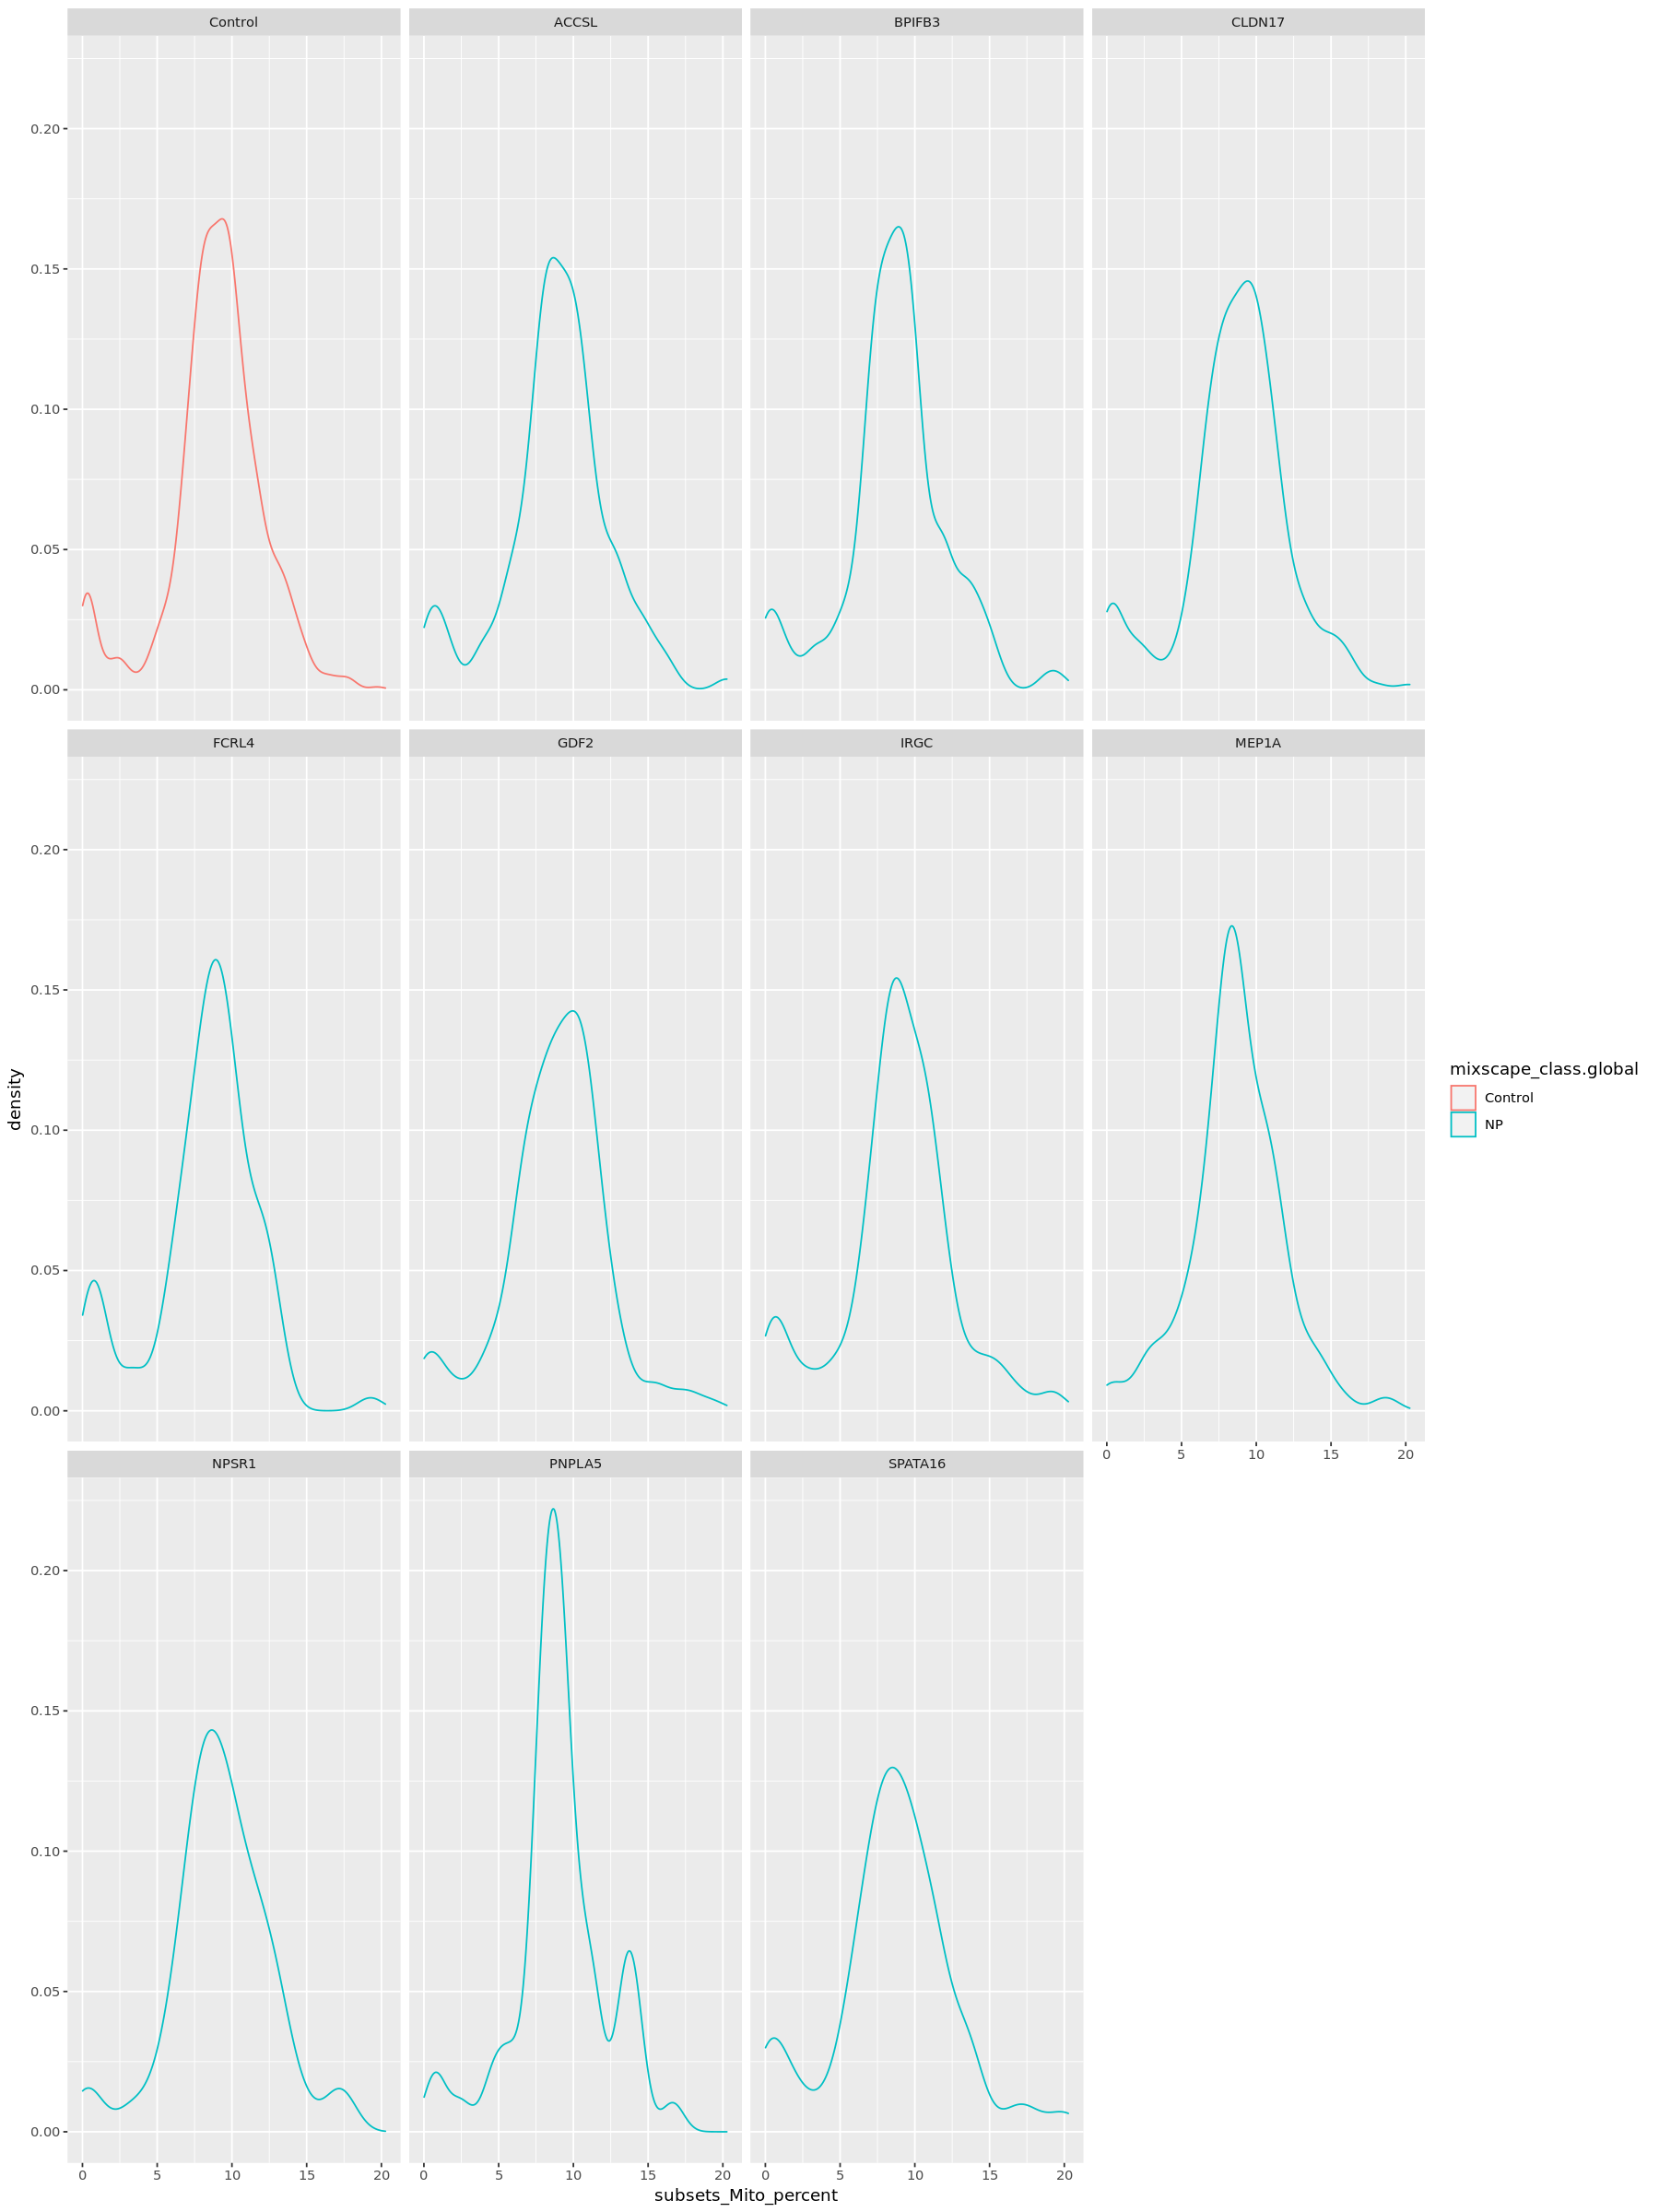

In [104]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=15, repr.plot.height=20)

edwards %>% 
  filter(gene %in% non_expr_genes) %>%
  ggplot(aes(subsets_Mito_percent, color=mixscape_class.global)) +
    geom_density() +
    facet_wrap(~gene_order)

## Mitochondria Percentage Distribution of Target Genes

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


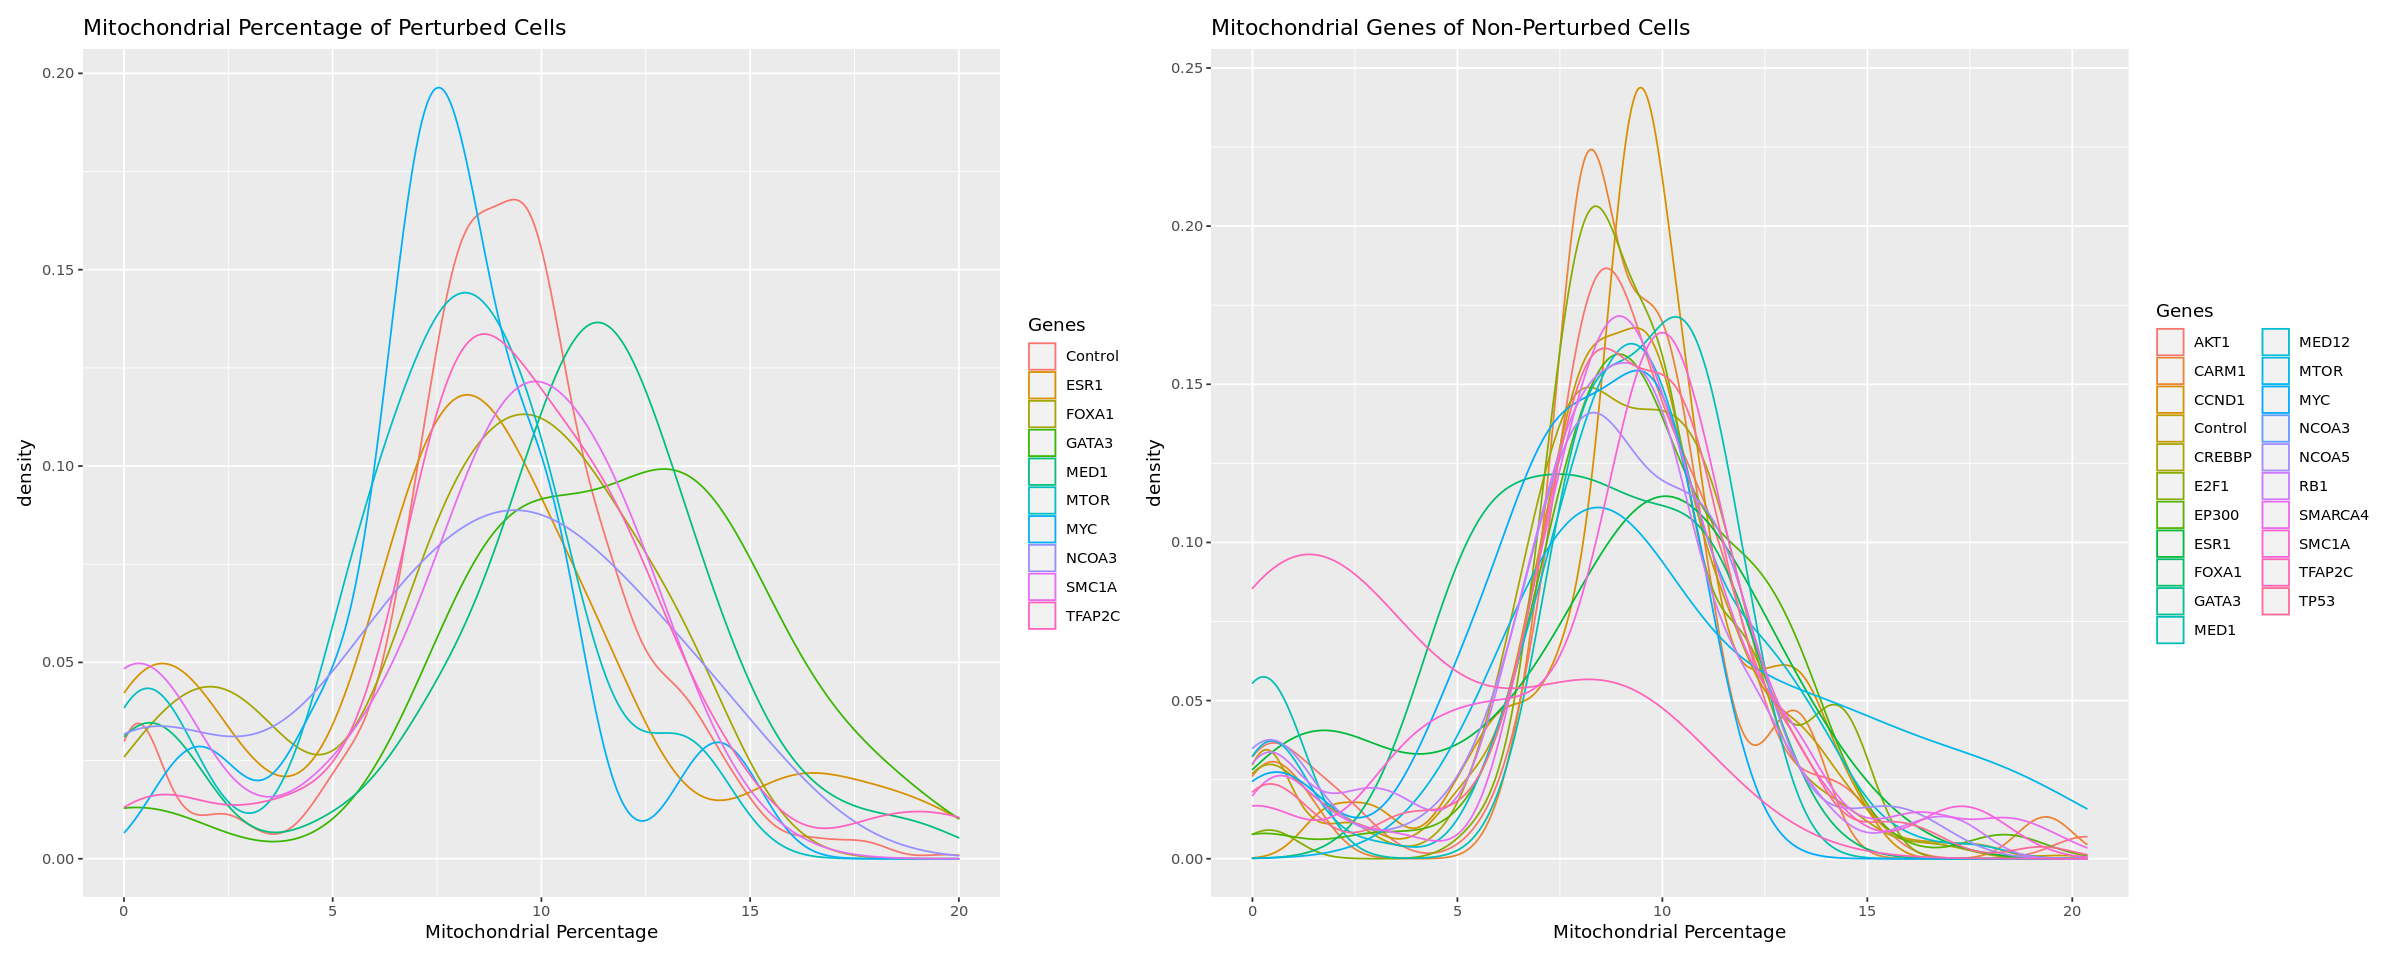

In [105]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=20, repr.plot.height=8)

m1 = edwards %>% 
          filter(gene %in% expr_genes) %>%
          filter(mixscape_class.global != 'NP') %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Mitochondrial Percentage', title='Mitochondrial Percentage of Perturbed Cells', colour='Genes')
  
m2 = edwards %>% 
          filter(gene %in% expr_genes) %>%
          filter(mixscape_class.global != 'KO') %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Mitochondrial Percentage', title='Mitochondrial Genes of Non-Perturbed Cells', colour='Genes')

m1 | m2

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


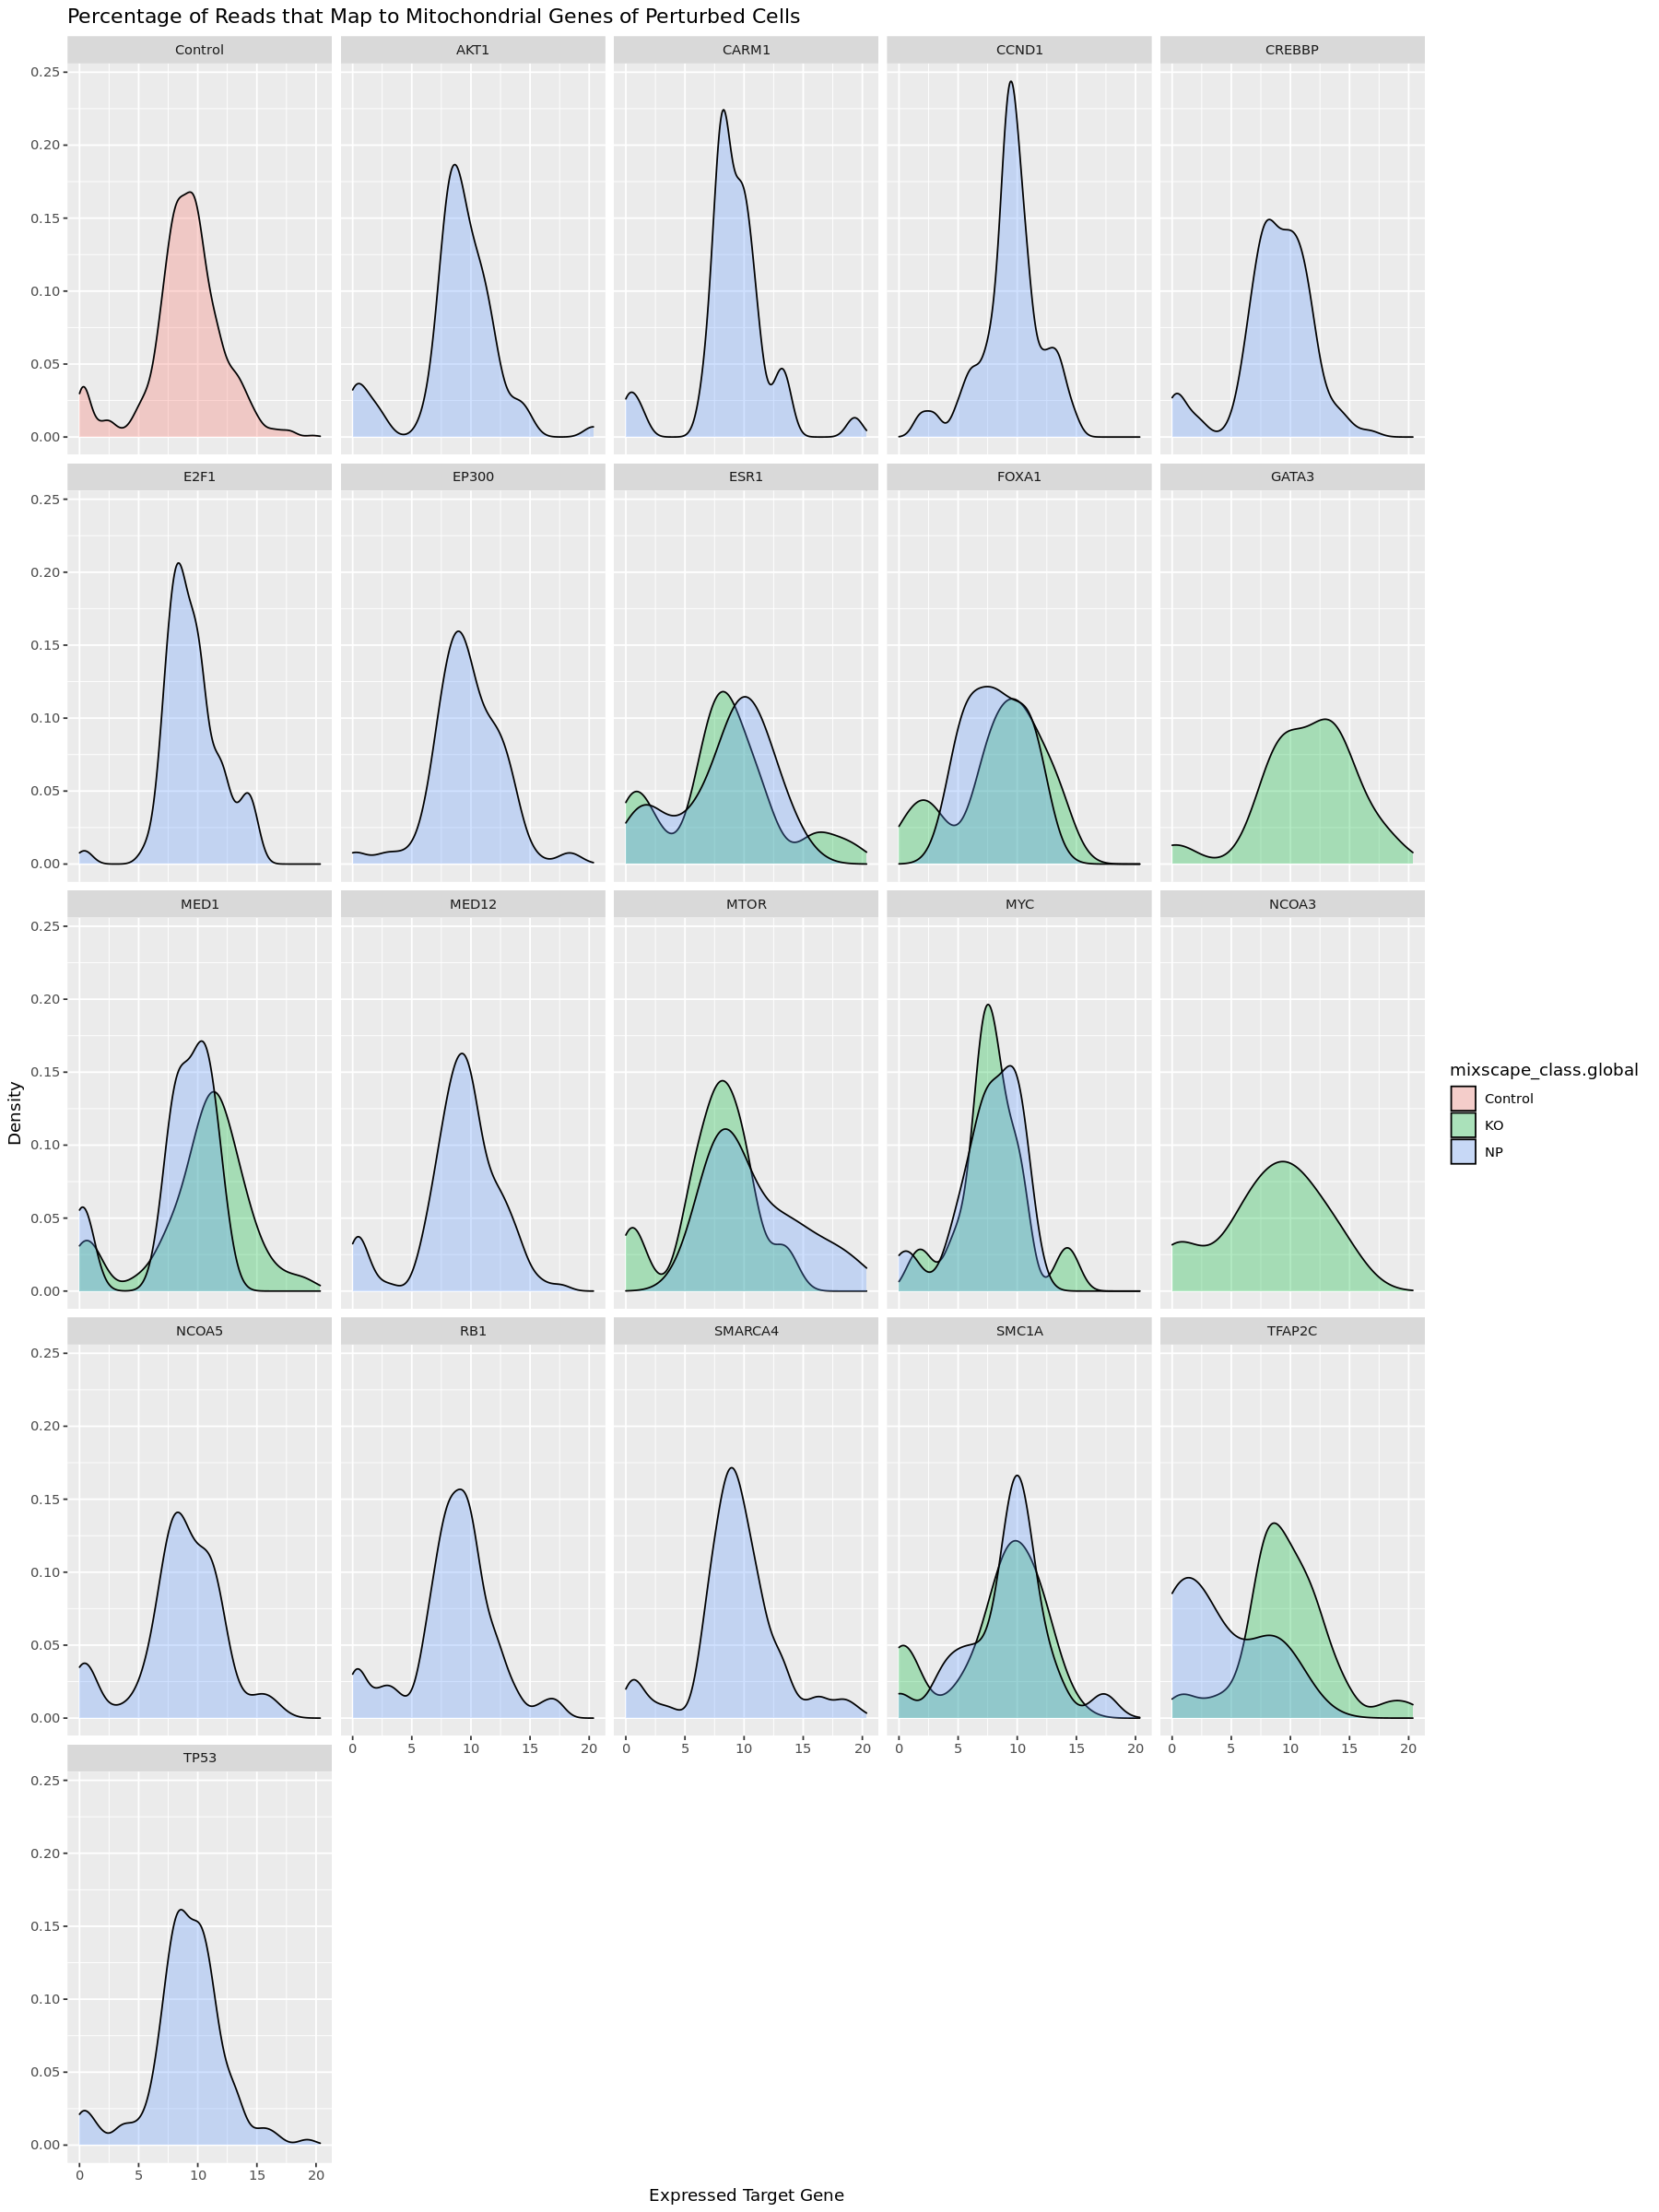

In [106]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=15, repr.plot.height=20)

edwards %>% 
  filter(gene %in% expr_genes) %>%
  ggplot(aes(subsets_Mito_percent, fill=mixscape_class.global)) +
    geom_density(alpha = 0.3) +
    labs(x='Expressed Target Gene', y='Density', title='Percentage of Reads that Map to Mitochondrial Genes of Perturbed Cells', 
         colour='Perturbation Status') +
    facet_wrap(~gene_order)

## Knock Out Efficiency of gRNA Library

In [107]:
edwards_gene_ko = calc_gene_ko(edwards)
edwards_grna_ko = calc_grna_ko(edwards)

`summarise()` has grouped output by 'library', 'gene'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'library', 'gene', 'grna_name'. You can
override using the `.groups` argument.


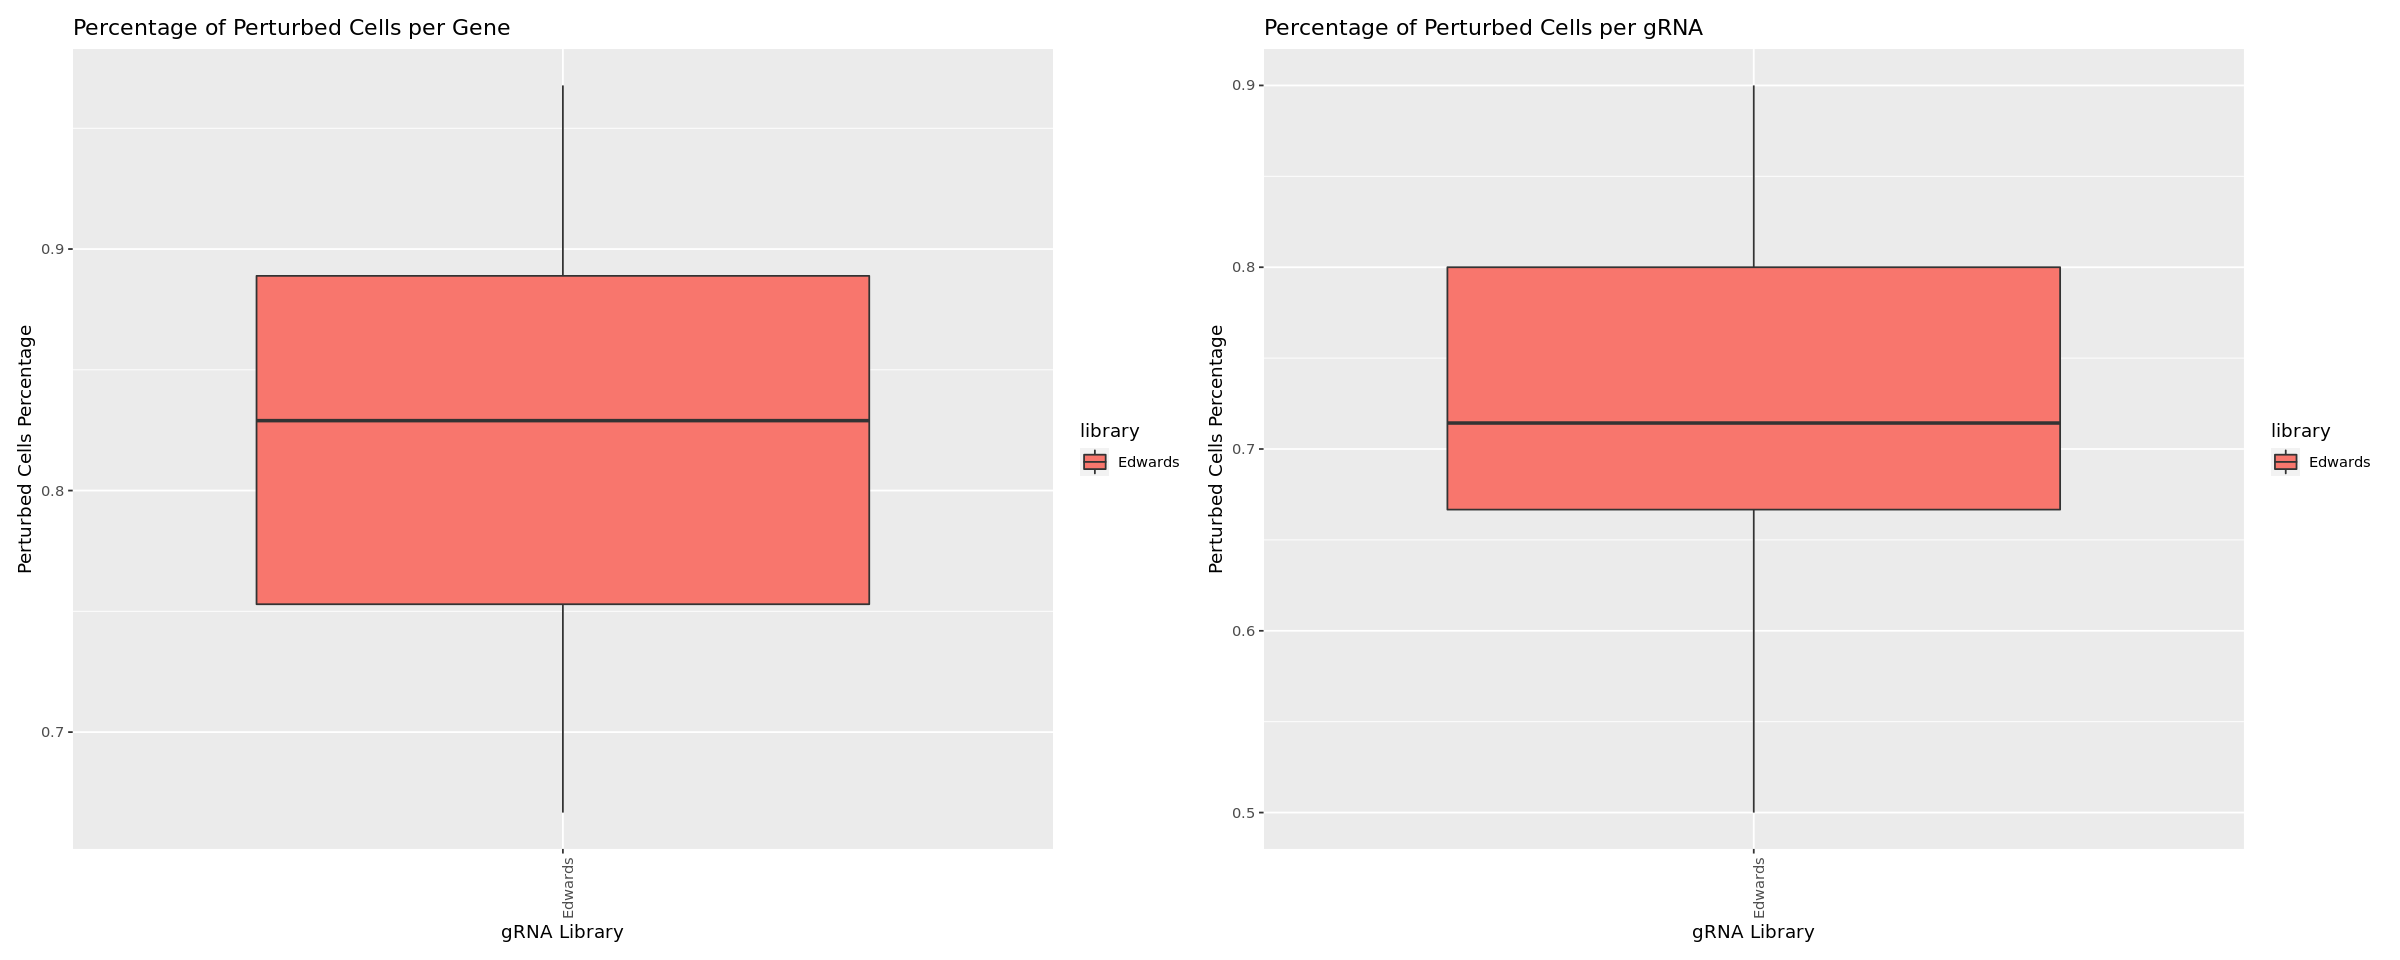

In [108]:
edwards_gene_plot = edwards_gene_ko %>%
                      group_by(library, gene) %>%
                      ggplot(aes(x=library, y=perc, fill=library)) +
                        geom_boxplot() +
                        labs(x='gRNA Library', y='Perturbed Cells Percentage',
                             title='Percentage of Perturbed Cells per Gene') +
                        theme(axis.text.x = element_text(angle = 90, hjust = 1))

edwards_grna_plot = edwards_grna_ko %>%
                      group_by(library, grna_name) %>%
                      ggplot(aes(x=library, y=perc, fill=library)) +
                        geom_boxplot() +
                        labs(x='gRNA Library', y='Perturbed Cells Percentage',
                             title='Percentage of Perturbed Cells per gRNA') +
                        theme(axis.text.x = element_text(angle = 90, hjust = 1))

options(repr.plot.width=20, repr.plot.height=8)
edwards_gene_plot | edwards_grna_plot

## Assessing the Correlation between Log Fold Change of G1 in Cells versus Dropout

In [109]:
ko_g1 = edwards_cell_cycle %>% dplyr::filter((Phase == 'G1') & (global_mixscape == 'KO' | gene == ctrl_label))
carroll = carroll %>% dplyr::filter(gene_name %in% ko_g1$gene)
carroll$gene = carroll$gene_name


# Calculating the Log Fold Change of the Percentage Cells in G1 Phase of the Cell Cycle
ko_g1$log2 = log2(ko_g1$percentage)
ctrl_log2 = ko_g1[ko_g1$gene == 'Control', ]$log2
ko_g1$g1_fold_change = ko_g1$log2 - ctrl_log2

lcf_d3 = left_join(carroll[,c('gene', 'D7_Vs_D3','D9_Vs_D3','D12_Vs_D3','D15_Vs_D3','D20_Vs_D3')],
                         ko_g1[, c('gene', 'g1_fold_change')],
                         by='gene')

lcf_d7 = left_join(carroll[,c('gene', 'D9_Vs_D7','D12_Vs_D7','D15_Vs_D7','D20_Vs_D7')],
                         ko_g1[, c('gene', 'g1_fold_change')],
                         by='gene')

In [110]:
# comparing d3 vs g1 log fold change
lfc1_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D7_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc2_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D9_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc3_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D12_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc4_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D15_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc5_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D20_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))

# comparing d7 vs g1 log fold change
lfc1_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D9_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc2_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D12_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc3_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D15_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc4_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D20_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))

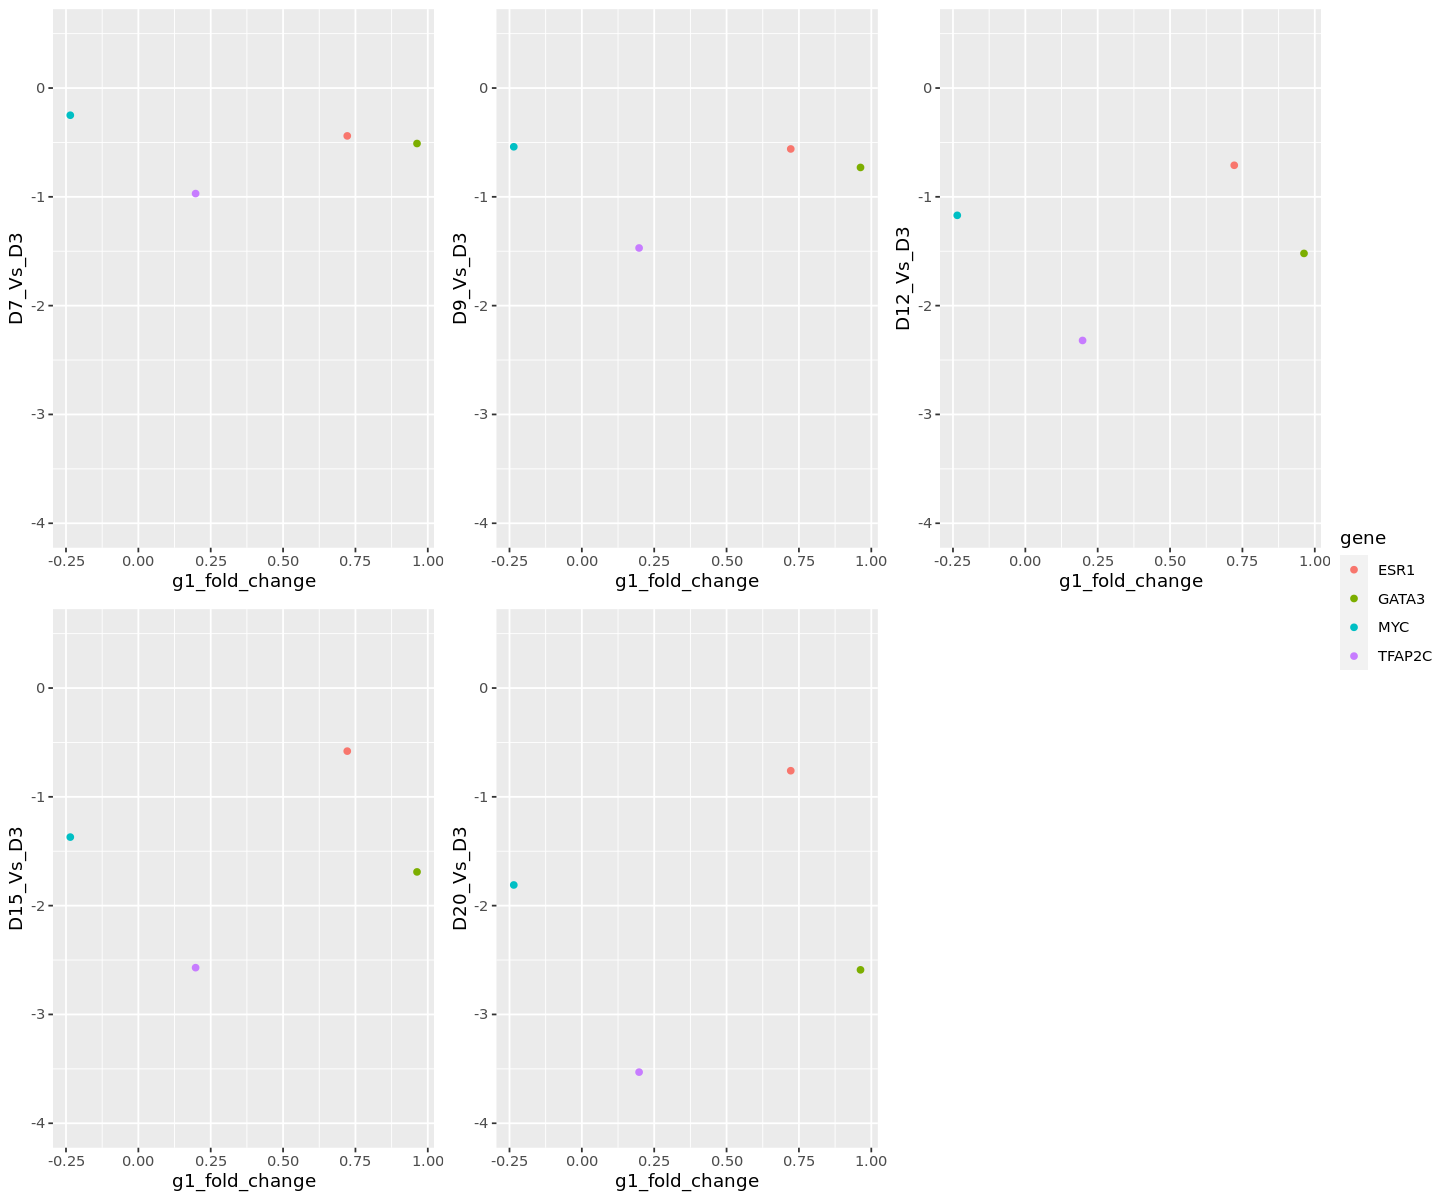

In [111]:
options(repr.plot.width=12, repr.plot.height=10)
ggarrange(lfc1_d3, lfc2_d3, lfc3_d3, lfc4_d3, lfc5_d3, ncol=3, nrow=2, common.legend = TRUE, legend="right")

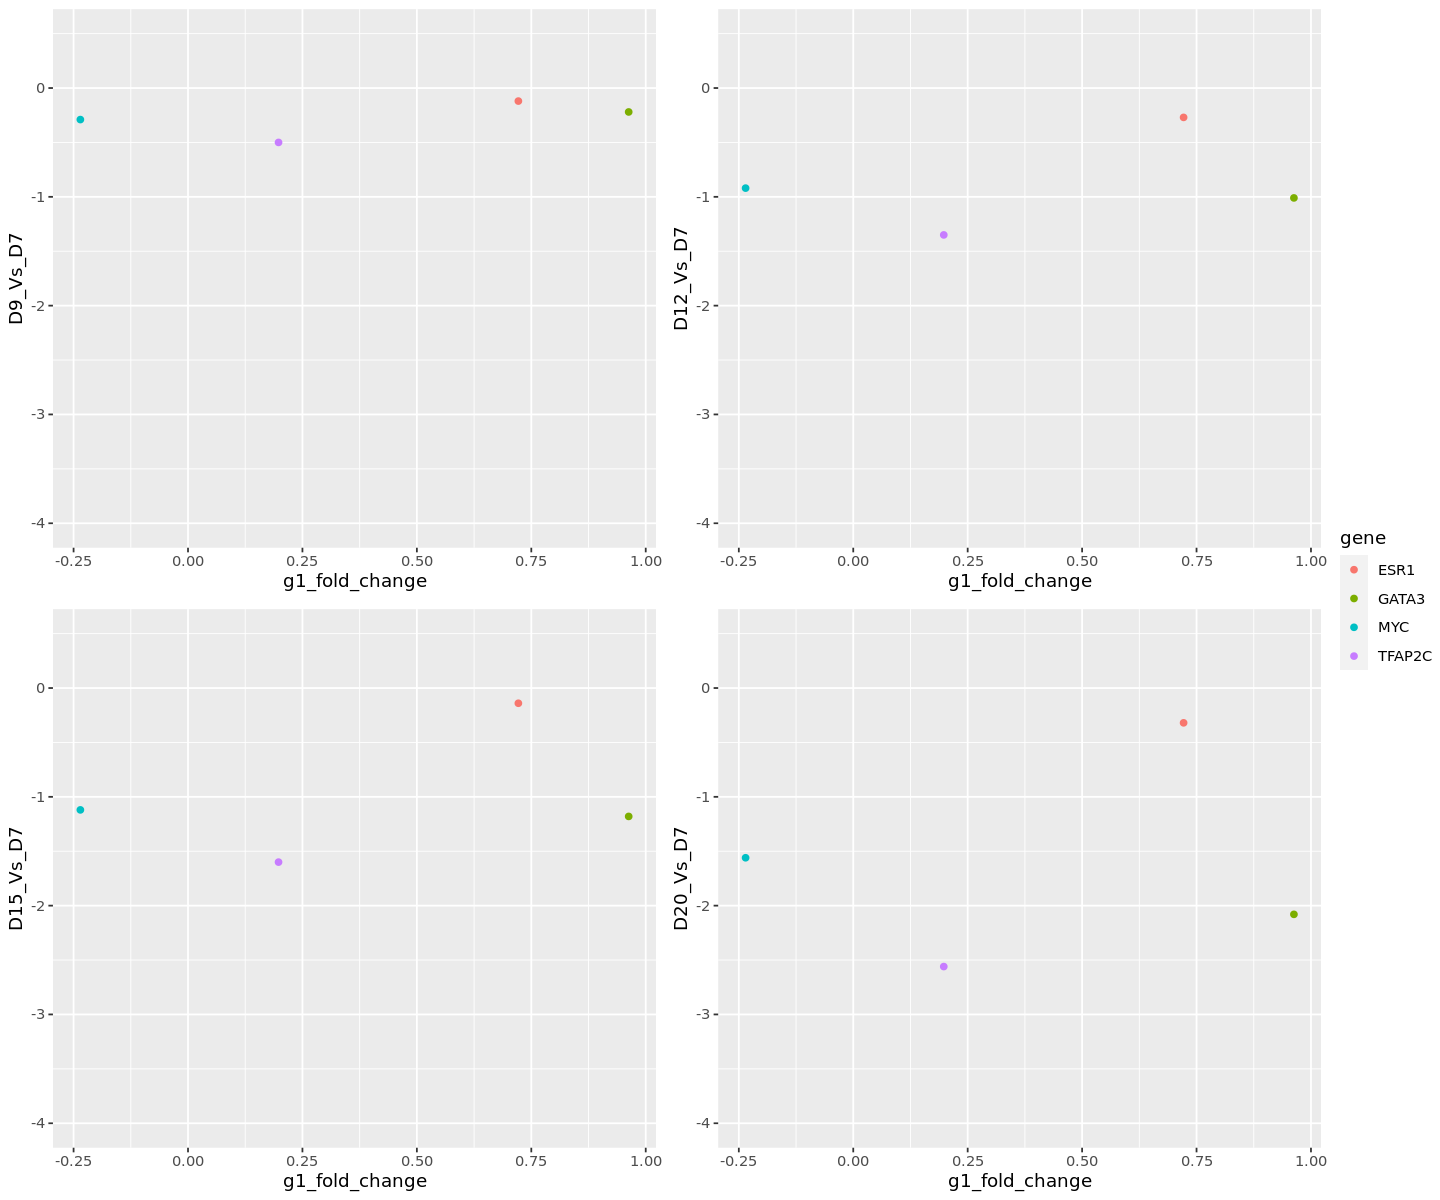

In [112]:
options(repr.plot.width=12, repr.plot.height=10)
ggarrange(lfc1_d7, lfc2_d7, lfc3_d7, lfc4_d7, ncol=2, nrow=2, common.legend = TRUE, legend="right")

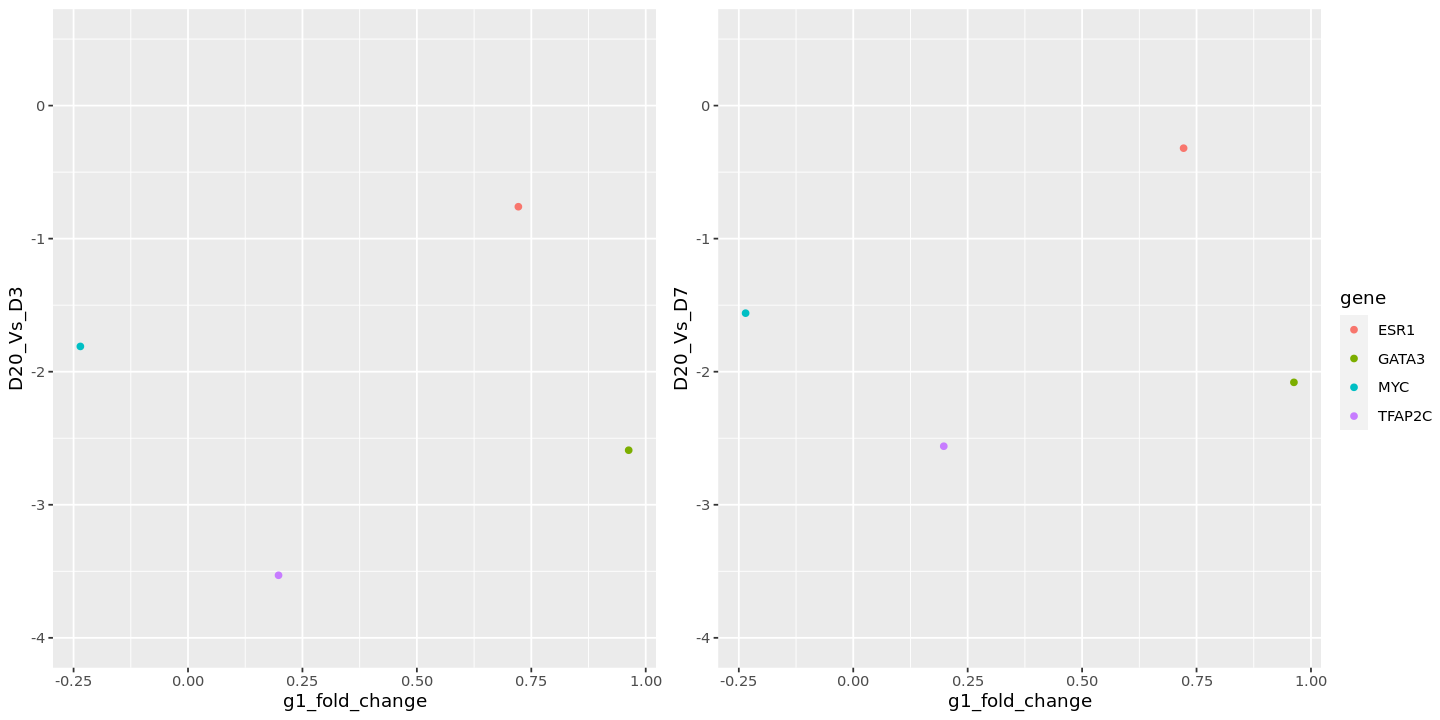

In [113]:
options(repr.plot.width=12, repr.plot.height=6)
ggarrange(lfc5_d3, lfc4_d7, ncol=2, nrow=1, common.legend = TRUE, legend="right")

# Analysis of Brunello Library

## Exploring the Percentage of Cells in a Cell Cycle for a Given Target Gene

Comparing the percentage of Cells in the Cell Cycle for a given Target Genes. This always use to observe potiential changes in the number of cells in a given phase of the cell cycle between Perturbed and Non-Perturbed Cells. Additionally, the i plotted the percentage of cells in a given phase of cell cycle for control cells. General Observation I have is that most perturbed cells regardless of target genes tend to have more cells in the G1 phase of the Cell Cycle.

### Creating Merged and Non-Merged Perturbed Cell Metadata

In [114]:
# Calculating percentage of cells in each phase of the cell cycle
brunello_cell_cycle = calc_cell_cycle_perc(brunello)

# extract non expressed and expressed target genes as separate vectors
expr_genes = rownames(Edwards_gene_metadata[Edwards_gene_metadata$Category != 'Unknown', ])
non_expr_genes = rownames(Edwards_gene_metadata[Edwards_gene_metadata$Category == 'Unknown', ])

# adding controls to these vectors. This allows me to select which gene set i want to visualize
expr_genes = c(expr_genes, ctrl_label)
non_expr_genes = c(non_expr_genes, ctrl_label)

# reorder genes so control at the start of the figures
genes_order = c(ctrl_label, as.character(unique(brunello_cell_cycle$gene[brunello_cell_cycle$gene != ctrl_label])))

brunello_cell_cycle$gene_order = factor(brunello_cell_cycle$gene, levels=genes_order, labels=genes_order)
brunello_cell_cycle$Phase = factor(brunello_cell_cycle$Phase, levels=c("G1", "S", "G2M"), labels=c("G1", "S", "G2M"))
brunello$gene_order = factor(brunello$gene, levels=genes_order, labels=genes_order)

## Percentage of Cells in Phases of Cell Cycle for Non Expressed Target Genes

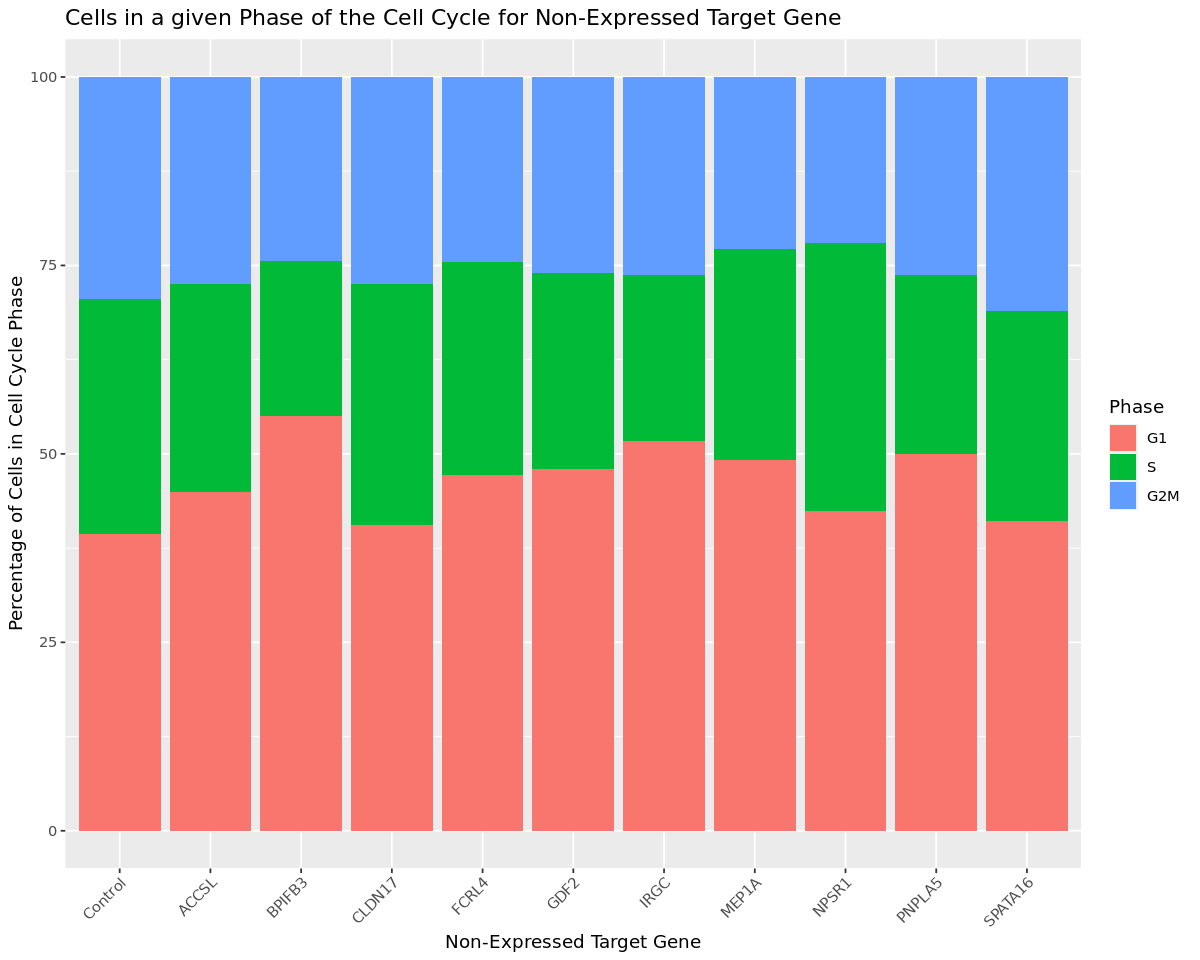

In [115]:
options(repr.plot.width=10, repr.plot.height=8)
brunello_cell_cycle %>%
  filter(gene %in% non_expr_genes) %>%
  ggplot(aes(x=gene_order, y=percentage, fill=Phase)) +
    geom_col(position = position_stack(reverse = TRUE)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(y='Percentage of Cells in Cell Cycle Phase', x='Non-Expressed Target Gene',
         title='Cells in a given Phase of the Cell Cycle for Non-Expressed Target Gene')

## Percentage of Cells in Phases of Cell Cycle for Expressed Target Genes

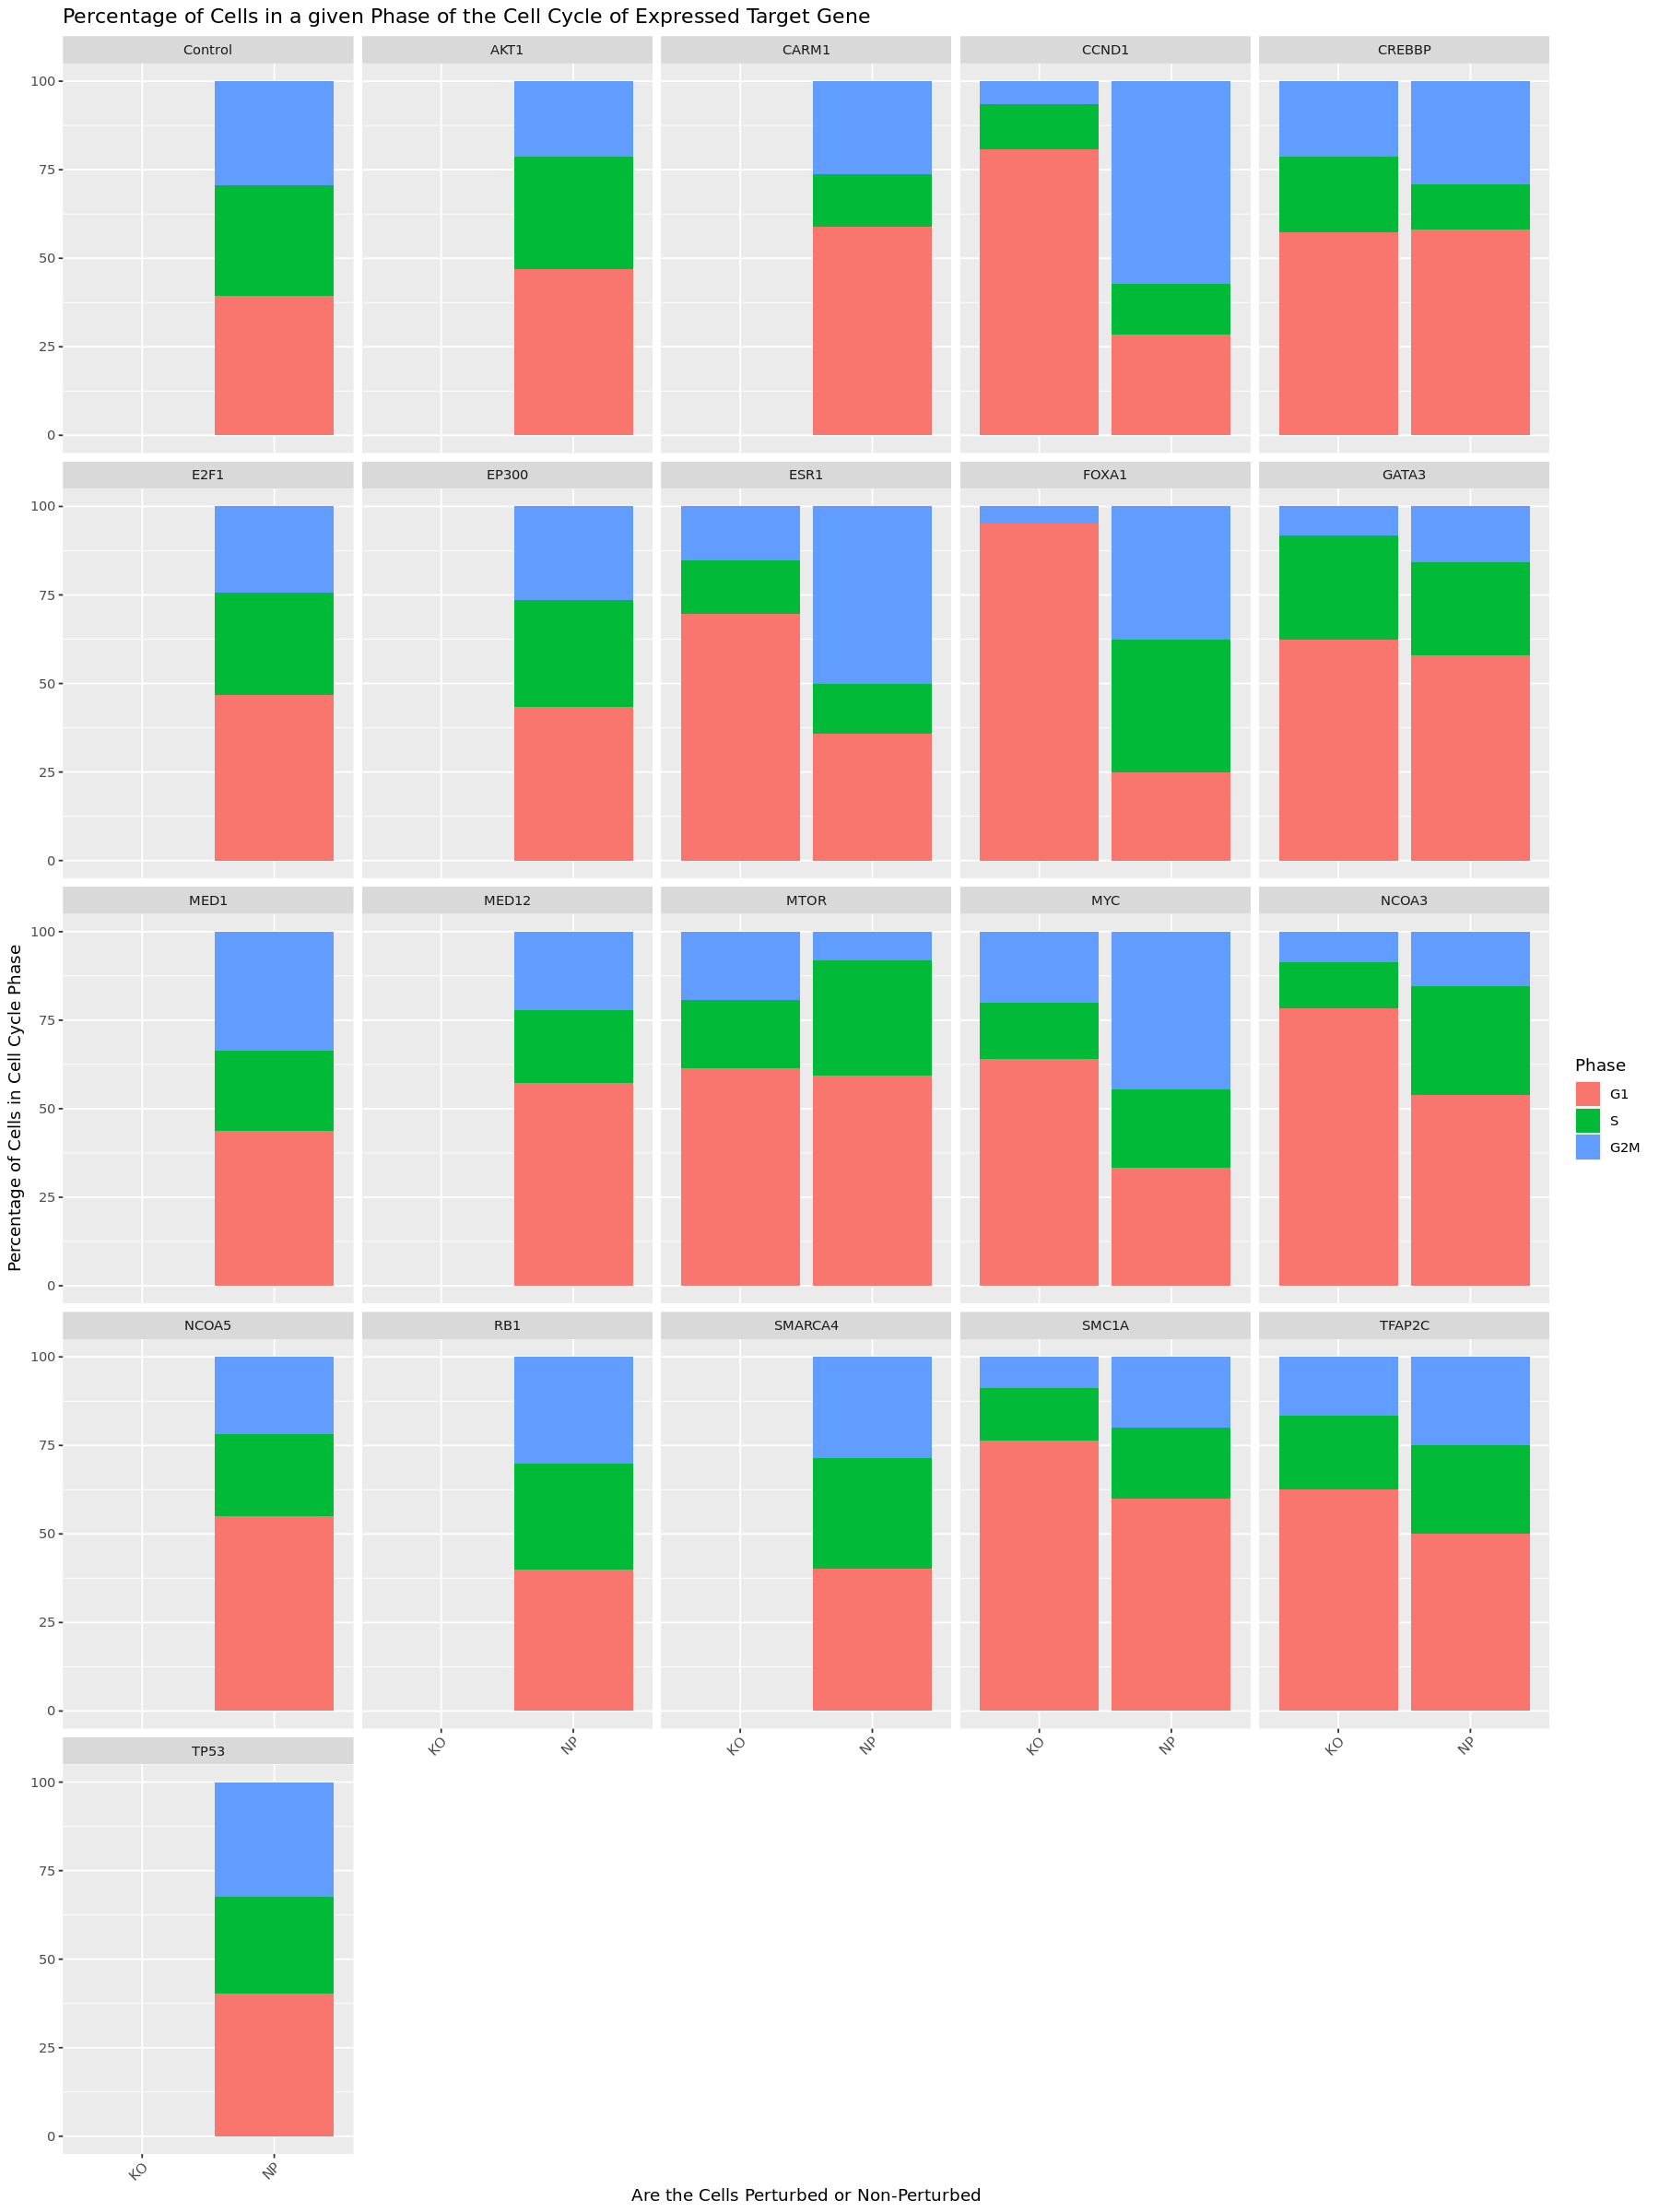

In [116]:
# plotting the percentage of cells in a given phase of the cell cycle on a given target gene
options(repr.plot.width=15, repr.plot.height=20)

brunello_cycle_plot = brunello_cell_cycle %>%
                      filter(!is.na(gene_order) & gene %in% expr_genes) %>% 
                      ggplot(aes(x=global_mixscape, y=percentage, fill=Phase)) +
                        geom_col(position = position_stack(reverse = TRUE)) +
                        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
                        labs(y='Percentage of Cells in Cell Cycle Phase', x='Are the Cells Perturbed or Non-Perturbed',
                             title='Percentage of Cells in a given Phase of the Cell Cycle of Expressed Target Gene', 
                             colour='Cell Cycle Phase') +
                       facet_wrap(~gene_order)
brunello_cycle_plot

# Comparing Percentage of MT-Genes Distributions between Target Genes

Here were comparing the Percentages of MT-Genes Across Control, Non-Perturbed, and Perturbed Cells for both expressed and non-expressed target genes. Where interested to observe if there are any differences between distribtions of % of MT-Genes between perturbed and non-perturbed cells for a given target gene. It's important to note that all comparisons are in relation to the control cells % of MT-Genes distribution.

**Observations**
I've observed some interesting shifts in the % of MT-Genes in ESR1 and FOXA1 (possibly other target genes are maybe of interest as well).

## Non-Expressed Target Genes % of MT Distribution

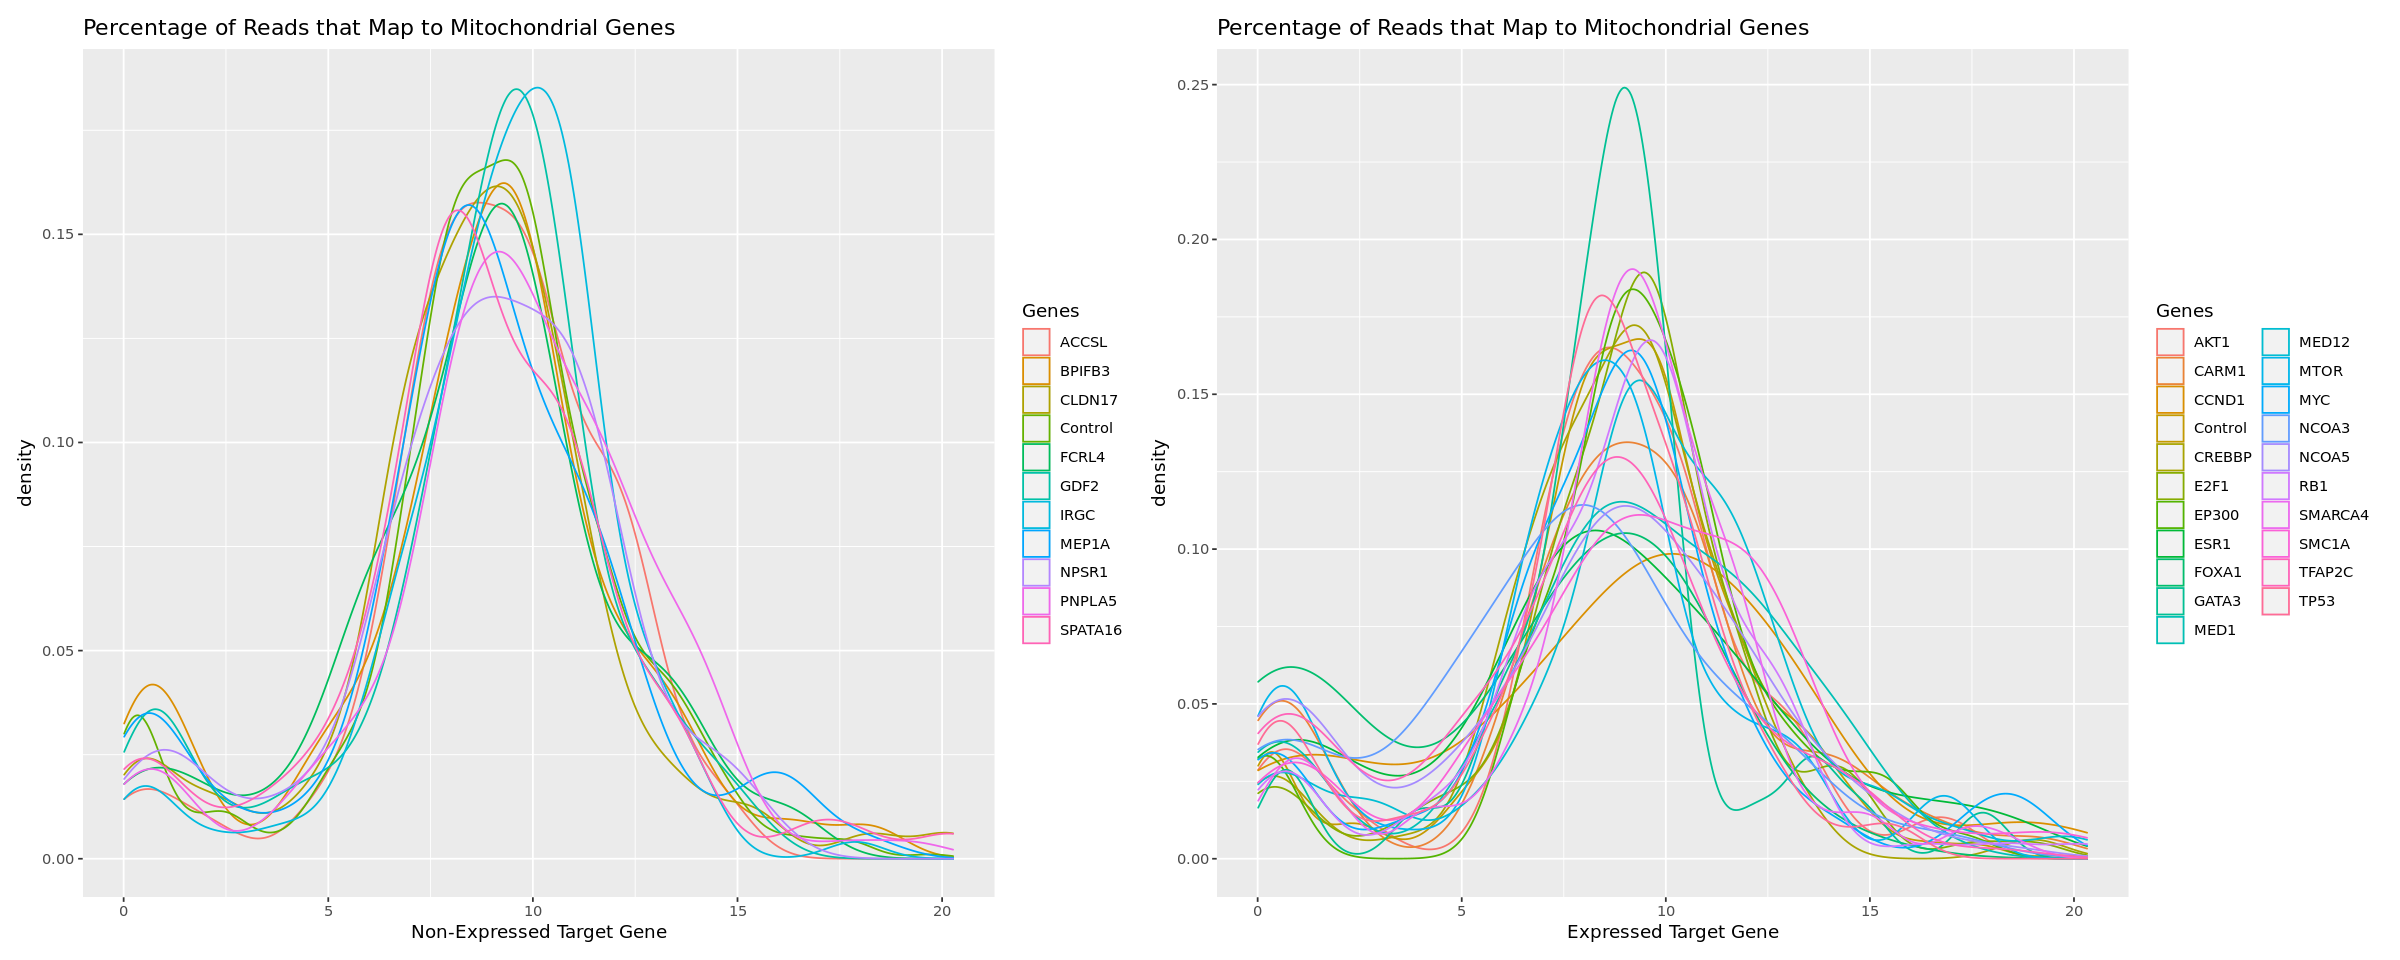

In [117]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=20, repr.plot.height=8)

m1 = brunello %>% 
          filter(gene %in% non_expr_genes) %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Non-Expressed Target Gene', title='Percentage of Reads that Map to Mitochondrial Genes', colour='Genes')

m2 = brunello %>% 
          filter(gene %in% expr_genes) %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Expressed Target Gene', title='Percentage of Reads that Map to Mitochondrial Genes', colour='Genes')


m1 | m2

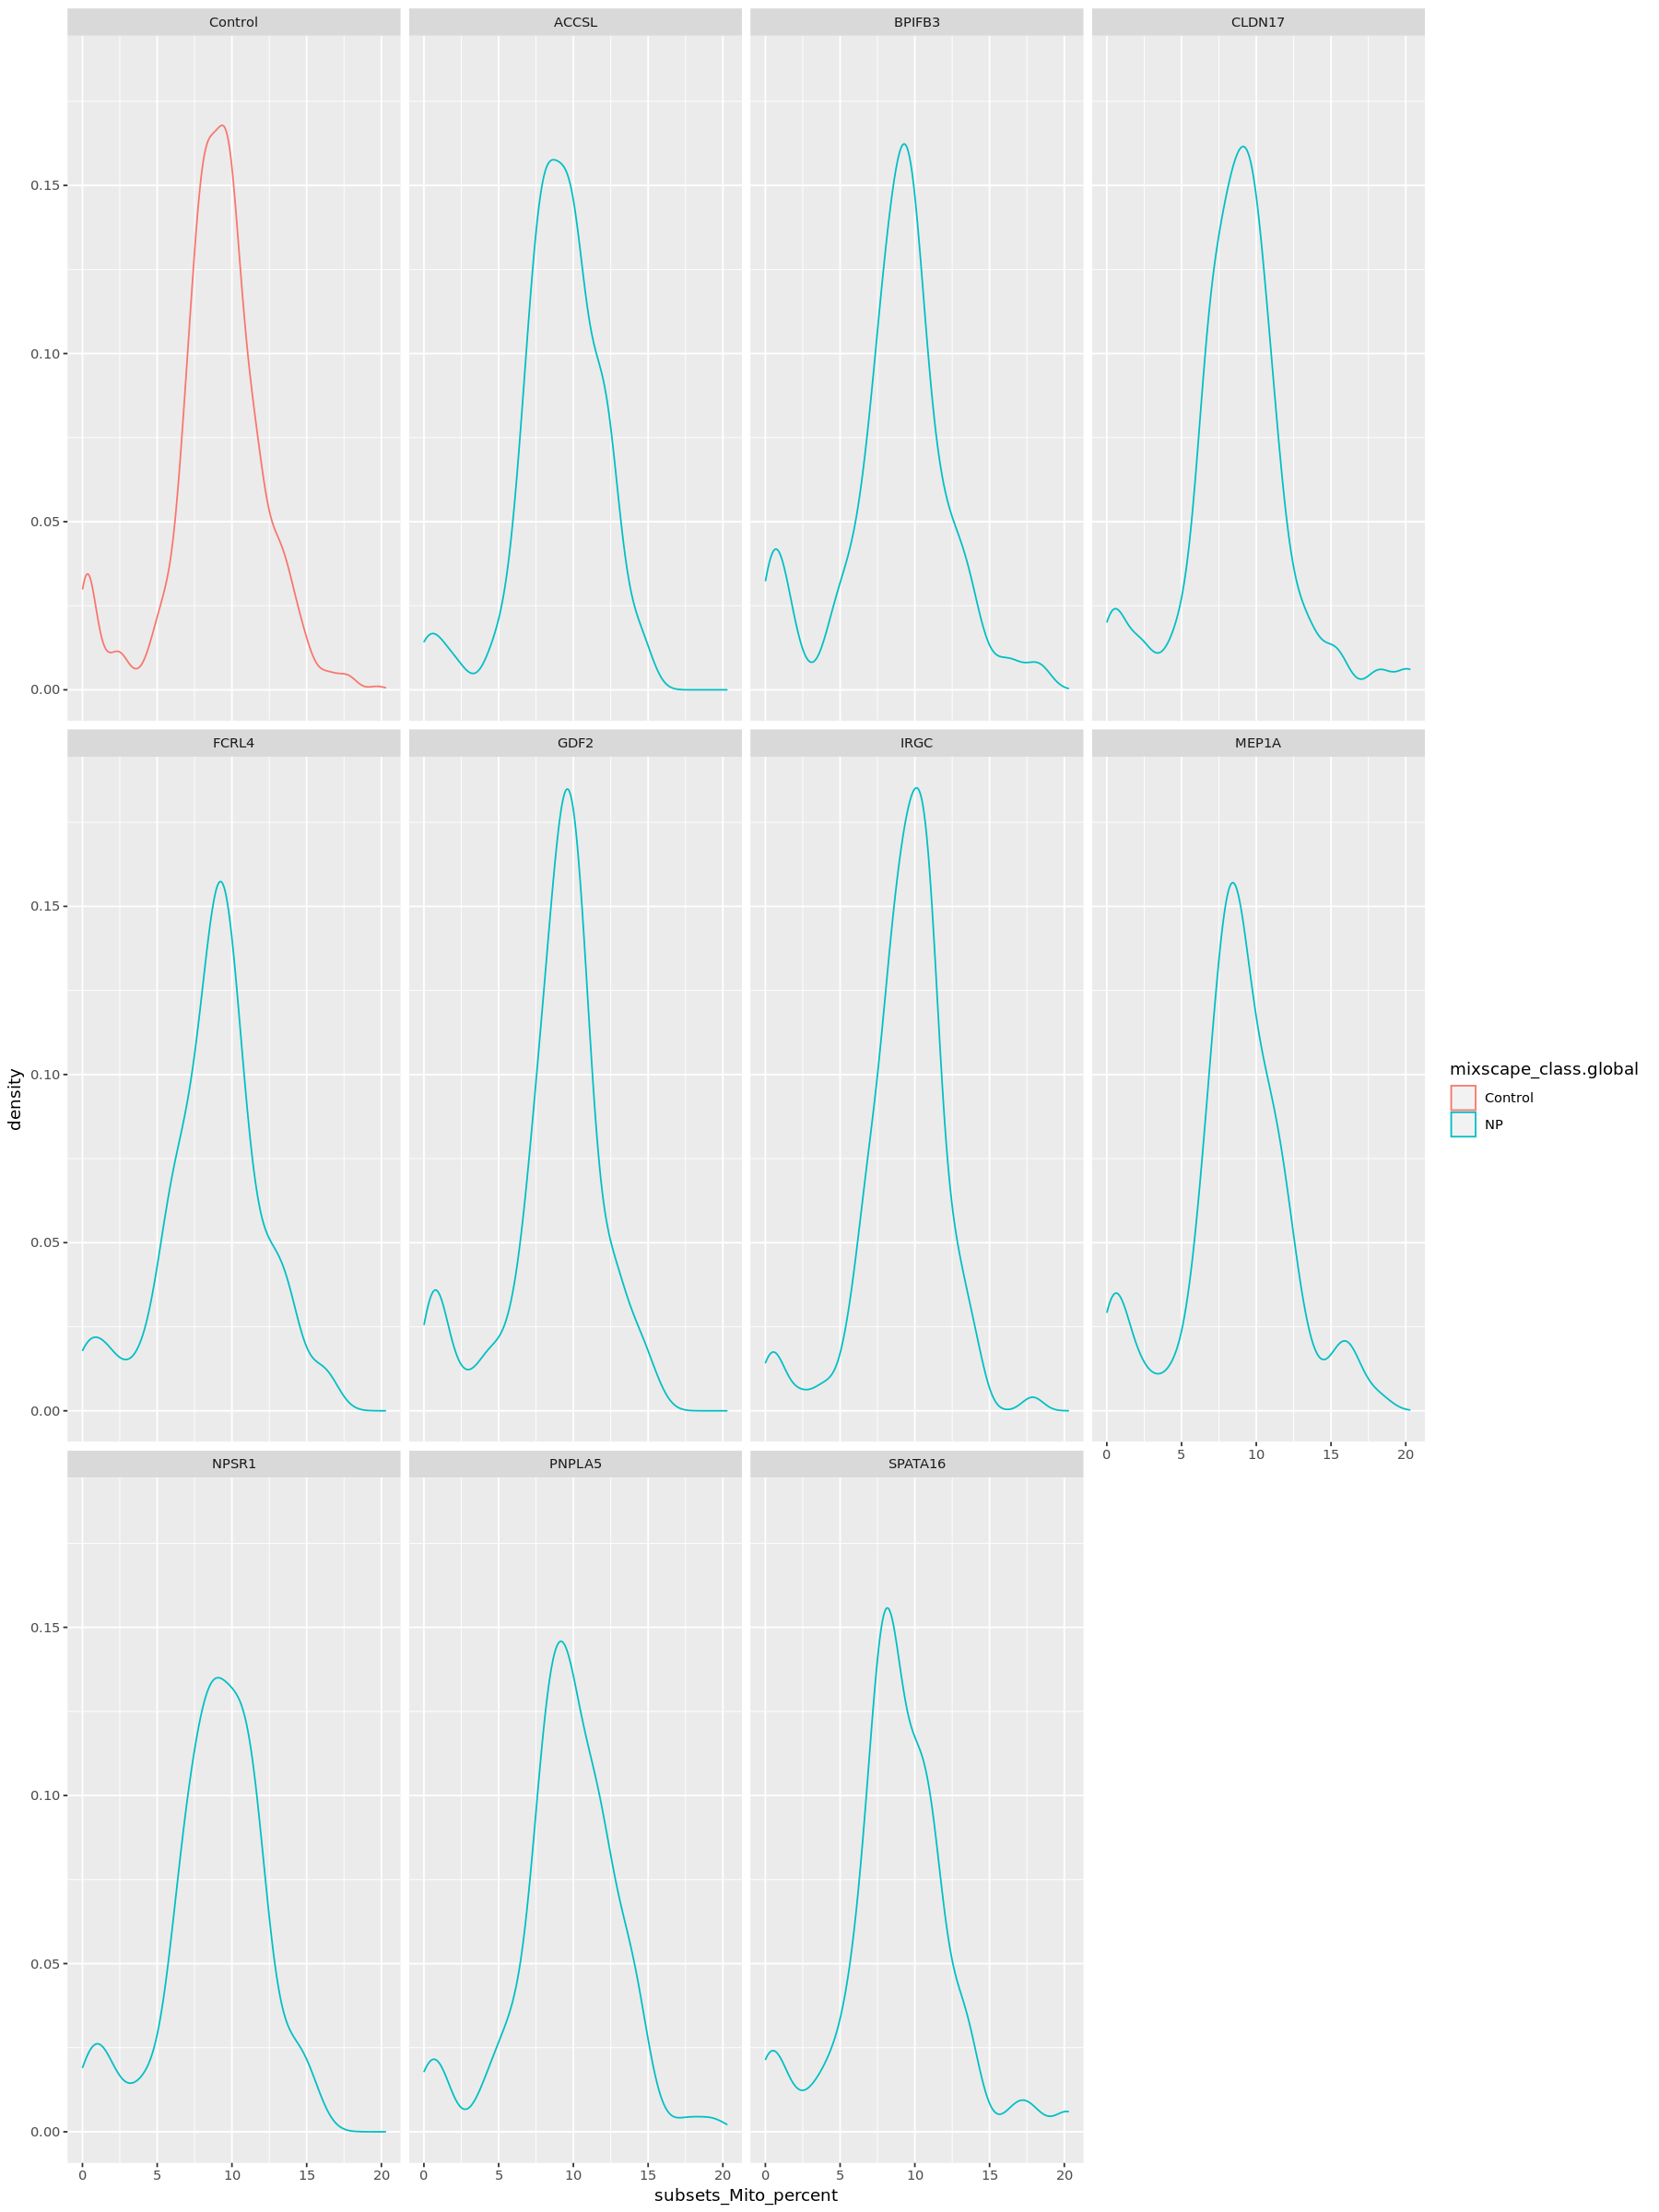

In [118]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=15, repr.plot.height=20)

brunello %>% 
  filter(gene %in% non_expr_genes) %>%
  ggplot(aes(subsets_Mito_percent, color=mixscape_class.global)) +
    geom_density() +
    facet_wrap(~gene_order)

## Mitochondria Percentage Distribution of Target Genes

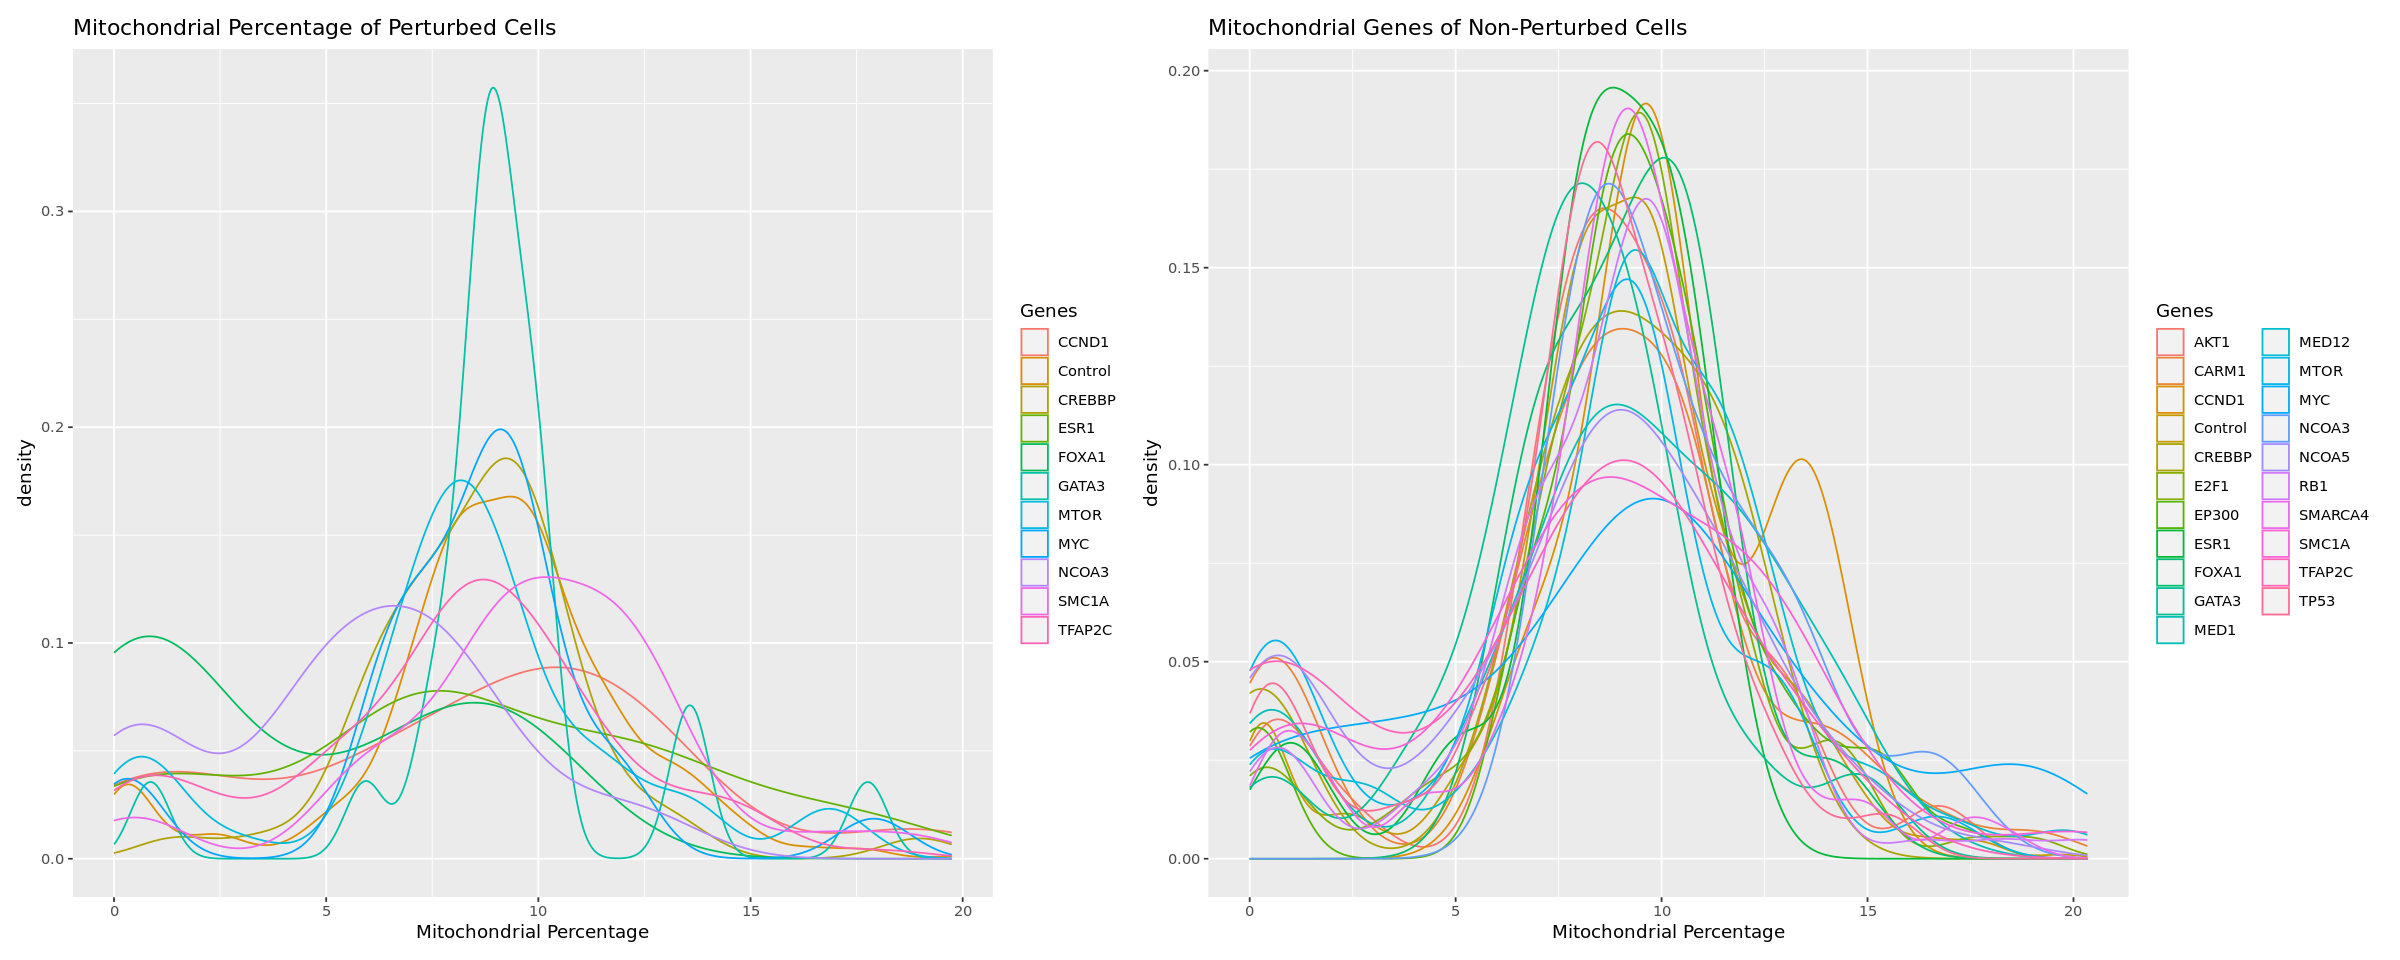

In [119]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=20, repr.plot.height=8)

m1 = brunello %>% 
          filter(gene %in% expr_genes) %>%
          filter(mixscape_class.global != 'NP') %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Mitochondrial Percentage', title='Mitochondrial Percentage of Perturbed Cells', colour='Genes')
  
m2 = brunello %>% 
          filter(gene %in% expr_genes) %>%
          filter(mixscape_class.global != 'KO') %>%
          ggplot(aes(subsets_Mito_percent, color=gene)) +
          geom_density(alpha = 0.1) +
          labs(x='Mitochondrial Percentage', title='Mitochondrial Genes of Non-Perturbed Cells', colour='Genes')

m1 | m2

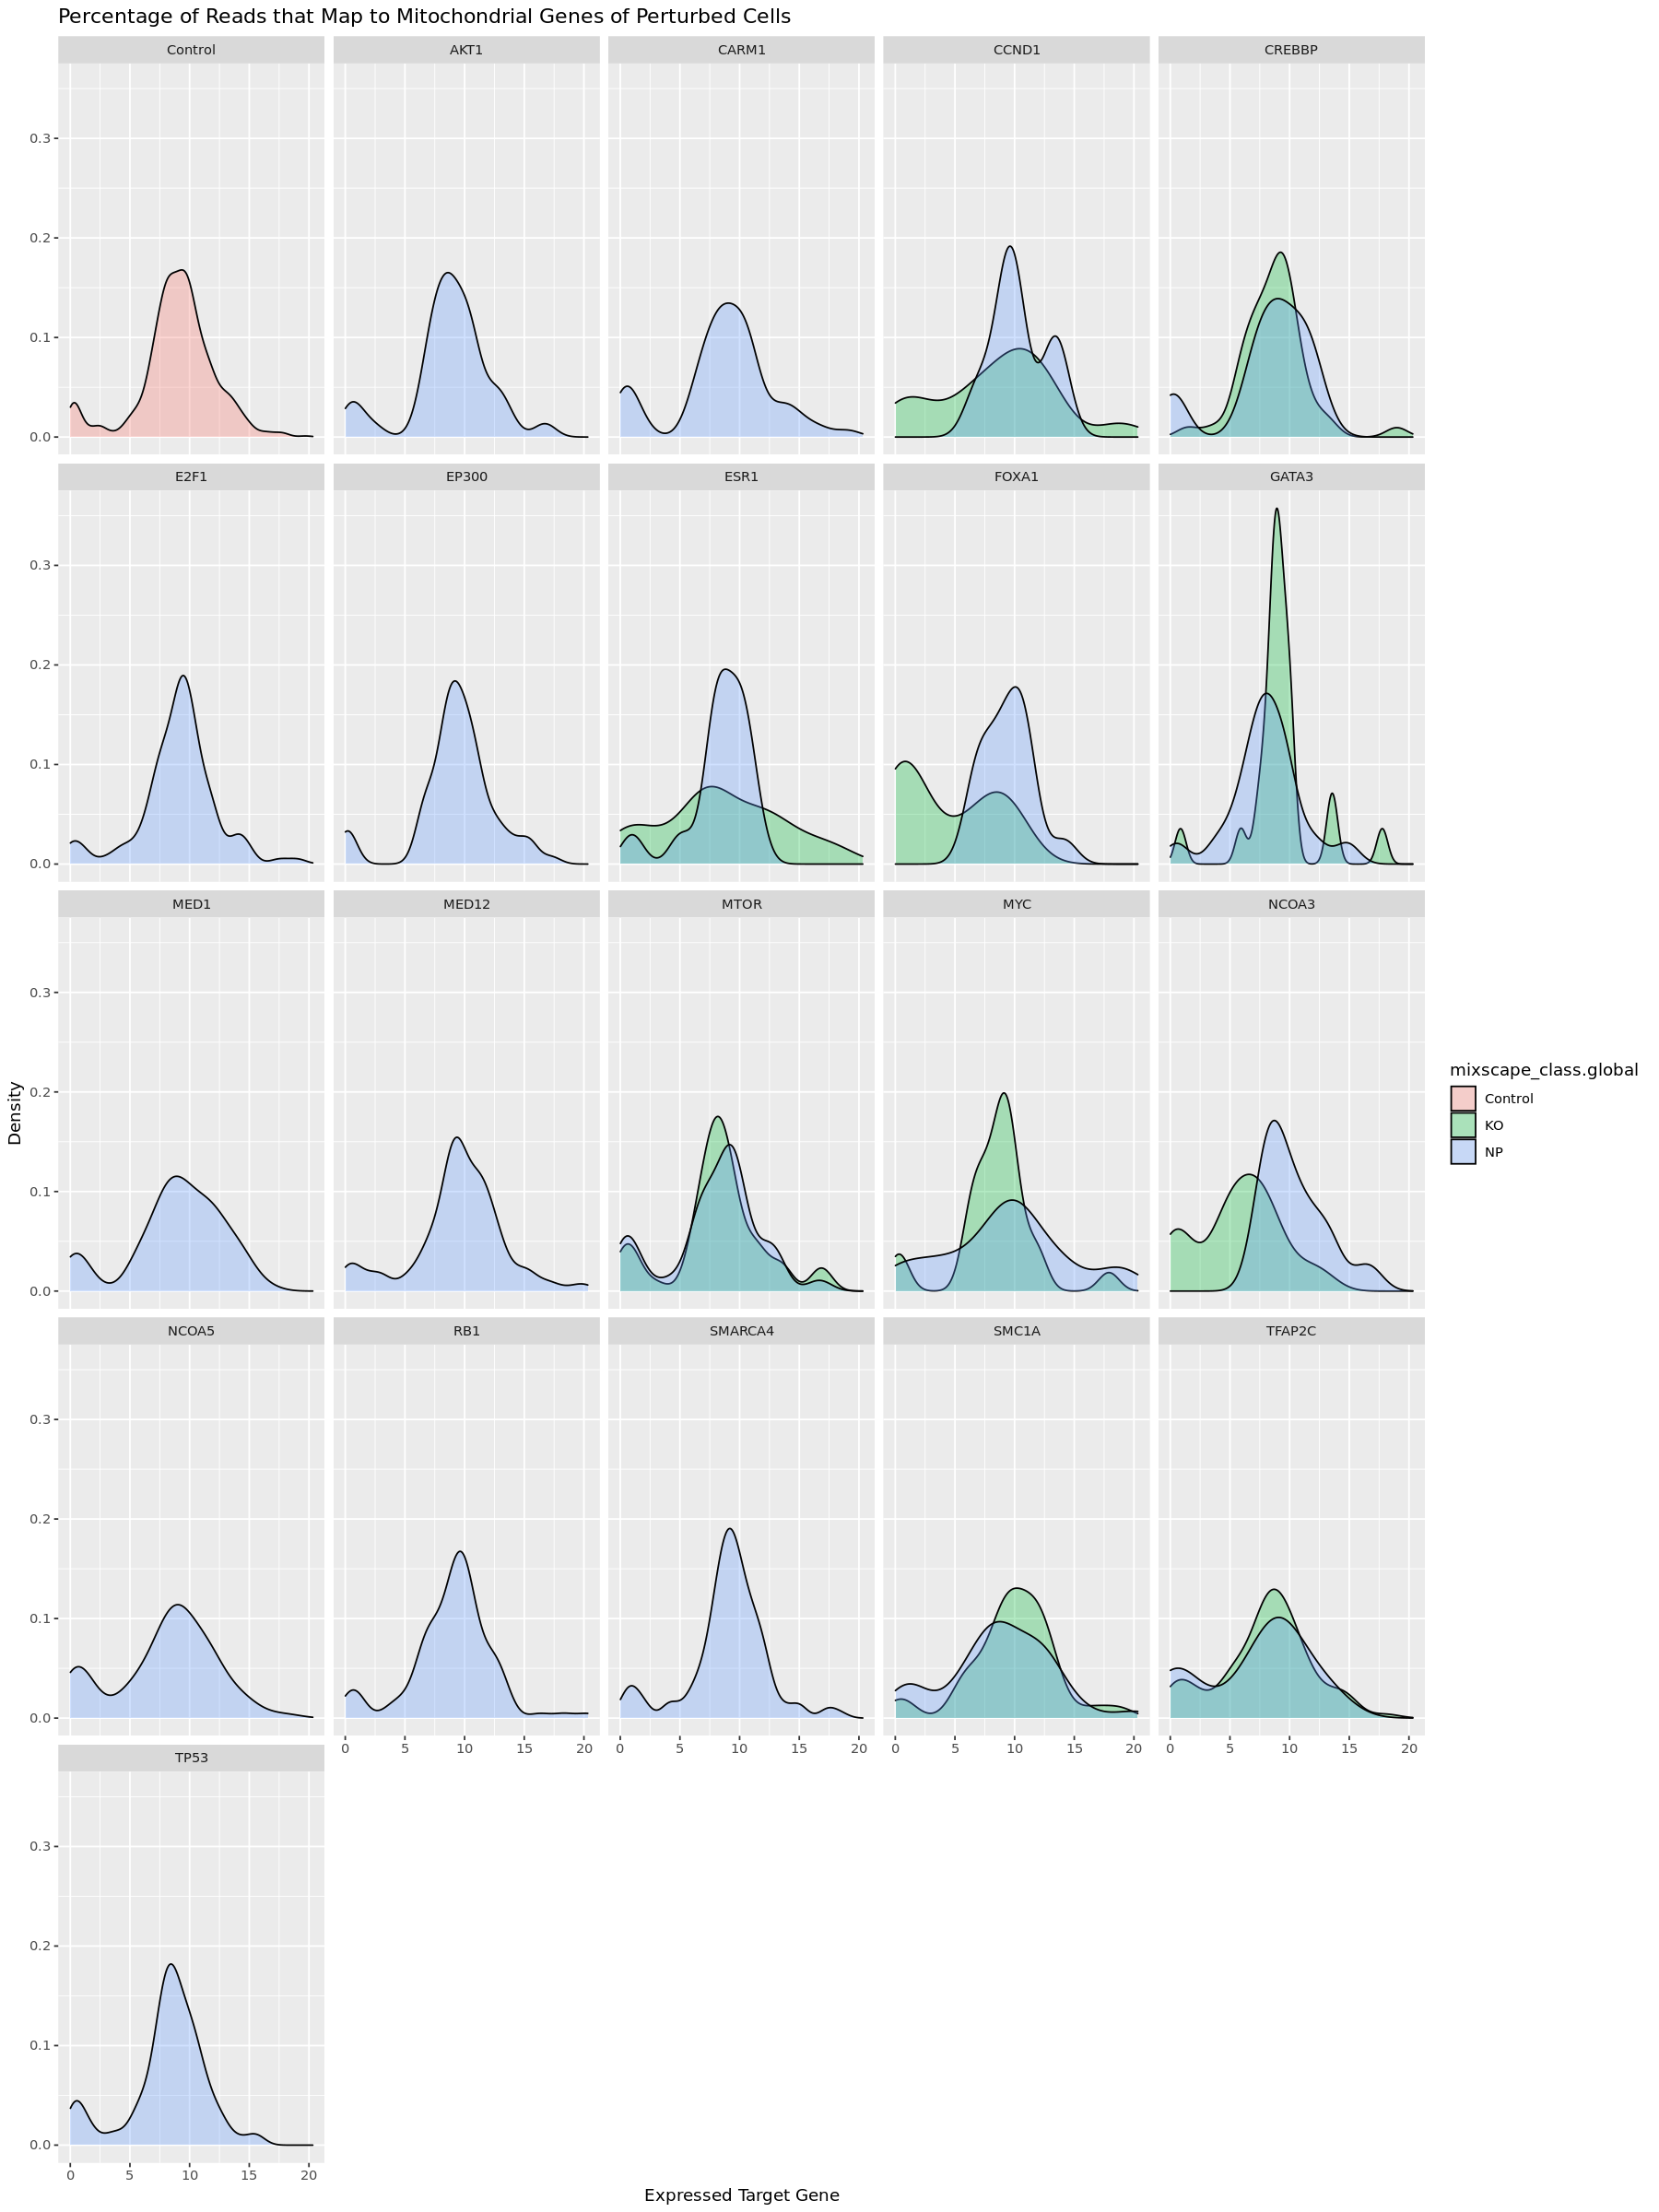

In [120]:
# Plotting the mito % of Cells per Target Genes
options(repr.plot.width=15, repr.plot.height=20)

brunello %>% 
  filter(gene %in% expr_genes) %>%
  ggplot(aes(subsets_Mito_percent, fill=mixscape_class.global)) +
    geom_density(alpha = 0.3) +
    labs(x='Expressed Target Gene', y='Density', title='Percentage of Reads that Map to Mitochondrial Genes of Perturbed Cells', 
         colour='Perturbation Status') +
    facet_wrap(~gene_order)

## Knock Out Efficiency of gRNA Library

In [121]:
brunello_gene_ko = calc_gene_ko(brunello)
brunello_grna_ko = calc_grna_ko(brunello)

`summarise()` has grouped output by 'library', 'gene'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'library', 'gene', 'grna_name'. You can
override using the `.groups` argument.


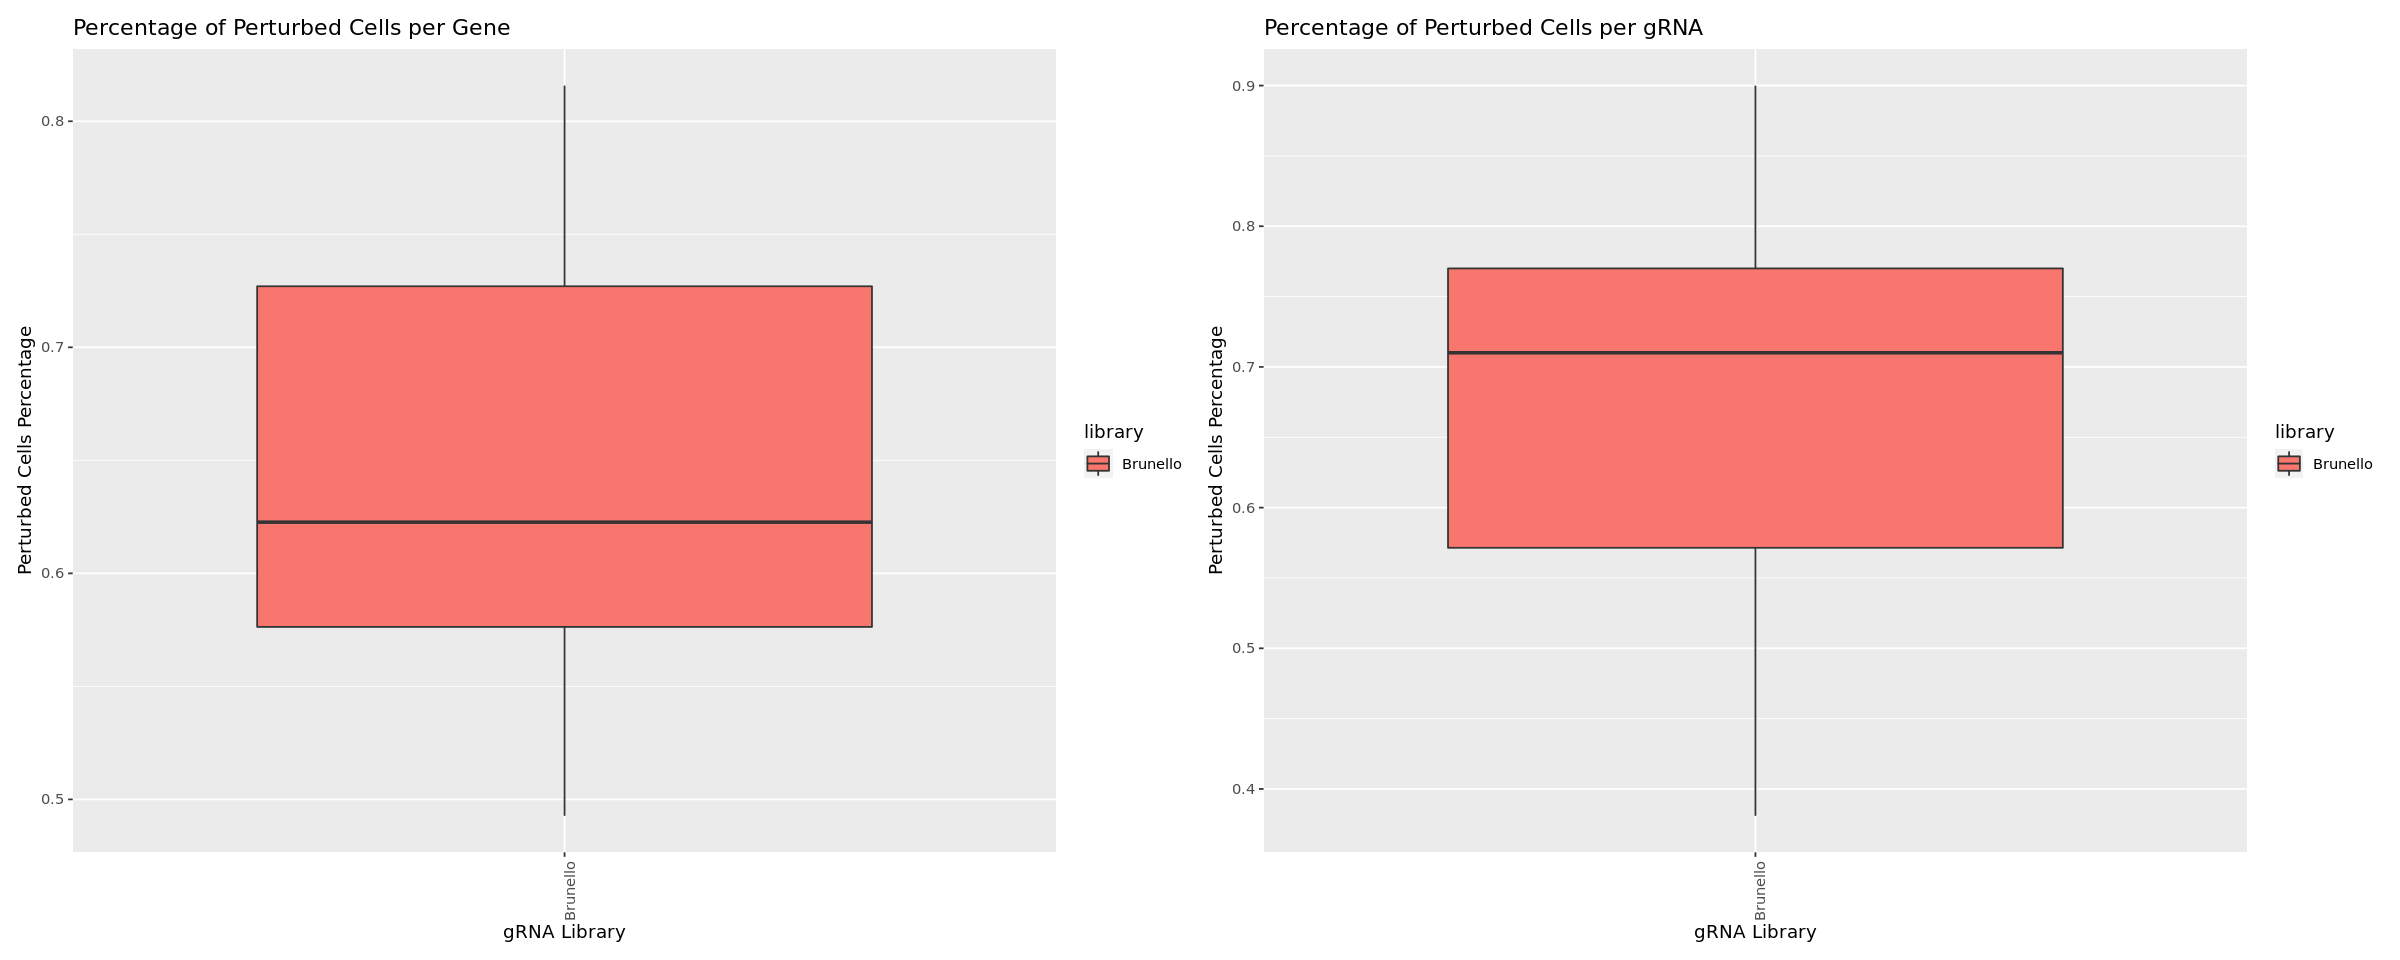

In [122]:
brunello_gene_plot = brunello_gene_ko %>%
                      group_by(library, gene) %>%
                      ggplot(aes(x=library, y=perc, fill=library)) +
                        geom_boxplot() +
                        labs(x='gRNA Library', y='Perturbed Cells Percentage',
                             title='Percentage of Perturbed Cells per Gene') +
                        theme(axis.text.x = element_text(angle = 90, hjust = 1))

brunello_grna_plot = brunello_grna_ko %>%
                      group_by(library, grna_name) %>%
                      ggplot(aes(x=library, y=perc, fill=library)) +
                        geom_boxplot() +
                        labs(x='gRNA Library', y='Perturbed Cells Percentage',
                             title='Percentage of Perturbed Cells per gRNA') +
                        theme(axis.text.x = element_text(angle = 90, hjust = 1))

options(repr.plot.width=20, repr.plot.height=8)
brunello_gene_plot | brunello_grna_plot

## Assessing the Correlation between Log Fold Change of G1 in Cells versus Dropout

In [123]:
ko_g1 = brunello_cell_cycle %>% dplyr::filter((Phase == 'G1') & (global_mixscape == 'KO' | gene == ctrl_label))
carroll = carroll %>% dplyr::filter(gene_name %in% ko_g1$gene)
carroll$gene = carroll$gene_name


# Calculating the Log Fold Change of the Percentage Cells in G1 Phase of the Cell Cycle
ko_g1$log2 = log2(ko_g1$percentage)
ctrl_log2 = ko_g1[ko_g1$gene == 'Control', ]$log2
ko_g1$g1_fold_change = ko_g1$log2 - ctrl_log2

lcf_d3 = left_join(carroll[,c('gene', 'D7_Vs_D3','D9_Vs_D3','D12_Vs_D3','D15_Vs_D3','D20_Vs_D3')],
                         ko_g1[, c('gene', 'g1_fold_change')],
                         by='gene')

lcf_d7 = left_join(carroll[,c('gene', 'D9_Vs_D7','D12_Vs_D7','D15_Vs_D7','D20_Vs_D7')],
                         ko_g1[, c('gene', 'g1_fold_change')],
                         by='gene')

In [124]:
# comparing d3 vs g1 log fold change
lfc1_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D7_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc2_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D9_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc3_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D12_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc4_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D15_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc5_d3 = ggplot(lcf_d3, aes(x=g1_fold_change, y=D20_Vs_D3, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))

# comparing d7 vs g1 log fold change
lfc1_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D9_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc2_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D12_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc3_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D15_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))
lfc4_d7 = ggplot(lcf_d7, aes(x=g1_fold_change, y=D20_Vs_D7, colour=gene)) + geom_point() + scale_y_continuous(limits = c(-4, 0.5))

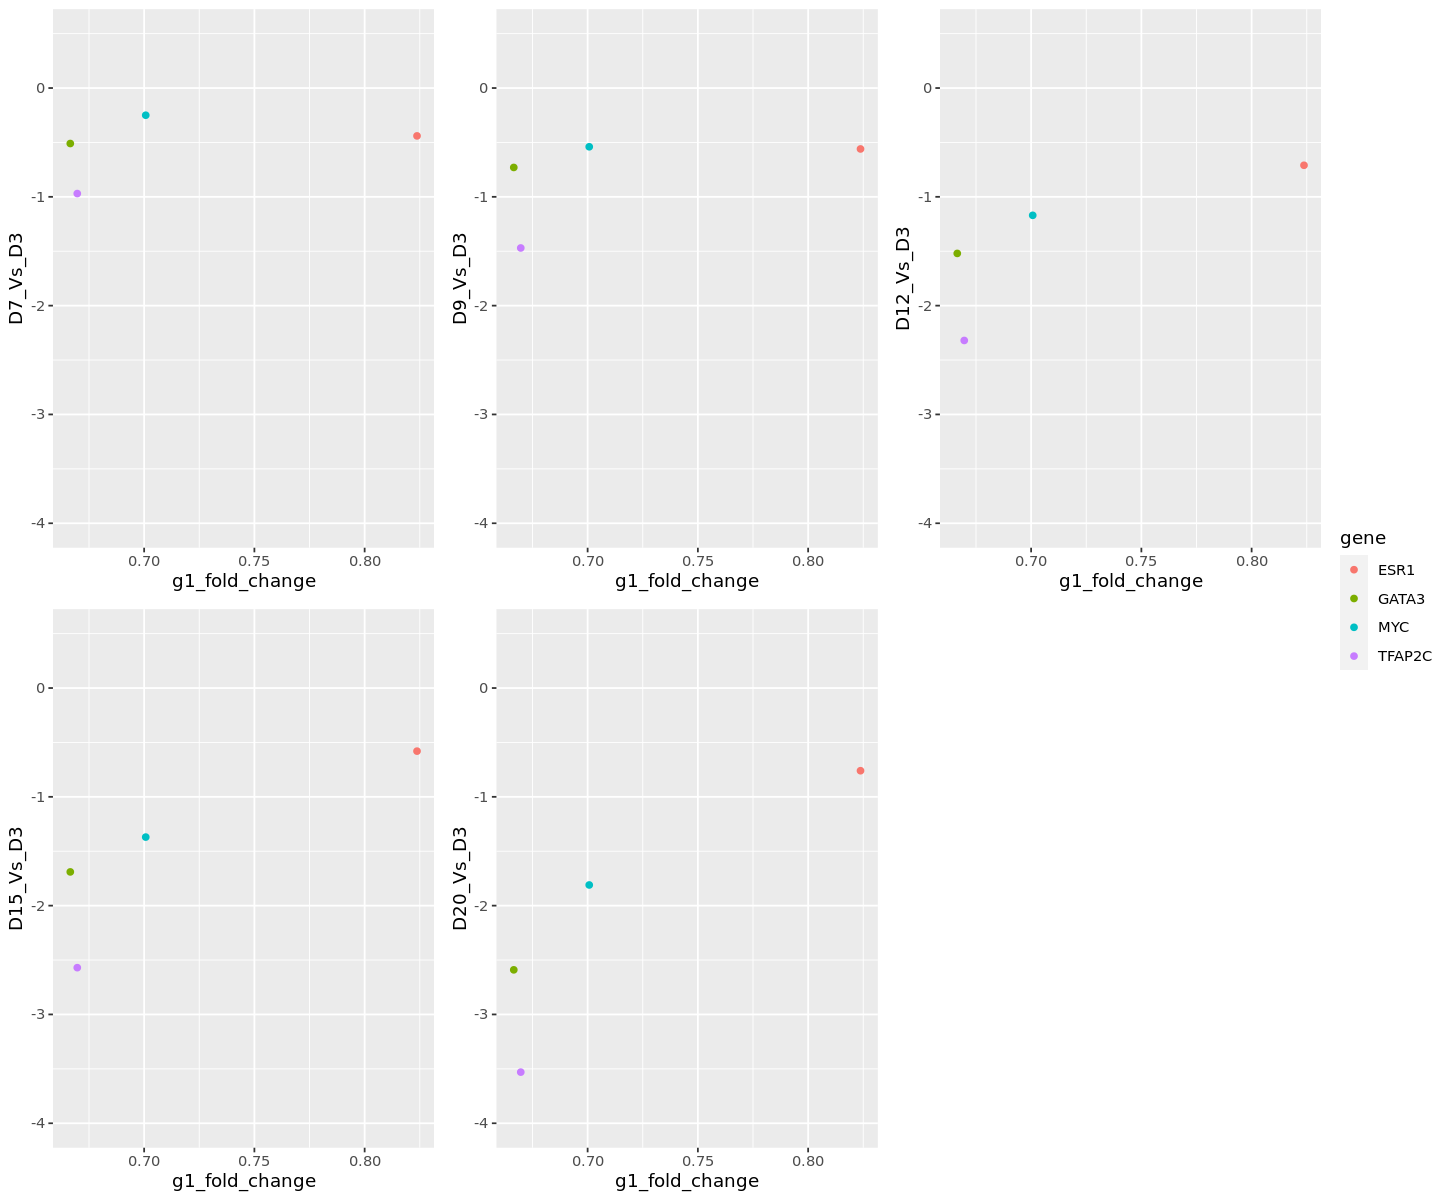

In [125]:
options(repr.plot.width=12, repr.plot.height=10)
ggarrange(lfc1_d3, lfc2_d3, lfc3_d3, lfc4_d3, lfc5_d3, ncol=3, nrow=2, common.legend = TRUE, legend="right")

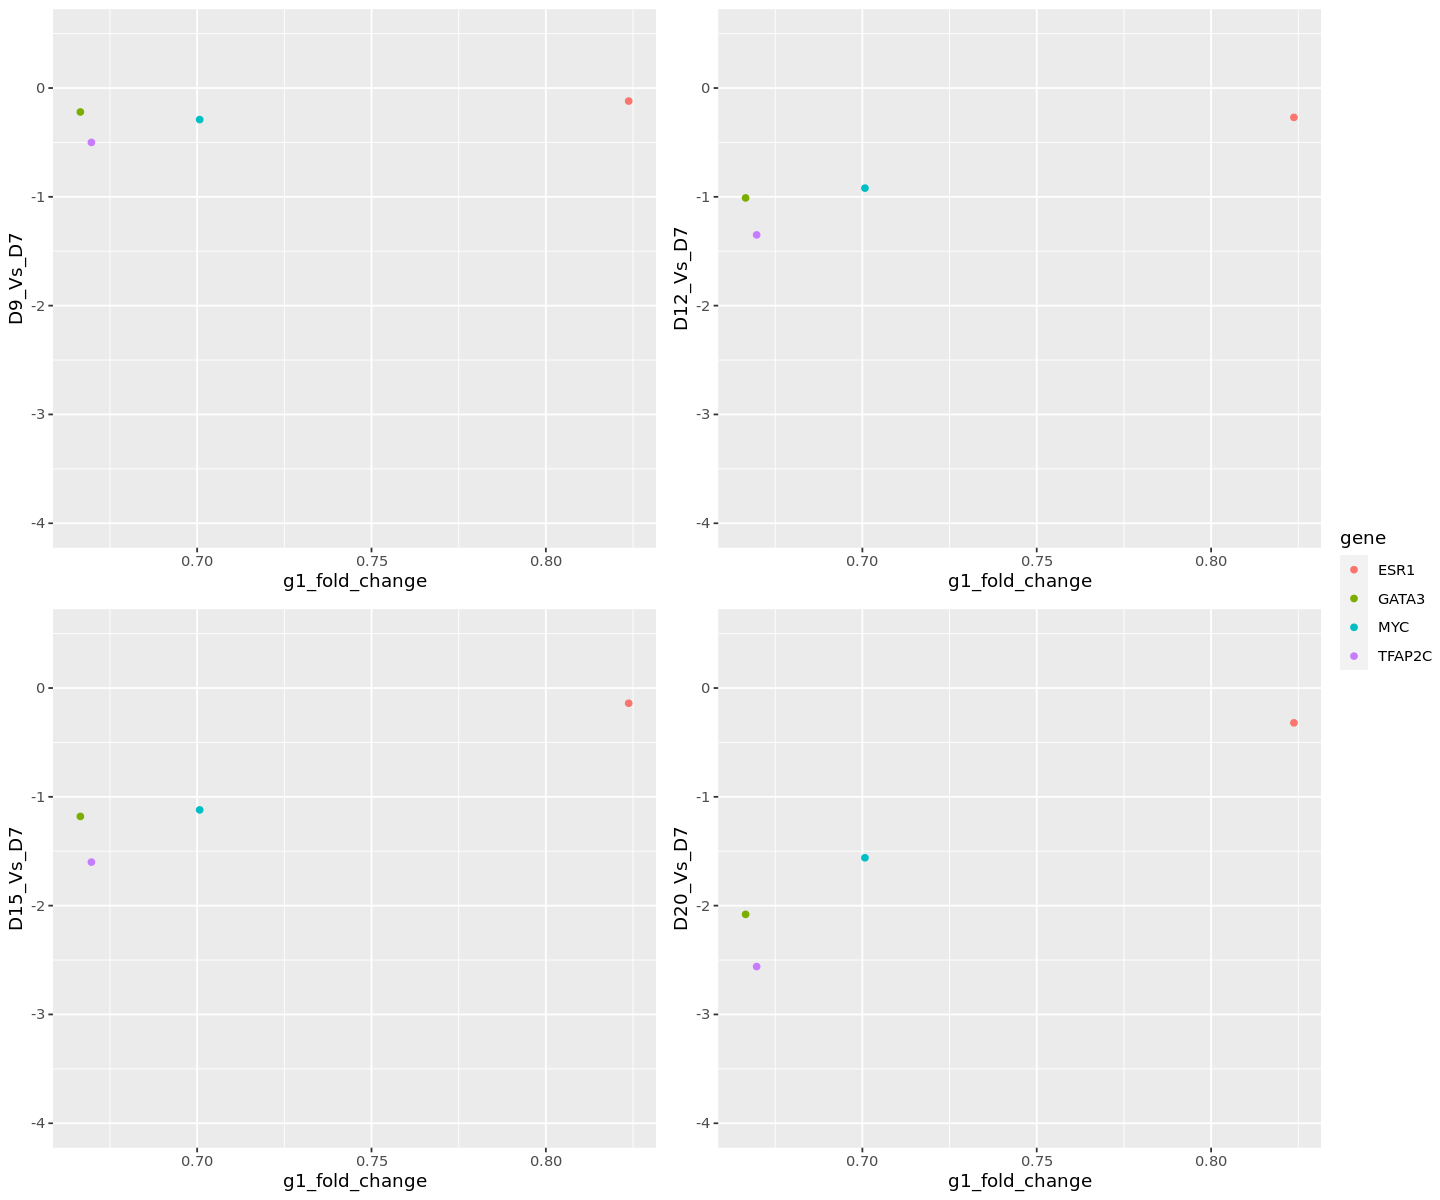

In [126]:
options(repr.plot.width=12, repr.plot.height=10)
ggarrange(lfc1_d7, lfc2_d7, lfc3_d7, lfc4_d7, ncol=2, nrow=2, common.legend = TRUE, legend="right")

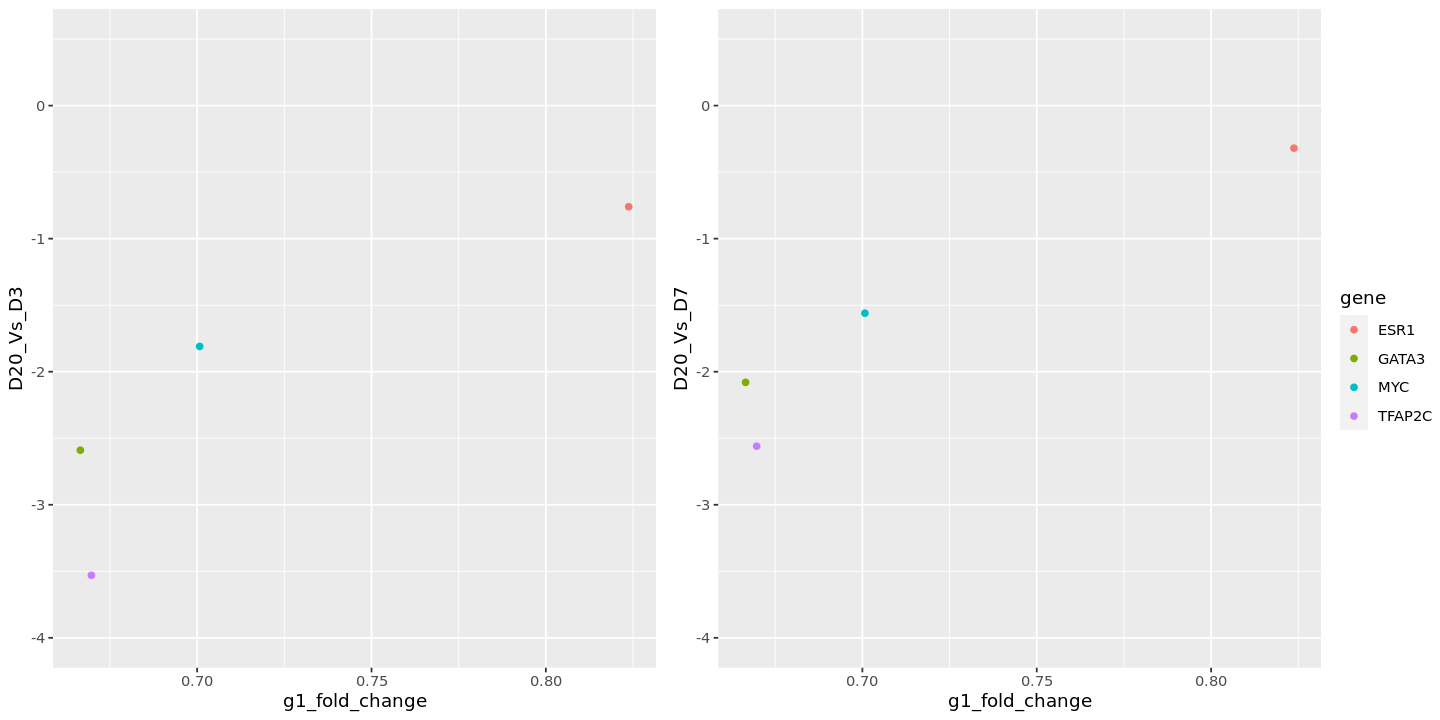

In [127]:
options(repr.plot.width=12, repr.plot.height=6)
ggarrange(lfc5_d3, lfc4_d7, ncol=2, nrow=1, common.legend = TRUE, legend="right")

# Comparing gRNA Library Performance

In [128]:
ggsave("yuza_cell_cycle_plot.eps", plot=yuza_cycle_plot, height=15, width=20, units="in", device = "eps")
ggsave("edwards_cell_cycle_plot.eps", plot=edwards_cycle_plot, height=15, width=20, units="in", device = "eps")
ggsave("brunello_cell_cycle_plot.eps", plot=brunello_cycle_plot, height=15, width=20, units="in", device = "eps")

In [129]:
gene_ko = rbind(yuza_gene_ko, edwards_gene_ko, brunello_gene_ko)
grna_ko = rbind(yuza_grna_ko, edwards_grna_ko, brunello_grna_ko)

gene_ko$library = factor(gene_ko$library, levels = c('Yuza', 'Brunello', 'Edwards'))
grna_ko$library = factor(grna_ko$library, levels = c('Yuza', 'Brunello', 'Edwards'))

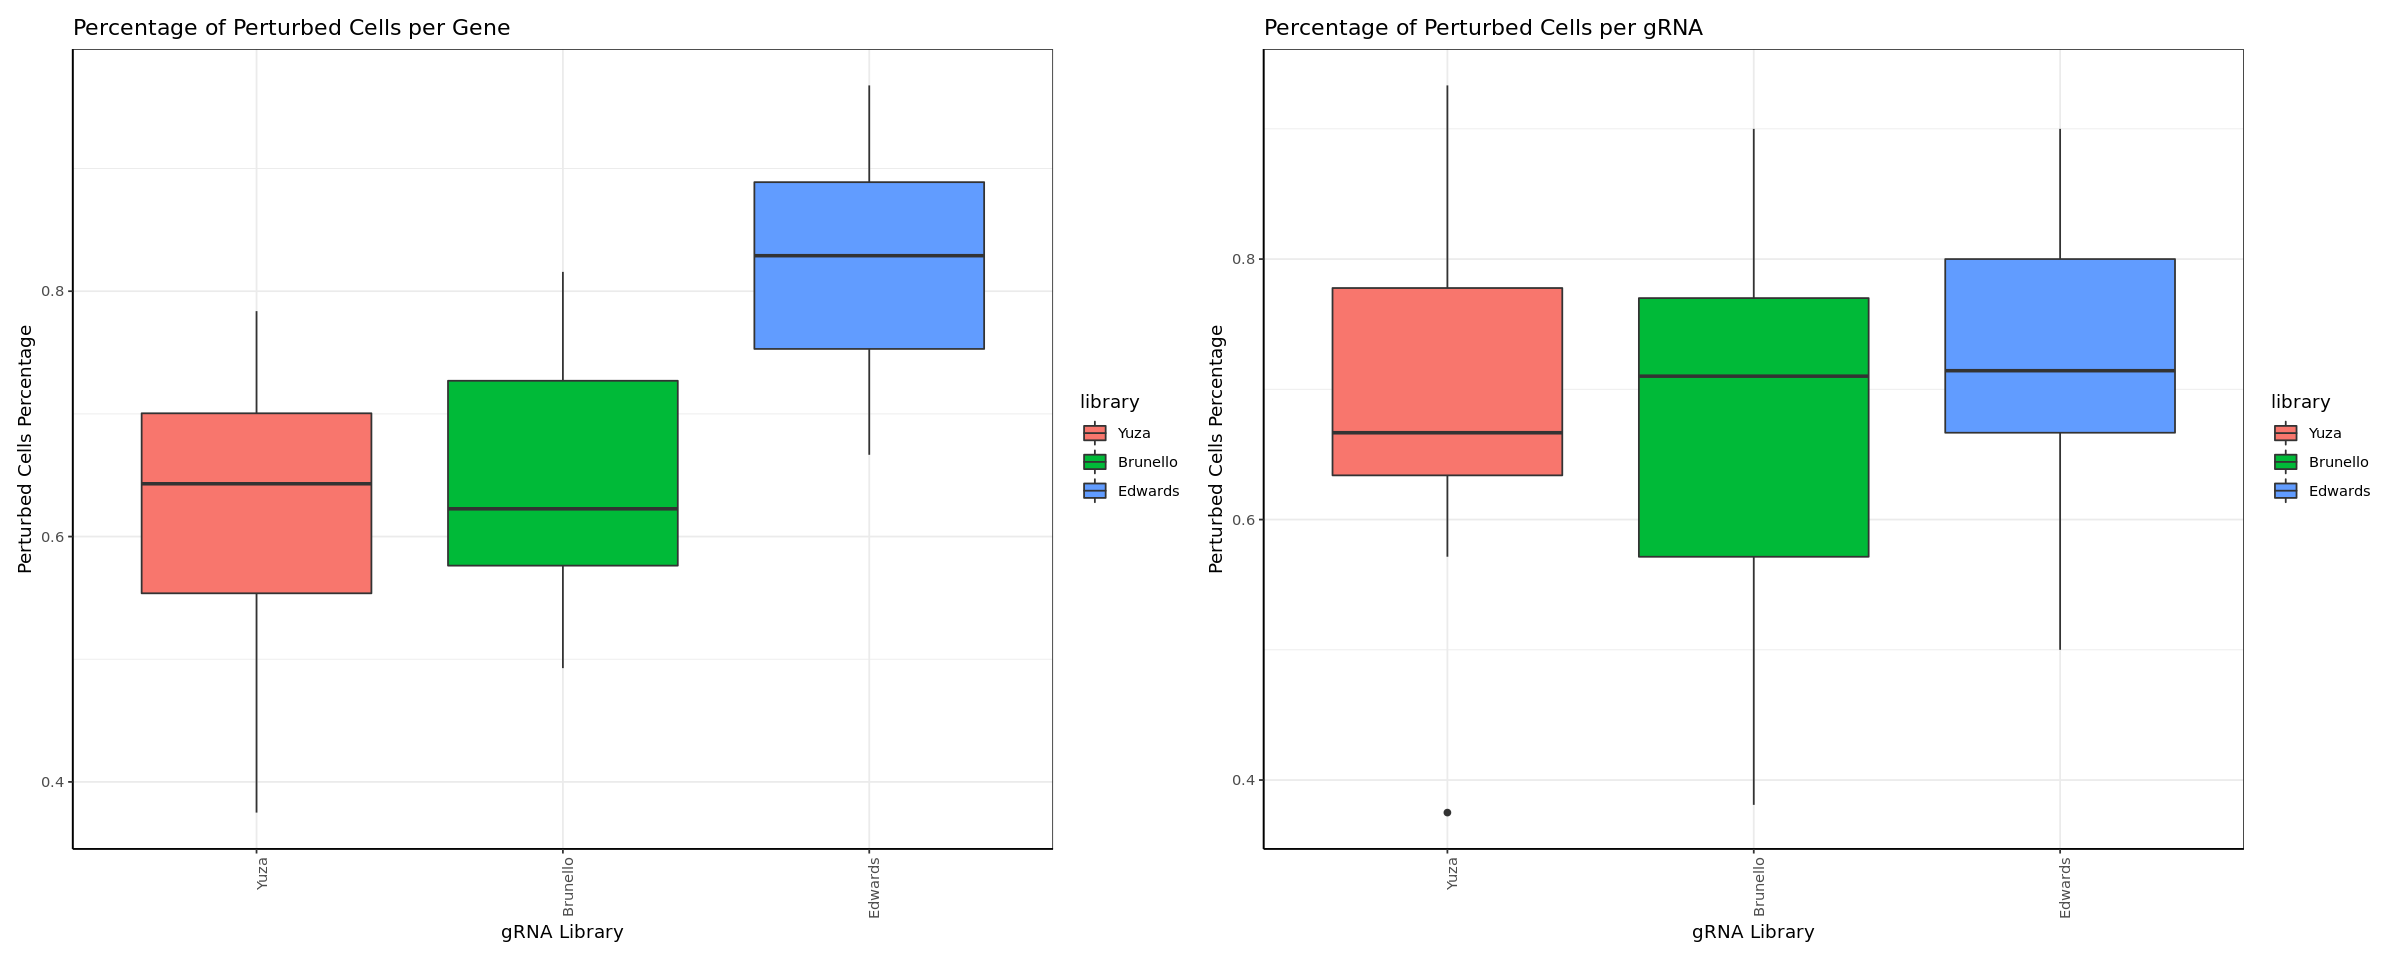

In [130]:
gene_plot = gene_ko %>%
                  group_by(library, gene) %>%
                  ggplot(aes(x=library, y=perc, fill=library)) +
                    geom_boxplot() +
                    labs(x='gRNA Library', y='Perturbed Cells Percentage',
                         title='Percentage of Perturbed Cells per Gene') +
                    theme_bw() +
                    theme(axis.line = element_line(color = 'black'),
                          axis.text.x = element_text(angle = 90, hjust = 1))

grna_plot = grna_ko %>%
                  group_by(library, grna_name) %>%
                  ggplot(aes(x=library, y=perc, fill=library)) +
                    geom_boxplot() +
                    labs(x='gRNA Library', y='Perturbed Cells Percentage',
                         title='Percentage of Perturbed Cells per gRNA') +
                    theme_bw() +
                    theme(axis.line = element_line(color = 'black'),
                          axis.text.x = element_text(angle = 90, hjust = 1))

options(repr.plot.width=20, repr.plot.height=8)
gene_plot | grna_plot

In [131]:
ggsave("gene_performance_boxplot.eps", plot=gene_plot, height=8, width=8, units="in", device = "eps")
ggsave("grna_performance_boxplot.eps", plot=grna_plot, height=8, width=8, units="in", device = "eps")

## Is gRNA Library On-Target Efficiency Statistically Signficant?

In the violin plot above I have observed large shifts in the apparent KO Cell percentage per target gene between the various libraries. I am going to test this using a simple t-test on the percentage of cells per target gene that are Knocked Out. The results of this test shows that the Edwards library is on-target performance is statistically significant in comparison to the Yuza library but not the Brunello library. I also compared the Brunello vs Yuza library and observed that while the Brunello appears to out perform the edwards library it is as of this analysis not statistcally significant.

## Gene Level Analysis

In [132]:
yuza_lib = gene_ko[gene_ko$library == 'Yuza',]
edwards_lib = gene_ko[gene_ko$library == 'Edwards',] 
brunello_lib = gene_ko[gene_ko$library == 'Brunello',]

edwards_vs_yuza = wilcox.test(edwards_lib$perc, yuza_lib$perc, alternative="two.sided")$p.value
brunello_vs_yuza = wilcox.test(brunello_lib$perc, yuza_lib$perc, alternative="two.sided")$p.value
edwards_vs_brunello = wilcox.test(edwards_lib$perc, brunello_lib$perc, alternative="two.sided")$p.value

print (paste0("Edwards vs Yuza Library On-Target Efficiency: p-value ", edwards_vs_yuza))
print (paste0("Edwards vs Brunello Library On-Target Efficiency: p-value ", edwards_vs_brunello))
print (paste0("Brunello vs Yuza Library On-Target Efficiency: p-value ", brunello_vs_yuza))

[1] "Edwards vs Yuza Library On-Target Efficiency: p-value 0.0503496503496503"
[1] "Edwards vs Brunello Library On-Target Efficiency: p-value 0.00567234622962177"
[1] "Brunello vs Yuza Library On-Target Efficiency: p-value 0.945054945054945"


In [133]:
gene_ko$pval <- 1
gene_ko$pval[gene_ko$library == 'Yuza'] <- edwards_vs_yuza
gene_ko$pval[gene_ko$library == 'Brunello'] <- edwards_vs_brunello

In [134]:
annotations <- data.frame(
        xpos = c(-Inf,-Inf),
        ypos =  c(-Inf, Inf),
        annotateText = c("Edwards vs Yuza: 0.05", "Edwards vs Brunello: 0.005"),
        hjustvar = c(0,0) ,
        vjustvar = c(0,1)) #<- ad

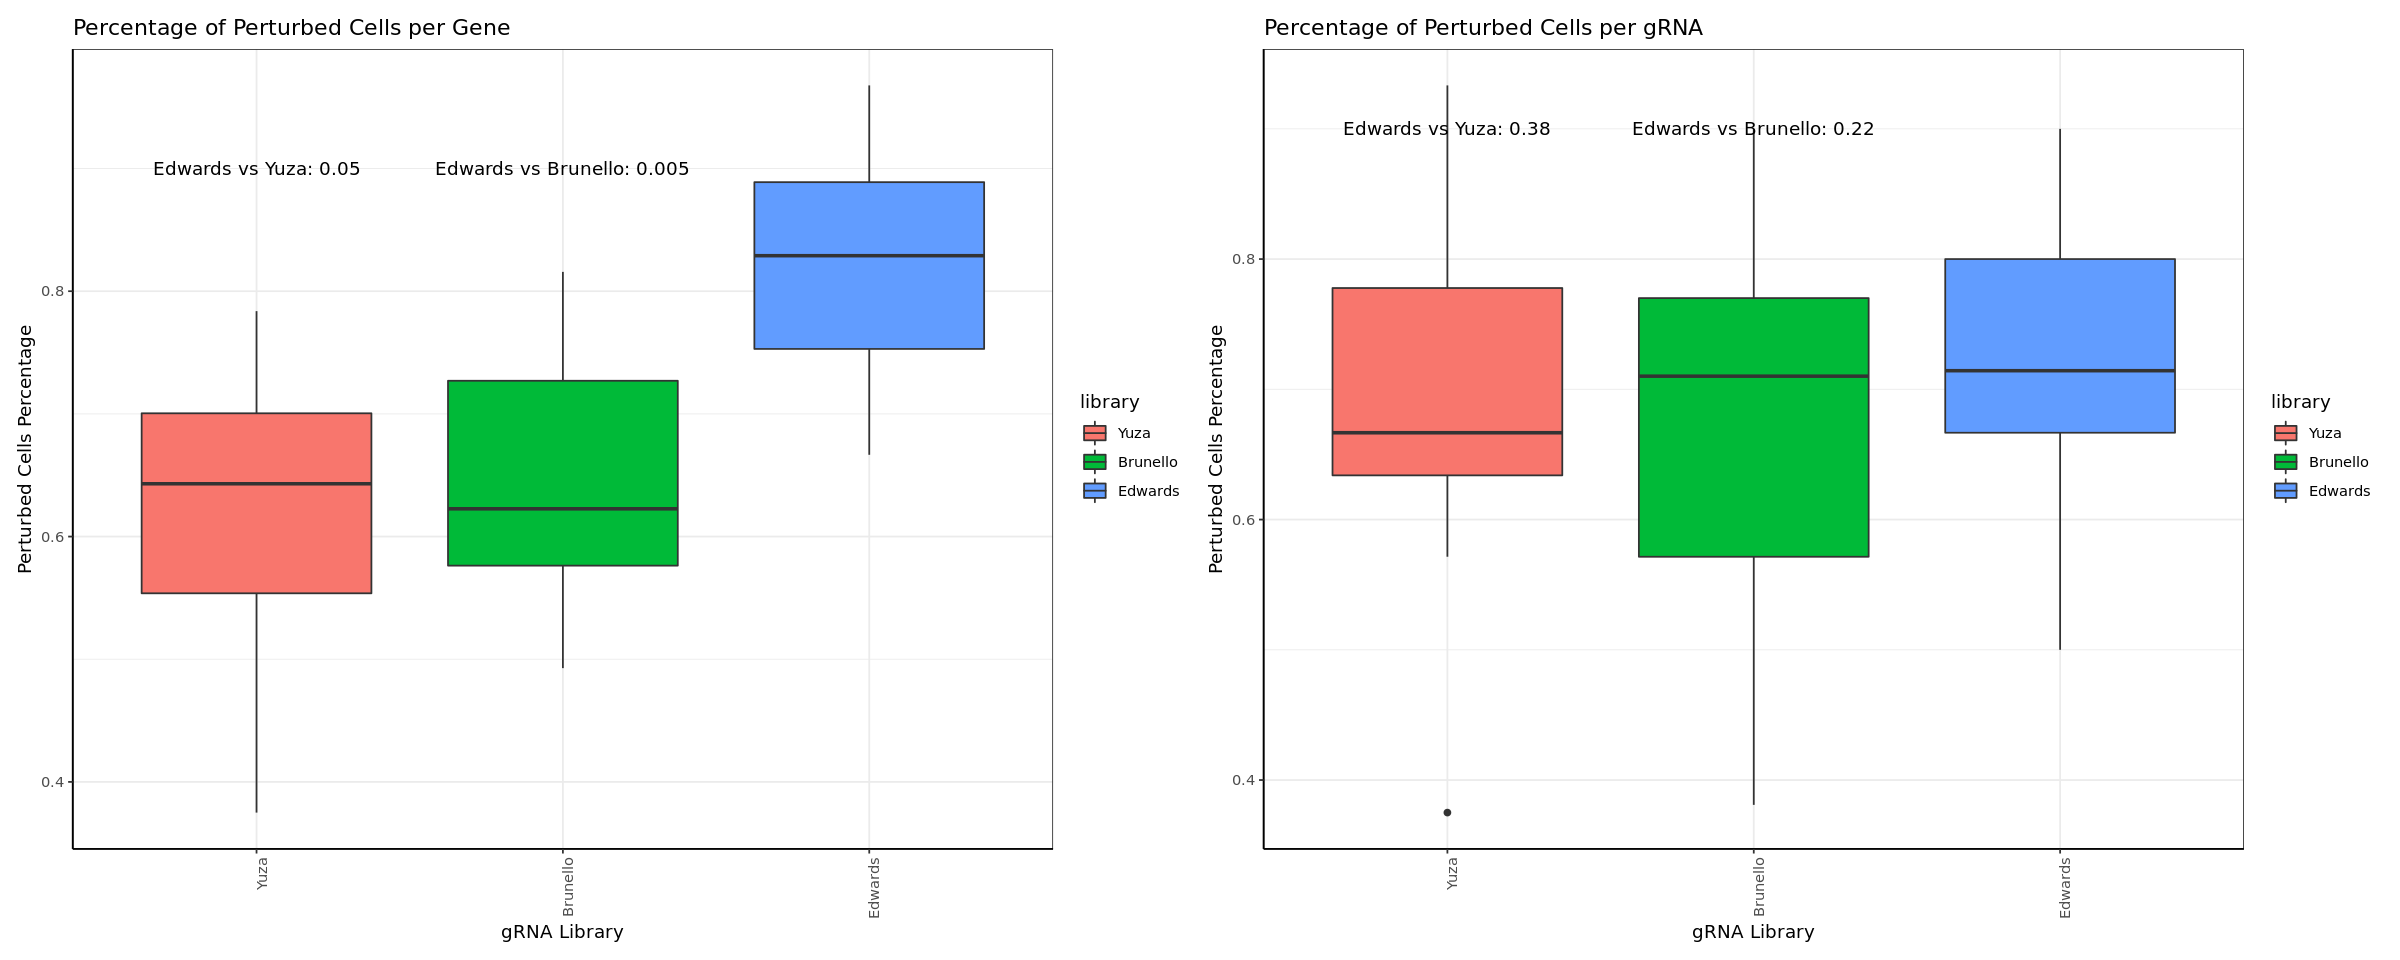

In [135]:
gene_plot = gene_ko %>%
                  group_by(library, gene) %>%
                  ggplot(aes(x=library, y=perc, fill=library)) +
                    geom_boxplot() +
#                     geom_text(data=annotations, aes(x=xpos,y=ypos, hjust=hjustvar, 
#                                                     vjust=vjustvar, label=annotateText)) +
                    labs(x='gRNA Library', y='Perturbed Cells Percentage',
                         title='Percentage of Perturbed Cells per Gene') +
                    theme_bw() +
                    theme(axis.line = element_line(color = 'black'),
                          axis.text.x = element_text(angle = 90, hjust = 1))

gene_plot = gene_plot + 
                annotate(geom="text", x=2, y=0.9, label="Edwards vs Brunello: 0.005") +
                annotate(geom="text", x=1, y=0.9, label="Edwards vs Yuza: 0.05")

grna_plot = grna_ko %>%
                  group_by(library, grna_name) %>%
                  ggplot(aes(x=library, y=perc, fill=library)) +
                    geom_boxplot() +
                    labs(x='gRNA Library', y='Perturbed Cells Percentage',
                         title='Percentage of Perturbed Cells per gRNA') +
                    theme_bw() +
                    theme(axis.line = element_line(color = 'black'),
                          axis.text.x = element_text(angle = 90, hjust = 1))

grna_plot = grna_plot + 
                annotate(geom="text", x=2, y=0.9, label="Edwards vs Brunello: 0.22") +
                annotate(geom="text", x=1, y=0.9, label="Edwards vs Yuza: 0.38")

options(repr.plot.width=20, repr.plot.height=8)
gene_plot | grna_plot

In [136]:
ggsave("gene_performance_boxplot.eps", plot=gene_plot, height=8, width=8, units="in", device = "eps")
ggsave("grna_performance_boxplot.eps", plot=grna_plot, height=8, width=8, units="in", device = "eps")

## gRNA Level Analysis

In [137]:
yuza_lib = grna_ko[grna_ko$library == 'Yuza',]
edwards_lib = grna_ko[grna_ko$library == 'Edwards',] 
brunello_lib = grna_ko[grna_ko$library == 'Brunello',]

edwards_vs_yuza = wilcox.test(edwards_lib$perc, yuza_lib$perc)$p.value
brunello_vs_yuza = wilcox.test(brunello_lib$perc, yuza_lib$perc)$p.value
edwards_vs_brunello = wilcox.test(edwards_lib$perc, brunello_lib$perc)$p.value

print (paste0("Edwards vs Yuza Library On-Target Efficiency: p-value ", edwards_vs_yuza))
print (paste0("Edwards vs Brunello Library On-Target Efficiency: p-value ", edwards_vs_brunello))
print (paste0("Brunello vs Yuza Library On-Target Efficiency: p-value ", brunello_vs_yuza))

Warning message in wilcox.test.default(edwards_lib$perc, yuza_lib$perc):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(brunello_lib$perc, yuza_lib$perc):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(edwards_lib$perc, brunello_lib$perc):
“cannot compute exact p-value with ties”


[1] "Edwards vs Yuza Library On-Target Efficiency: p-value 0.385833981516927"
[1] "Edwards vs Brunello Library On-Target Efficiency: p-value 0.222835732998392"
[1] "Brunello vs Yuza Library On-Target Efficiency: p-value 0.801643147907604"


In [138]:
write.csv(gene_ko, paste0(edwards_dir, '/gRNA/gene_ko.csv'), row.names=FALSE)
write.csv(grna_ko, paste0(edwards_dir, '/gRNA/grna_ko.csv'), row.names=FALSE)

# Exploring Relation between gRNA Performance Meterics to KO Percentage

## Loading gRNA Metadata 

Merge all of the individual gRNA library metadata into 1 dataframe for easy of analysis. 

In [139]:
# merging the gRNA library metadata into 1 dataframe
perturbed = rbind(yuza, edwards, brunello)
df = read.csv(paste0(edwards_dir, '/Metadata/grna_metadata.csv'))
vbc_meta = read.csv('../data/External_Studies_gRNA_Metadata/hg38_all_sgRNAs.txt', sep='\t')
vbc_temp = vbc_meta %>% rename(VBC_score=VBC.score) %>% select(sgRNA, VBC_score)

In [140]:
# I have already run this code
# Yuza library gRNAs that was provided in metrics metadata doesn't match anything and needs to be updated
rownames(df) = NULL
df = subset(df, select = -VBC_score)
df$genotype = paste0(df$leftSeq, df$rightSeq)
grna_seqs = as.character(unique(perturbed[perturbed$library == 'Yuza' | perturbed$grna_name %like% "_merge_" ,]$guideSeq))

rows = c()
grnas = c()

for (row in rownames(df)){
  grna_meta = df[row, ]

  for (grna_seq in grna_seqs) {

    if (grepl(grna_seq, grna_meta$genotype) & !grepl(grna_seq, grna_meta$rightSeq) & !grepl(grna_seq, grna_meta$leftSeq)) {
      rows = c(rows, row)
      grnas = c(grnas, grna_seq)
    }
  }
}

df$guideSeq = as.character(df$guideSeq)
df[rows, ]$guideSeq = grnas

df = df %>%
        left_join(vbc_temp, by='sgRNA') %>%
        mutate(VBC_score= VBC_score * 100,
               lindel_frameshift = lindel_frameshift * 100)

# Merging On Target Activity with gRNA Metadata

Now that all of the gRNA sequences has been provided for each section of metadata. I need to add the gRNA sequence for each gRNA in a given cell. By doing this i can match the KO activity that i calculate below to the gRNA metadata and thereby allow me to compare on-target and off-target features with observed on-target data. In additon, in the code section immediately below I extract observed on-target data including: KO cell count, median probability of KO per cell, and percentage of gRNA containing cells with KO. Out of all the features I've calculate I believe the percentage of gRNA containing cells with KO is a more realistic way of observing KO activity. The other features can be easily skewed through various means that make any comparison unreasonable.

In [141]:
# calculate the KO percentages and counts from single cell data for comparing MIT Score, Fusi Percentile Scores, and Frameshift Probability
on_target_res = perturbed %>%
                    filter(mixscape_class.global != ctrl_label) %>%
                    group_by(grna_name, guideSeq, library) %>%
                    summarize(total = n(), 
                              median_ko_prob = median(p_ko),
                              ko_count = count_if('KO', mixscape_class.global), 
                              np_count = count_if('NP', mixscape_class.global),
                              ko_perc = 100 * (ko_count / total), 
                              np_perc = 100 * (np_count / total)) %>%
                    as.data.frame %>%
                    left_join(df, by='guideSeq') %>%
                    select(-library.y) %>%
                    rename(library=library.x) %>%
                    filter(!is.na(sgRNA) & total >= 10 & ko_perc != 0) %>%
                    distinct() %>%
                    select(grna_name,guideSeq,library,total,MIT_score,fusi_percentiles_score,
                           VBC_score,indelphi_frameshift,lindel_frameshift,forecaster_frameshift,ko_perc)

`summarise()` has grouped output by 'grna_name', 'guideSeq'. You can override
using the `.groups` argument.


## gRNA Performance on the Target Gene Level

Comparing gRNA library performance on the target gene level by visualizing the percentage of cells perturbed and non-perturbed per target gene. It appears that the different gRNA libraries performed better than the other libraries. For instance, the Edwards libraries outperforms all of the other libraies for GATA3 compared to the other libraries. Same could be said about the Brunello libraries ability to KO ESR1 vs the other libraries.

In [142]:
mit_score_plot = ggscatter(on_target_res,
                          x = "MIT_score", 
                          y = "ko_perc",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="MIT Score", y="Knockout Percentage") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)

vbc_score_plot = ggscatter(on_target_res,
                          x = "VBC_score", 
                          y = "ko_perc",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="VBC Score", y="Knockout Percentage") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)


fusi_percentiles_score = ggscatter(on_target_res,
                                  x = "fusi_percentiles_score", 
                                  y = "ko_perc",
                                  add = "reg.line",
                                  add.params = list(color = "blue", fill = "lightgray"), 
                                  conf.int = TRUE) + 
                            labs(x="Fusi Percentiles Score", y="Knockout Percentage") +
                            stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                            ylim(0, 100) + 
                            xlim(25, 100)


##################################### Plots KO Percentage vs Frameshift #####################################

indelphi_fs_plot = ggscatter(on_target_res,
                          x = "indelphi_frameshift", 
                          y = "ko_perc",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="Indelphi Frameshift Probability", y="Knockout Percentage") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)

lindel_fs_plot = ggscatter(on_target_res,
                          x = "lindel_frameshift", 
                          y = "ko_perc",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="Indelphi Frameshift Probability", y="Knockout Percentage") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)

forecaster_fs_plot = ggscatter(on_target_res,
                          x = "forecaster_frameshift", 
                          y = "ko_perc",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="Forecaster Frameshift", y="Knockout Percentage") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)

##################################### Plots prediction metric vs frameshift #####################################

mit_vs_fs_plot = ggscatter(on_target_res,
                          x = "indelphi_frameshift", 
                          y = "MIT_score",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="Indelphi Frameshift Probability", y="MIT Score") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)


vbc_vs_fs_plot = ggscatter(on_target_res,
                          x = "indelphi_frameshift", 
                          y = "VBC_score",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="Indelphi Frameshift Probability", y="VBC Scores") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)

fusi_vs_fs_plot = ggscatter(on_target_res,
                          x = "indelphi_frameshift", 
                          y = "fusi_percentiles_score",
                          add = "reg.line",
                          add.params = list(color = "blue", fill = "lightgray"), 
                          conf.int = TRUE) + 
                    labs(x="Indelphi Frameshift Probability", y="Fusi Percentiles Score") +
                    stat_cor(method = "pearson", label.x = 53, label.y = 90) +
                    ylim(0, 100) + 
                    xlim(25, 100)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'



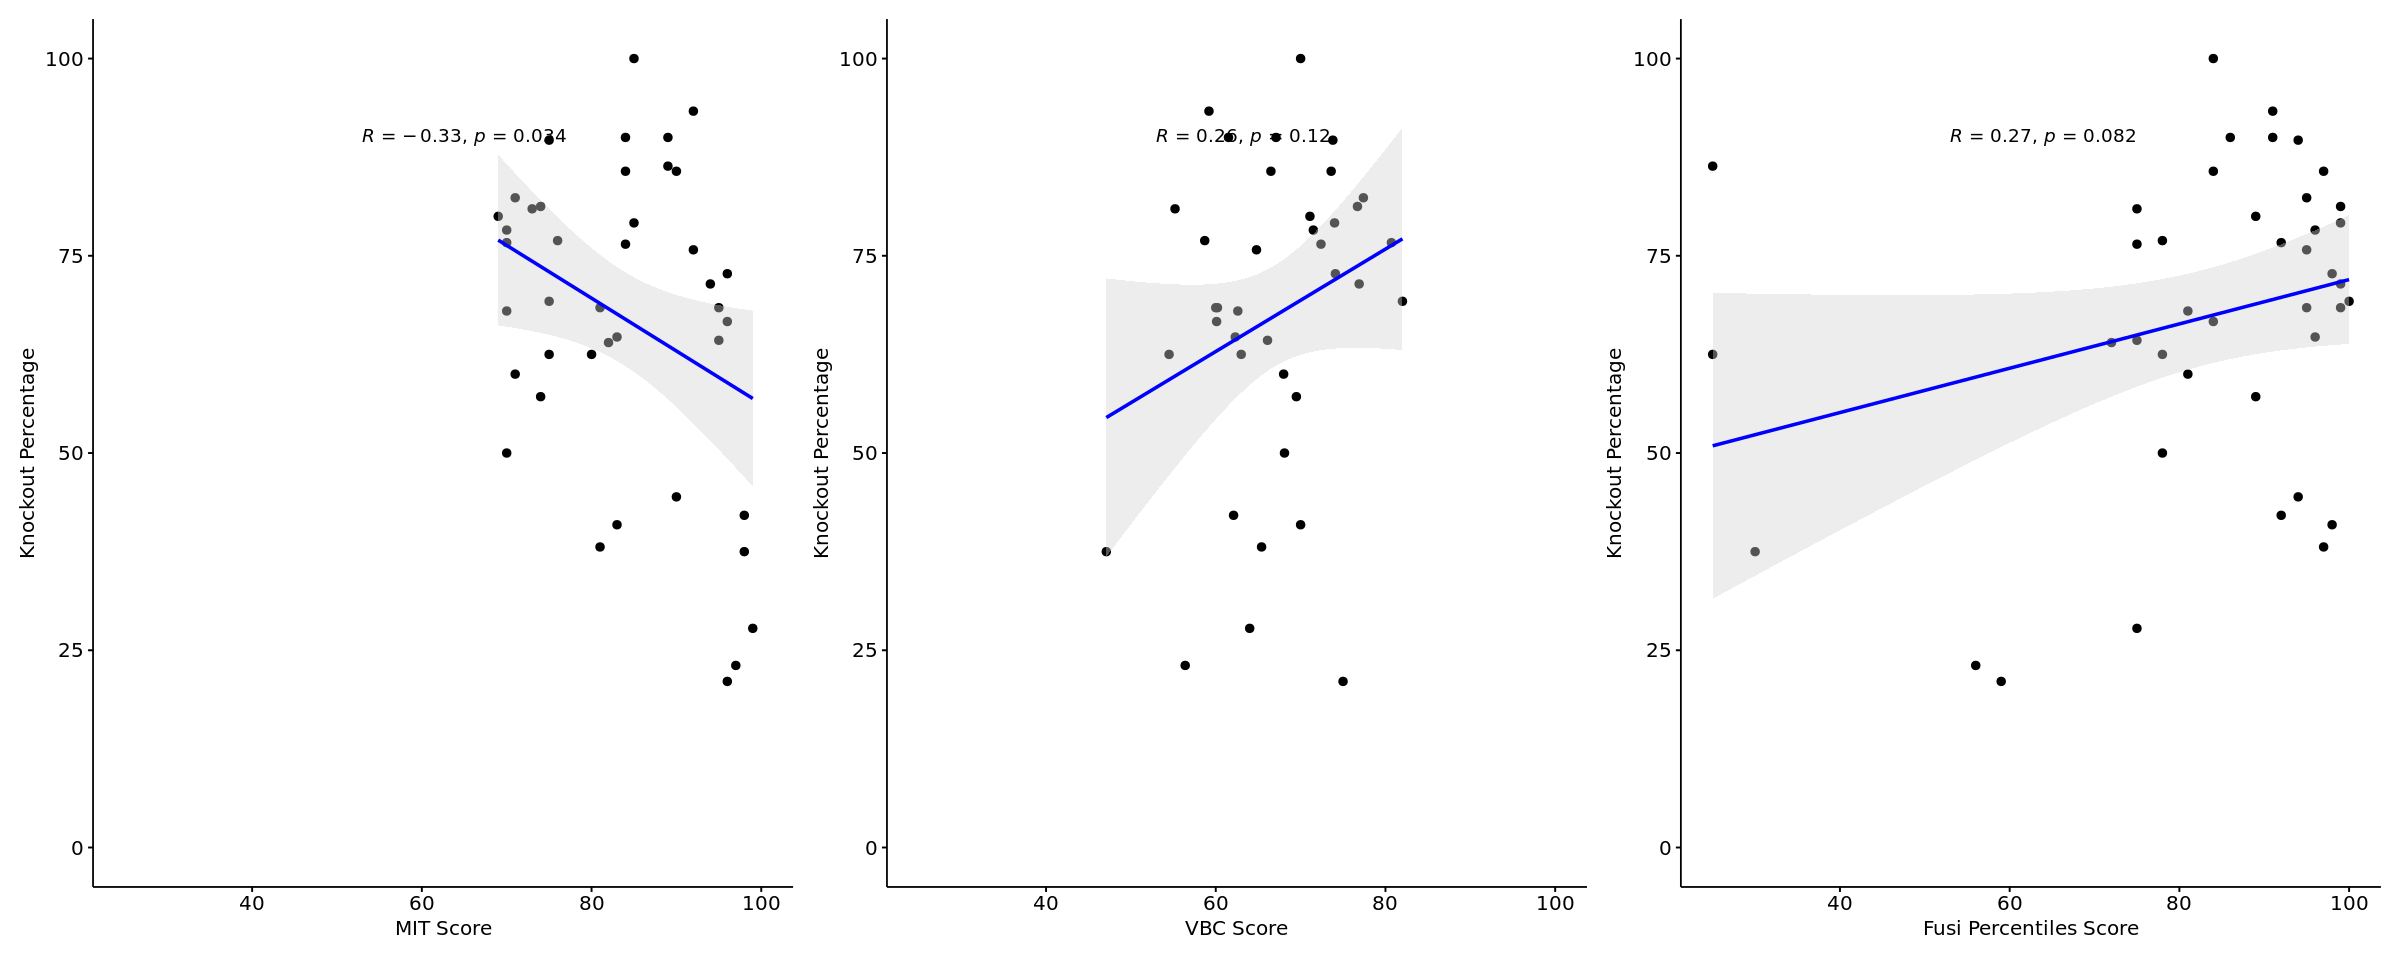

In [143]:
mit_score_plot | vbc_score_plot | fusi_percentiles_score

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



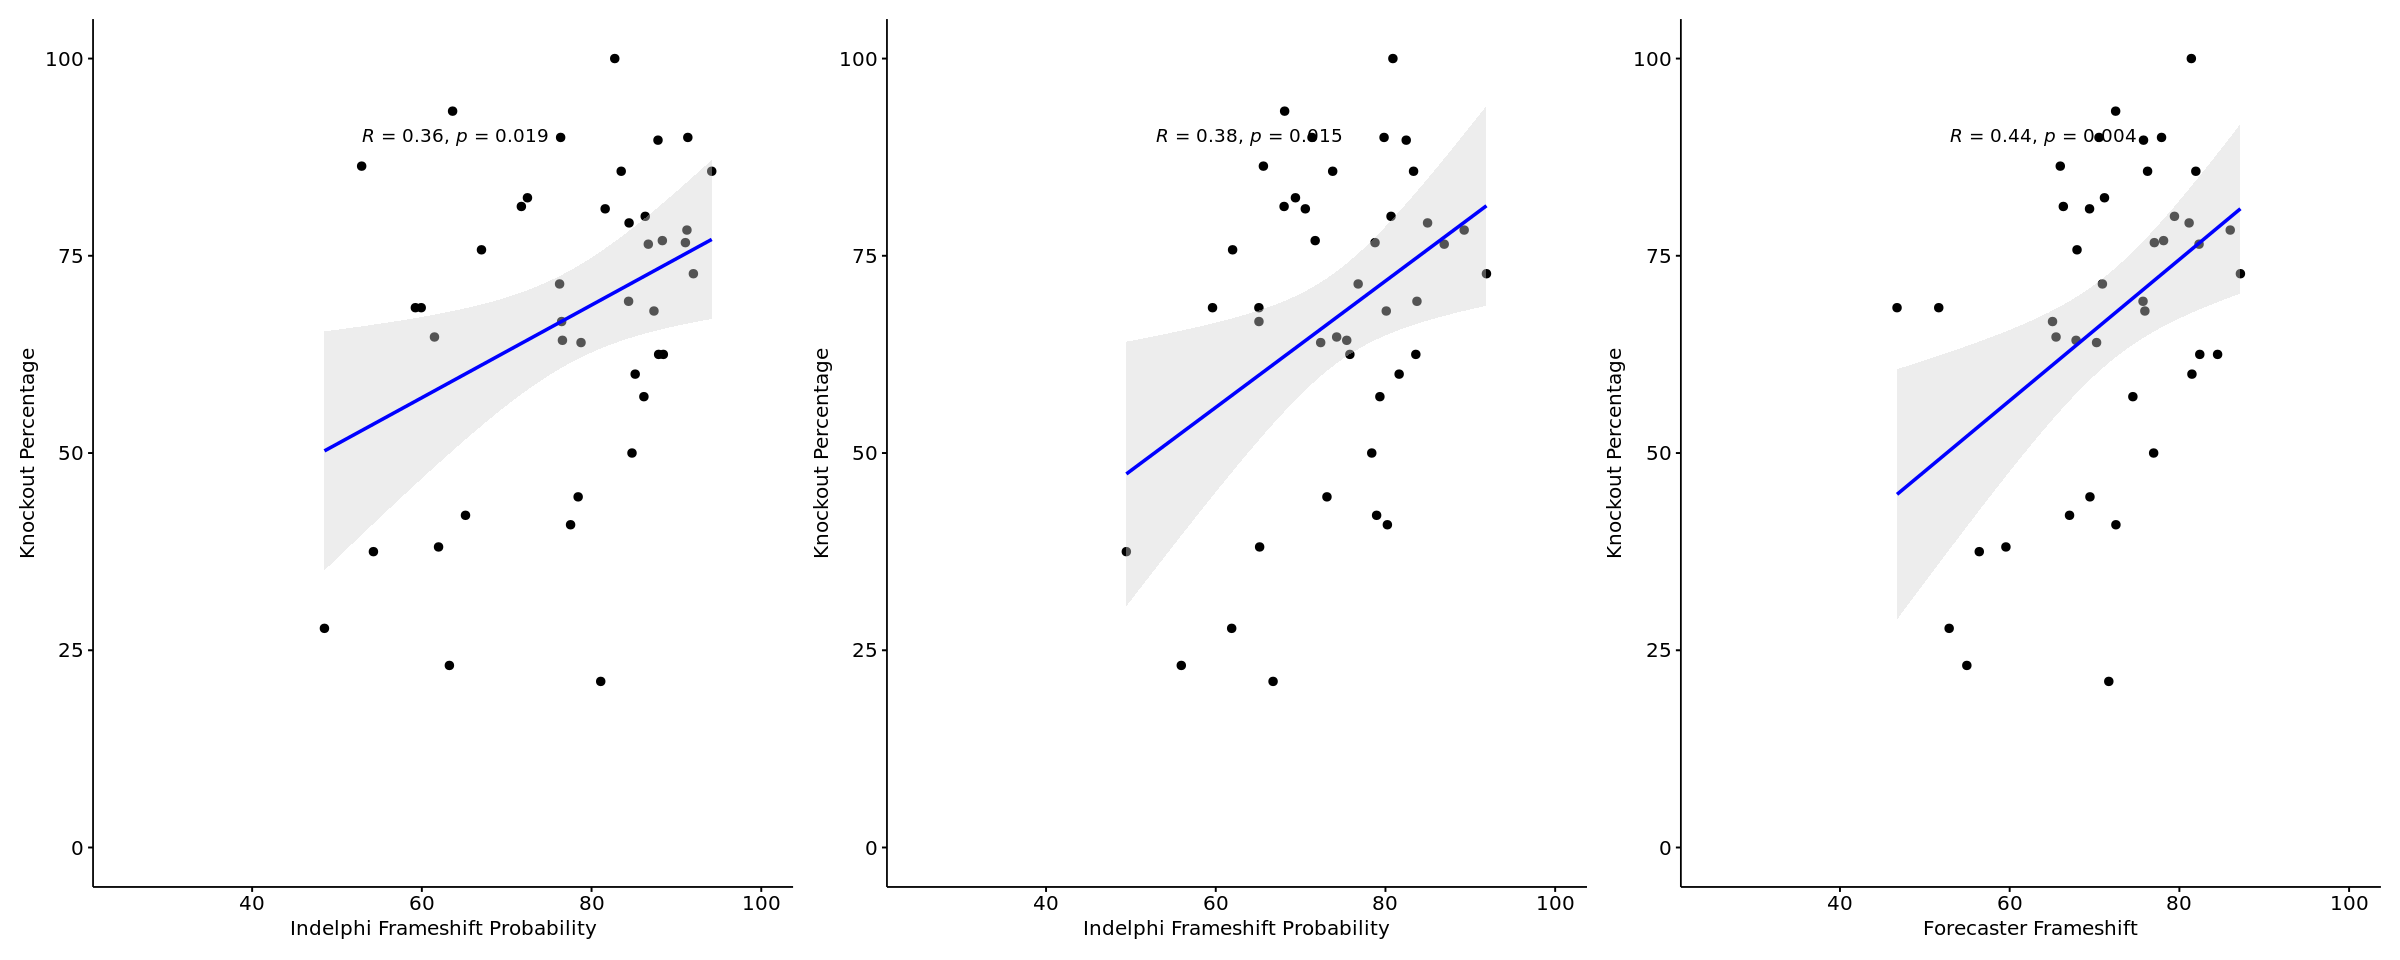

In [144]:
indelphi_fs_plot | lindel_fs_plot | forecaster_fs_plot

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 3 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 3 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'



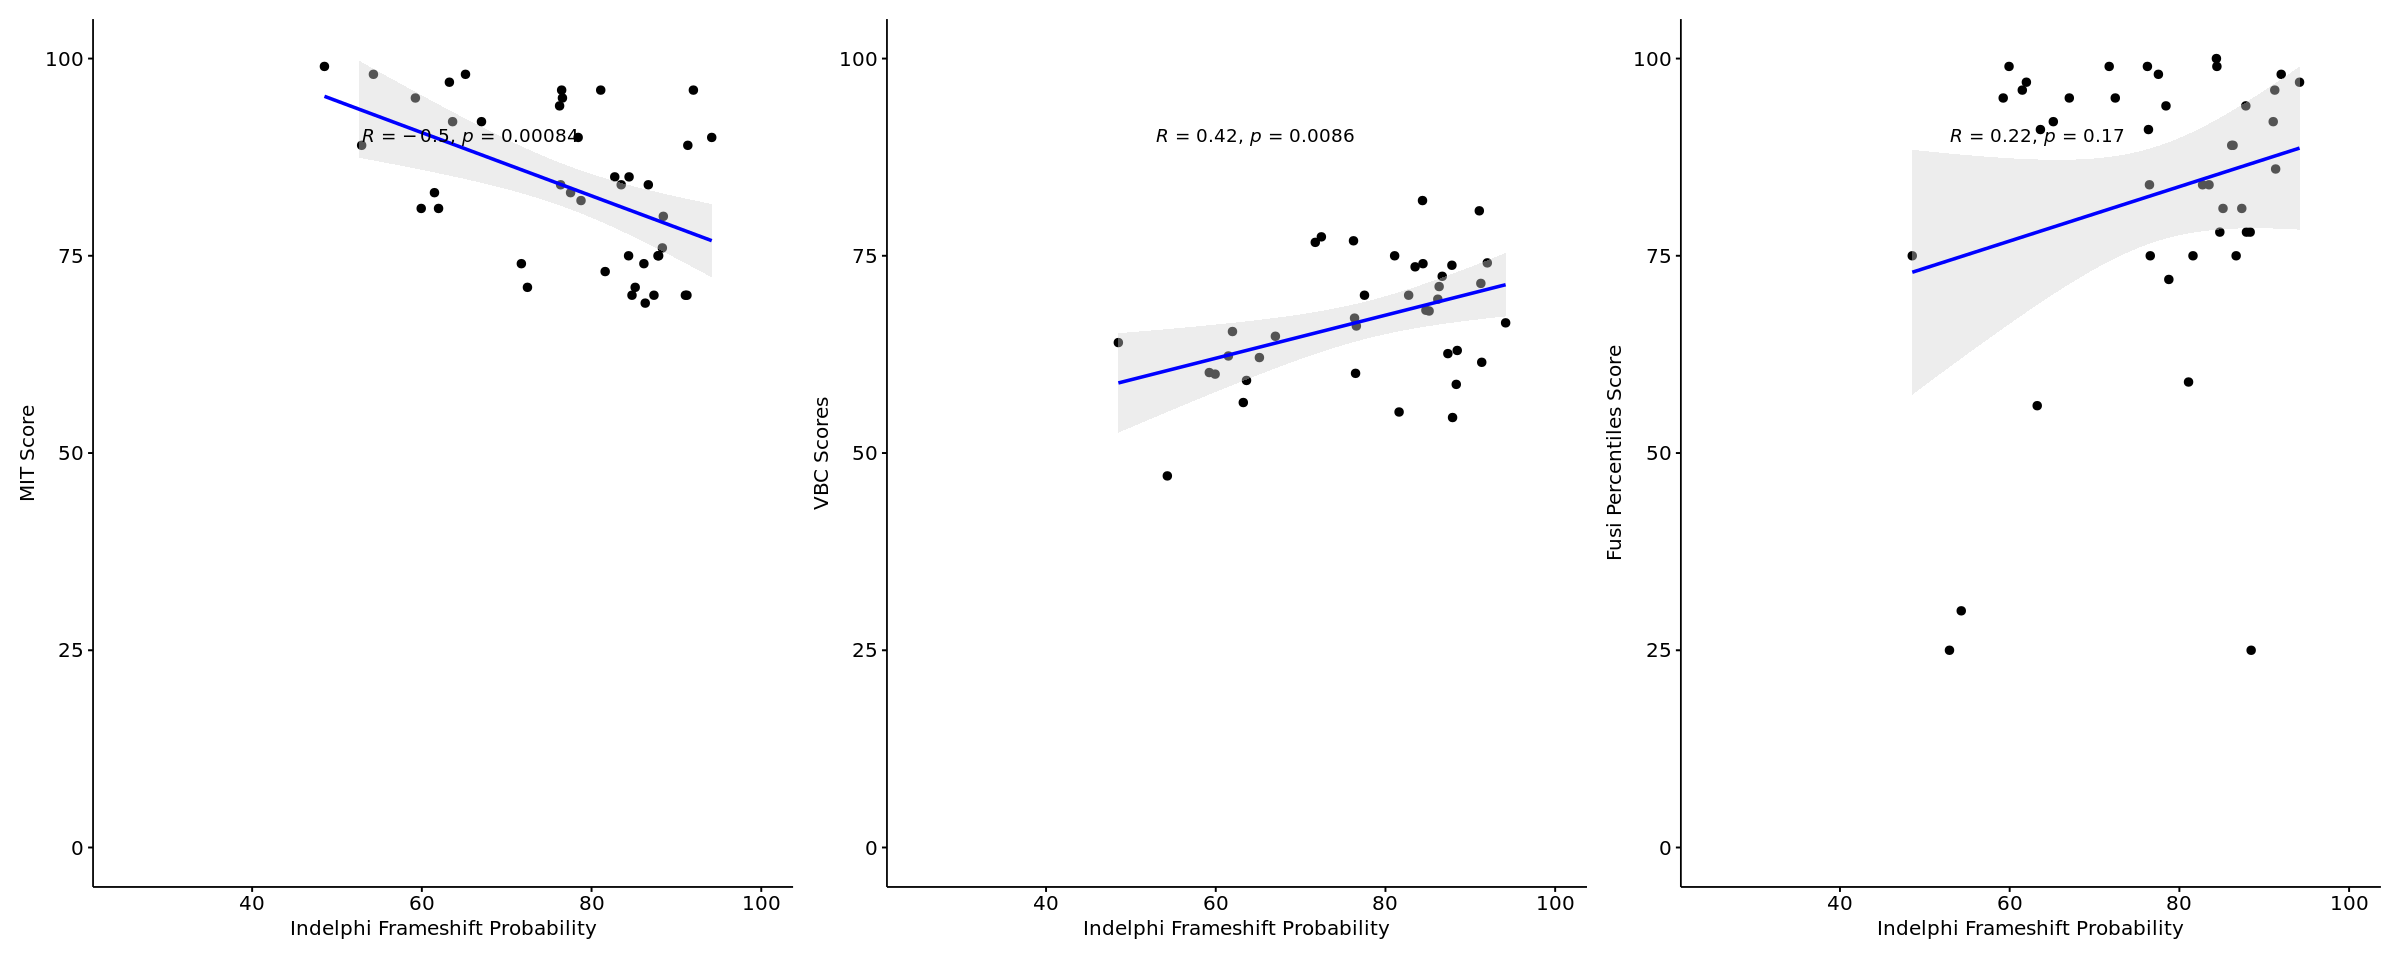

In [145]:
mit_vs_fs_plot | vbc_vs_fs_plot | fusi_vs_fs_plot

In [146]:
# ggsave("mit_scatterplot.eps", plot=mit_score_plot, height=8, width=8, units="in", device = "eps")
# ggsave("vbc_scatterplot.eps", plot=vbc_score_plot, height=8, width=8, units="in", device = "eps")
# ggsave("fusi_percentile_scatterplot.eps", plot=fusi_percentiles_score, height=8, width=8, units="in", device = "eps")
# ggsave("indelphi_fs_scatterplot.eps", plot=indelphi_fs_plot, height=8, width=8, units="in", device = "eps")
# ggsave("lindel_fs_scatterplot.eps", plot=lindel_fs_plot, height=8, width=8, units="in", device = "eps")
# ggsave("forecaster_fs_scatterplot.eps", plot=forecaster_fs_plot, height=8, width=8, units="in", device = "eps")
# ggsave("mit_vs_fs_scatterplot.eps", plot=mit_vs_fs_plot, height=8, width=8, units="in", device = "eps")
# ggsave("vbc_vs_fs_scatterplot.eps", plot=vbc_vs_fs_plot, height=8, width=8, units="in", device = "eps")
# ggsave("fusi_vs_fs_scatterplot.eps", plot=fusi_vs_fs_plot, height=8, width=8, units="in", device = "eps")

In [147]:
on_target_res %>% filter(fusi_percentiles_score >= 70)

grna_name                guideSeq             library  total MIT_score
1  CCND1_69643149_Brunello  AGAGGCCACGAACATGCAAG Brunello 17    71       
2  CCND1_69643890_Brunello  GTGTTCAATGAAATCGTGCG Brunello 11    96       
3  CREBBP_3739583_Brunello  ATTGCCCCCCTCCAAACACG Brunello 24    85       
4  CREBBP_merge_14          GCTCTAAAGGATCGCCGCA  Brunello 19    98       
5  ESR1_151808030_Brunello  TCCAGGTACACCTCGCCCAG Brunello 10    84       
6  ESR1_151808161_Edwards   ACGCCGCAGCCTCAGACCCG Edwards  10    70       
7  ESR1_151808319_Edwards   TACCTGGAGAACGAGCCCAG Edwards  13    75       
8  ESR1_52_Yuza             GCGGCGTTGAACTCGTAGG  Yuza     18    99       
9  FOXA1_37594909_Edwards   CAGCTACTACGCAGACACGC Edwards  21    90       
10 GATA3_51_Yuza            CCGAGTTTCCGTAGTAGGG  Yuza     12    96       
11 GATA3_54_Yuza            GCGTGGCCCCCCGACAAGG  Yuza     15    92       
12 GATA3_8055892_Brunello   AGGTACCCTCCGACCCACCA Brunello 21    81       
13 GATA3_8058432_Brunello   TCCAAGACGTCCATCCACCA Brunello 19    81       
14 MED1_39440460_Edwards    CACGTCAGATATGTTCTATG Edwards  17    84       
15 MED1_39443605_Edwards    GGGTTGTGATGAGTTCTGGA Edwards  23    70       
16 MTOR_11209368_Edwards    TGCATTGGCTAGTGGACCAG Edwards  13    76       
17 MTOR_11209400_Brunello   CAGCATCGGATGCTTAGGAG Brunello 17    83       
18 MTOR_11228787_Brunello   GGTGATGGCCTGGACAACCA Brunello 16    74       
19 MTOR_11237874_Edwards    GCGCAGGAAAGGCATGACAA Edwards  30    70       
20 MTOR_11247653_Edwards    AAGGTCGGAATGCAGCCAAG Edwards  29    75       
21 MTOR_11248002_Brunello   GTGAAGGGGGTAATGTGACG Brunello 22    83       
22 MYC_127738507_Edwards    GTCACACCCTTCTCCCTTCG Edwards  16    75       
23 MYC_127738542_Edwards    CGGTGGCGGGAGCTTCTCCA Edwards  10    71       
24 MYC_52_Yuza              GTGTGACCGCAACGTAGGA  Yuza     28    95       
25 NCOA3_47634078_Brunello  CAACGAGAATCGATATACTG Brunello 14    94       
26 NCOA3_47635426_Edwards   ATGAGTATGTCGCCAAACCA Edwards  10    89       
27 SMC1A_53405850_Edwards   ATTGTGGACTCGGAGAAGAC Edwards  25    82       
28 SMC1A_53412216_Edwards   TCCTTGGCTTTGATGTACTG Edwards  25    70       
29 SMC1A_53414982_Brunello  TTGCCCGTGTCATTGTAGGT Brunello 18    90       
30 SMC1A_53422529_Edwards   AGATTATCGGACCATTTCAG Edwards  28    84       
31 TFAP2C_52_Yuza           TTCCCCCAGATGCGAGTAG  Yuza     19    95       
32 TFAP2C_53_Yuza           GTATTTAGACGTAGAGCTG  Yuza     10    69       
33 TFAP2C_54_Yuza           GGCATTTAAGCATTCAGGT  Yuza     21    74       
34 TFAP2C_56631303_Edwards  GATATTCGGCGACTCCAGTG Edwards  19    85       
35 TFAP2C_56631852_Brunello GATCAGACAGTCATTCGCAA Brunello 33    92       
36 TFAP2C_56633394_Edwards  TCTGAACCTCCCCTGTCAGA Edwards  21    73       
   fusi_percentiles_score VBC_score indelphi_frameshift lindel_frameshift
1   95                    77.4      72.44574            69.39143         
2   98                    74.1      92.00092            91.90148         
3   99                    74.0      84.42133            84.96255         
4   92                    62.1      65.14370            78.95679         
5   91                    67.1      76.35605            71.34143         
6   78                    68.1      84.76583            78.38370         
7  100                    82.0      84.36469            83.71005         
8   75                    64.0      48.52044            61.87610         
9   97                    66.5      94.16210            83.31071         
10  84                    60.1      76.47508            65.08919         
11  91                    59.2      63.62377            68.11739         
12  97                    65.4      61.96916            65.17004         
13  99                    60.0      59.92497            65.08257         
14  75                    72.4      86.68917            86.92433         
15  96                    71.5      91.24112            89.27592         
16  78                    58.7      88.34318            71.71710         
17  96 

In [148]:
# temp = on_target_res %>% 
#             filter(!is.na(VBC_score)) %>%
#             subset(select=-c(grna_name, guideSeq, library, total))

temp = on_target_res %>% 
            filter(library %in% c('Brunello', 'Edwards')) %>% 
            subset(select=-c(grna_name, guideSeq, library, total))

# temp = on_target_res %>% 
#             filter(fusi_percentiles_score >= 70) %>% 
#             subset(select=-c(grna_name, guideSeq, library, total))

corr_df = cor(temp)
corr_df[is.na(corr_df)] = 0

In [149]:
setEPS()
postscript(file="edwards_brunello_feature_correlation_plot.eps", width=8, height=8)
corrplot(corr_df, method = "square", type = "upper", tl.col = "black")
dev.off()

png 
  2